In [68]:
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, NamedTuple, Optional, List
import pandas as pd
from typing import List, Tuple
import json
import numpy as np
from cyvcf2 import VCF
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.container import BarContainer
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
FIGSIZE = (13, 13)
DPI = 300
plt.style.use("ggplot")

PRECISION_KEY = "Precision_edit_dist"
RECALL_KEY = "Recall_edit_dist"
BETA = 0.25  # recall is beta times as important as precision
MAX_COVG = 0
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
RED = ggplot_cm[0]
BLUE = ggplot_cm[1]

In [17]:
def f1_score(precision: float, recall: float) -> float:
    return f_score(precision, recall, beta=1.0)

def f_score(precision: float, recall: float, beta: float = 1.0) -> float:
    """A more general F score, F beta, that uses a positive real factor beta, 
    where beta is chosen such that recall is considered beta times as 
    important as precision.
    Setting to 1 gives the f1 score
    Taken from https://en.wikipedia.org/wiki/F-score
    """
    b2 = beta**2
    return (1 + b2) * ((precision * recall) / ((b2 * precision) + recall))


columns = ["sample", "technology", "tool", "judge", "precision", "recall", "FN", "FP", "f1", "fbeta"]


def extract_results(directory: str, include_varifier: bool=False) -> pd.DataFrame:
    result_files = list(Path(directory).rglob("*summary.csv"))
    if include_varifier:
        result_files.extend(list(Path(directory).rglob("*.json")))
    
    data = []
    for p in result_files:
        sample = p.parts[1]
        tool = p.parts[0]
        if tool.startswith("bcftools-"):
            tool = tool.replace("bcftools-", "")
            tech = "Nanopore"
        else:
            tech = "Illumina"
        judge = p.parts[2]
        if judge == "varifier":
            if not include_varifier:
                continue
            precision = float(d["Precision"][PRECISION_KEY])
            recall = float(d["Recall"][RECALL_KEY])
            fns = int(d["Recall"]["FN"]["Count"])
            fps = int(d["Precision"]["FP"]["Count"])
            f1 = f1_score(precision, recall)
            fbeta = f_score(precision, recall, BETA)
            data.append((sample, tool, judge, precision, recall, fns, fps, f1, fbeta))
        elif judge == "happy":
            d = pd.read_csv(p).query("Type=='SNP' and Filter=='PASS'").to_dict(orient="records")[0]
            precision = float(d["METRIC.Precision"])
            recall = float(d["METRIC.Recall"])
            fns = int(d["TRUTH.FN"])
            fps = int(d["QUERY.FP"])
            f1 = d["METRIC.F1_Score"]
            fbeta = f_score(precision, recall, BETA)
            data.append((sample, tech, tool, judge, precision, recall, fns, fps, f1, fbeta)) 
            
    return pd.DataFrame(data, columns=columns)

In [18]:
include_varifier = False
dfs = []
dfs.append(extract_results("compass", include_varifier=include_varifier))
dfs.extend([extract_results(d, include_varifier=include_varifier) for d in Path().glob("bcftools*")])
df = pd.concat(dfs)

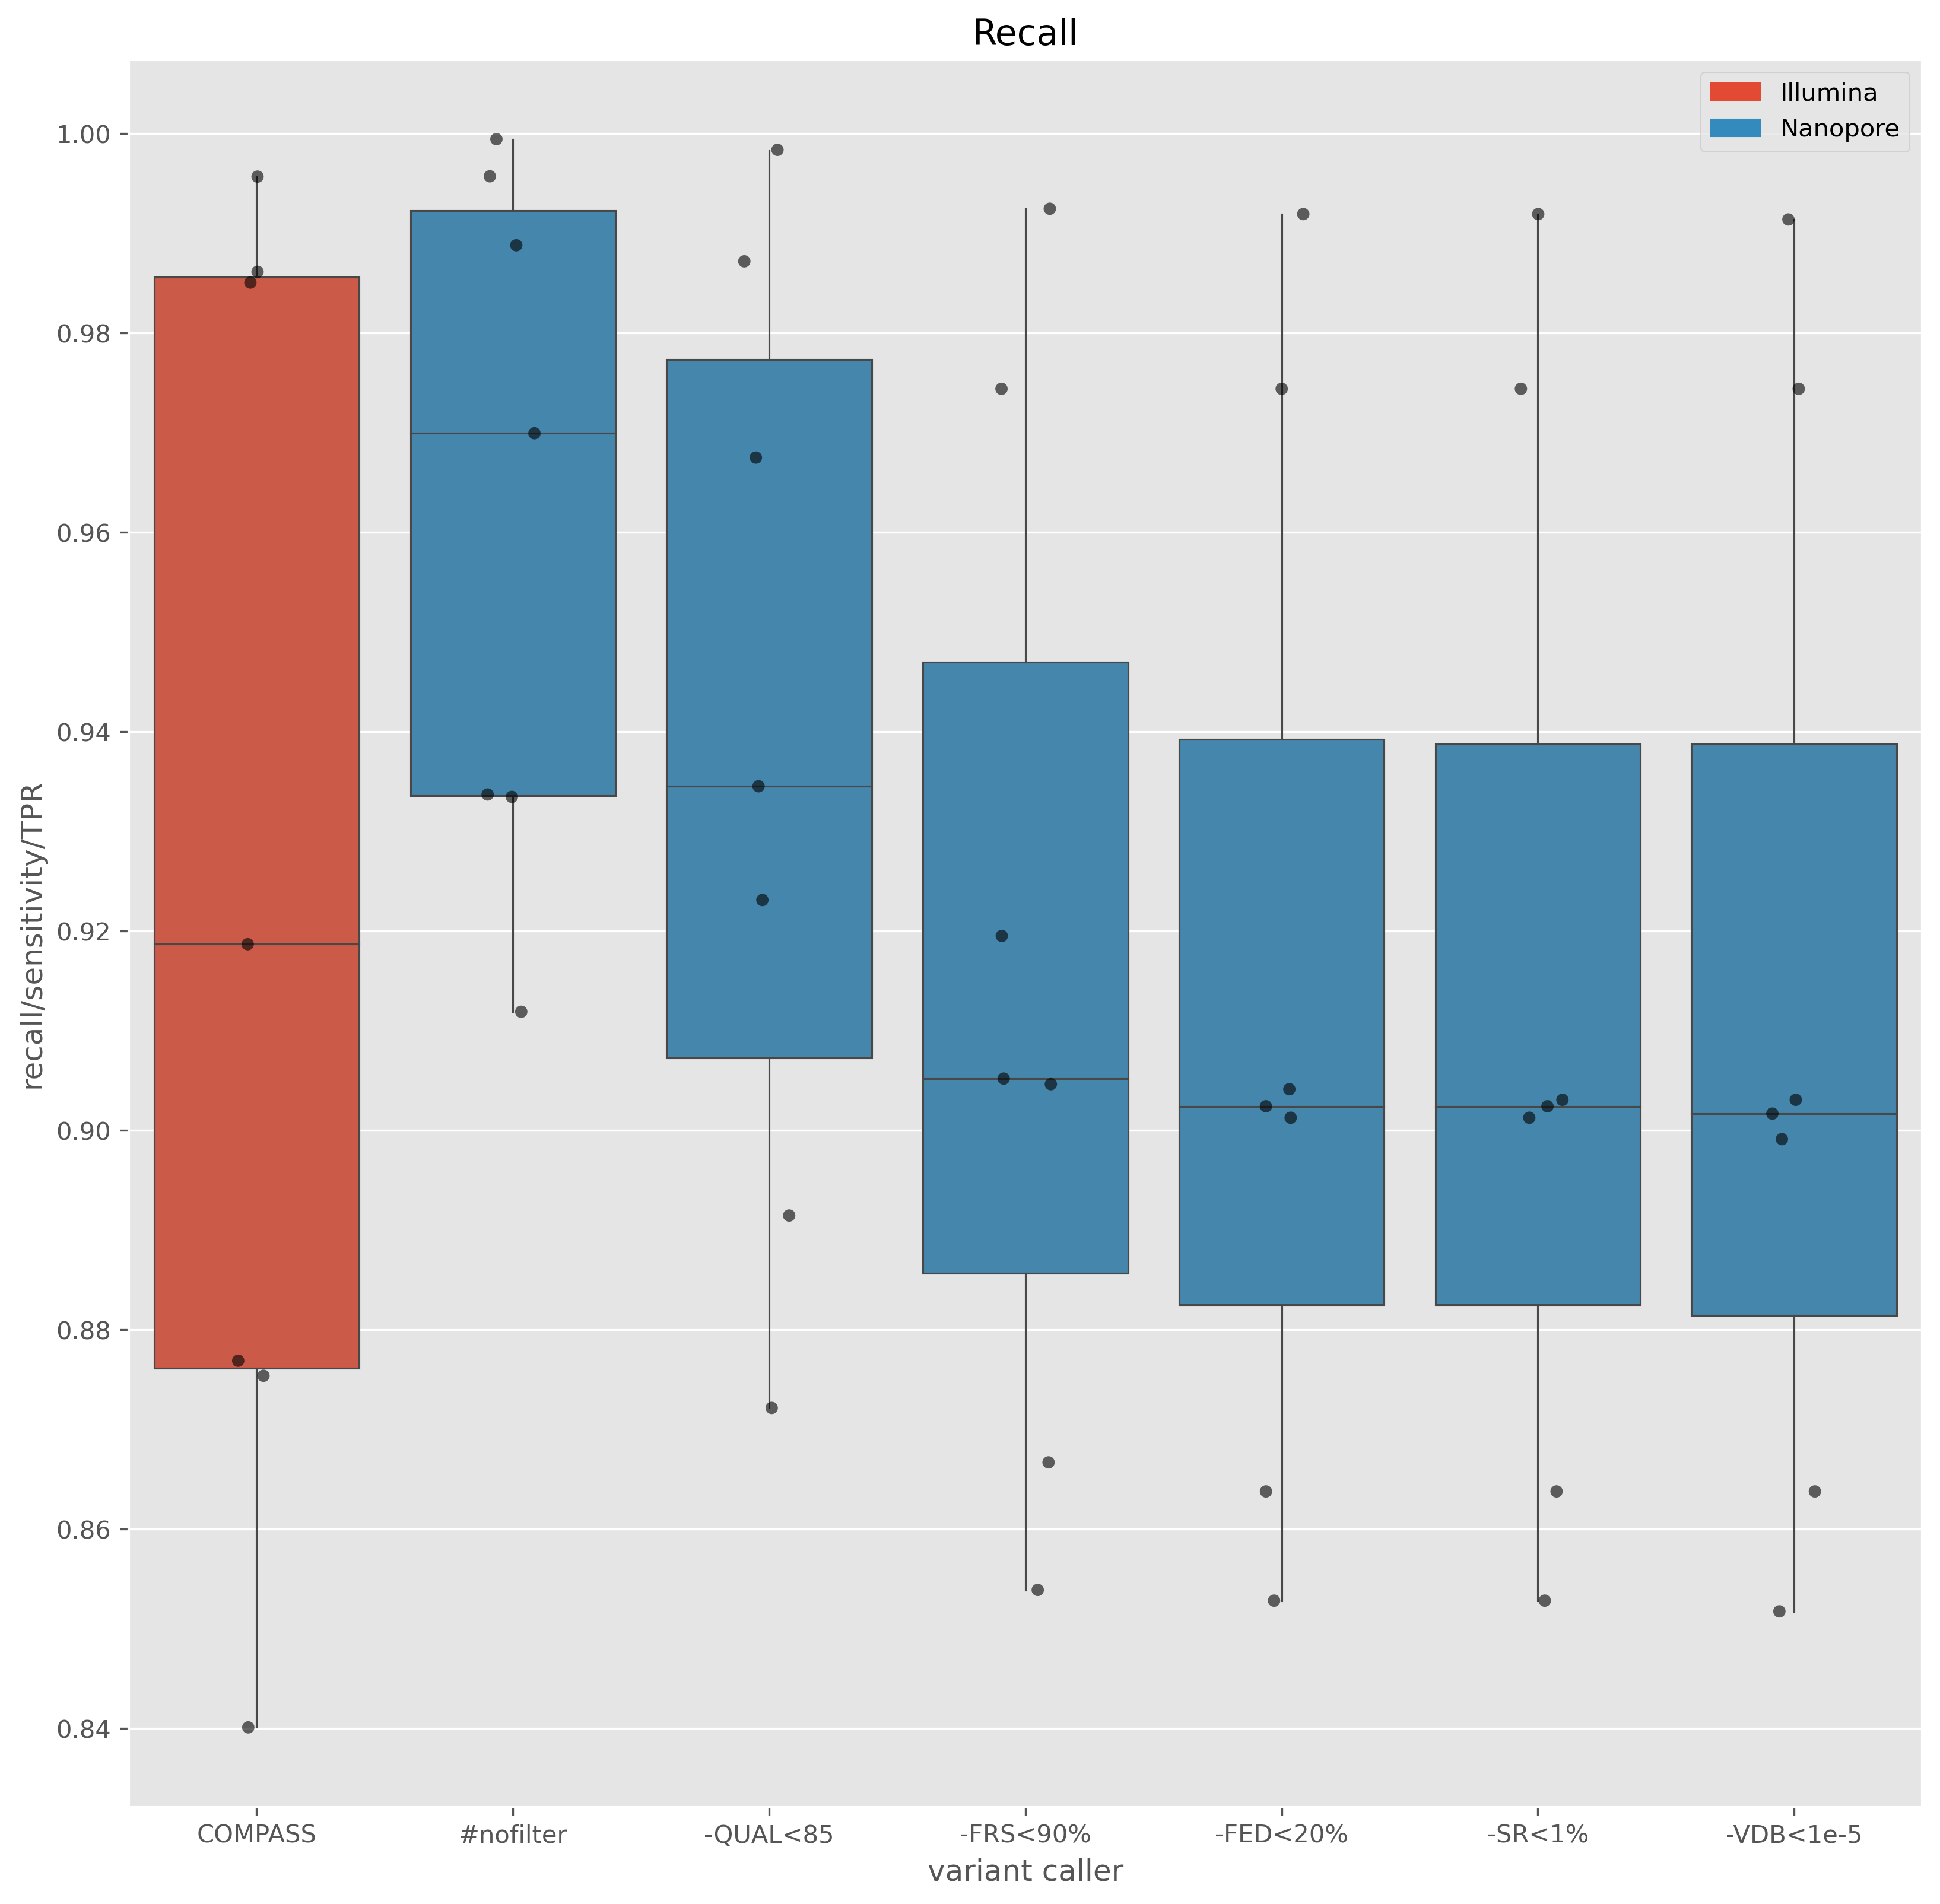

In [88]:
colours = [RED]
colours.extend([BLUE] * 6)
boxprops = dict(linewidth=0.75, fliersize=0, showcaps=False, palette=colours)
stripprops = dict(dodge=True, color="black", alpha=0.6)
xlabels = ["COMPASS", "#nofilter", "-QUAL<85", "-FRS<90%", "-FED<20%", "-SR<1%", "-VDB<1e-5"]

x = "tool"
y = "recall"
hue = "technology"
fixed_labels = ["compass", "unfiltered"]
order = [*fixed_labels, *[label for label in sorted(df[x].unique()) if label not in fixed_labels]]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
ax.set(title=y.capitalize(), xlabel="variant caller")
ax.set_ylabel("recall/sensitivity/TPR")
_ = ax.set_xticklabels(xlabels)
# ax.set_xticklabels(["COMPASS", "bcftools-ONT", "pandora-ONT"])
# ax.set(ylim=(0.70, 0.95))
# _ = plt.xticks(rotation=90)
# plt.legend(loc='lower left')
# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
# ax.get_legend().remove()
# fig.savefig(snakemake.output.recall_plot)
red_patch = mpatches.Patch(color=RED, label="Illumina")
blue_patch = mpatches.Patch(color=BLUE, label="Nanopore")
_ = ax.legend(handles=[red_patch, blue_patch], loc="best")

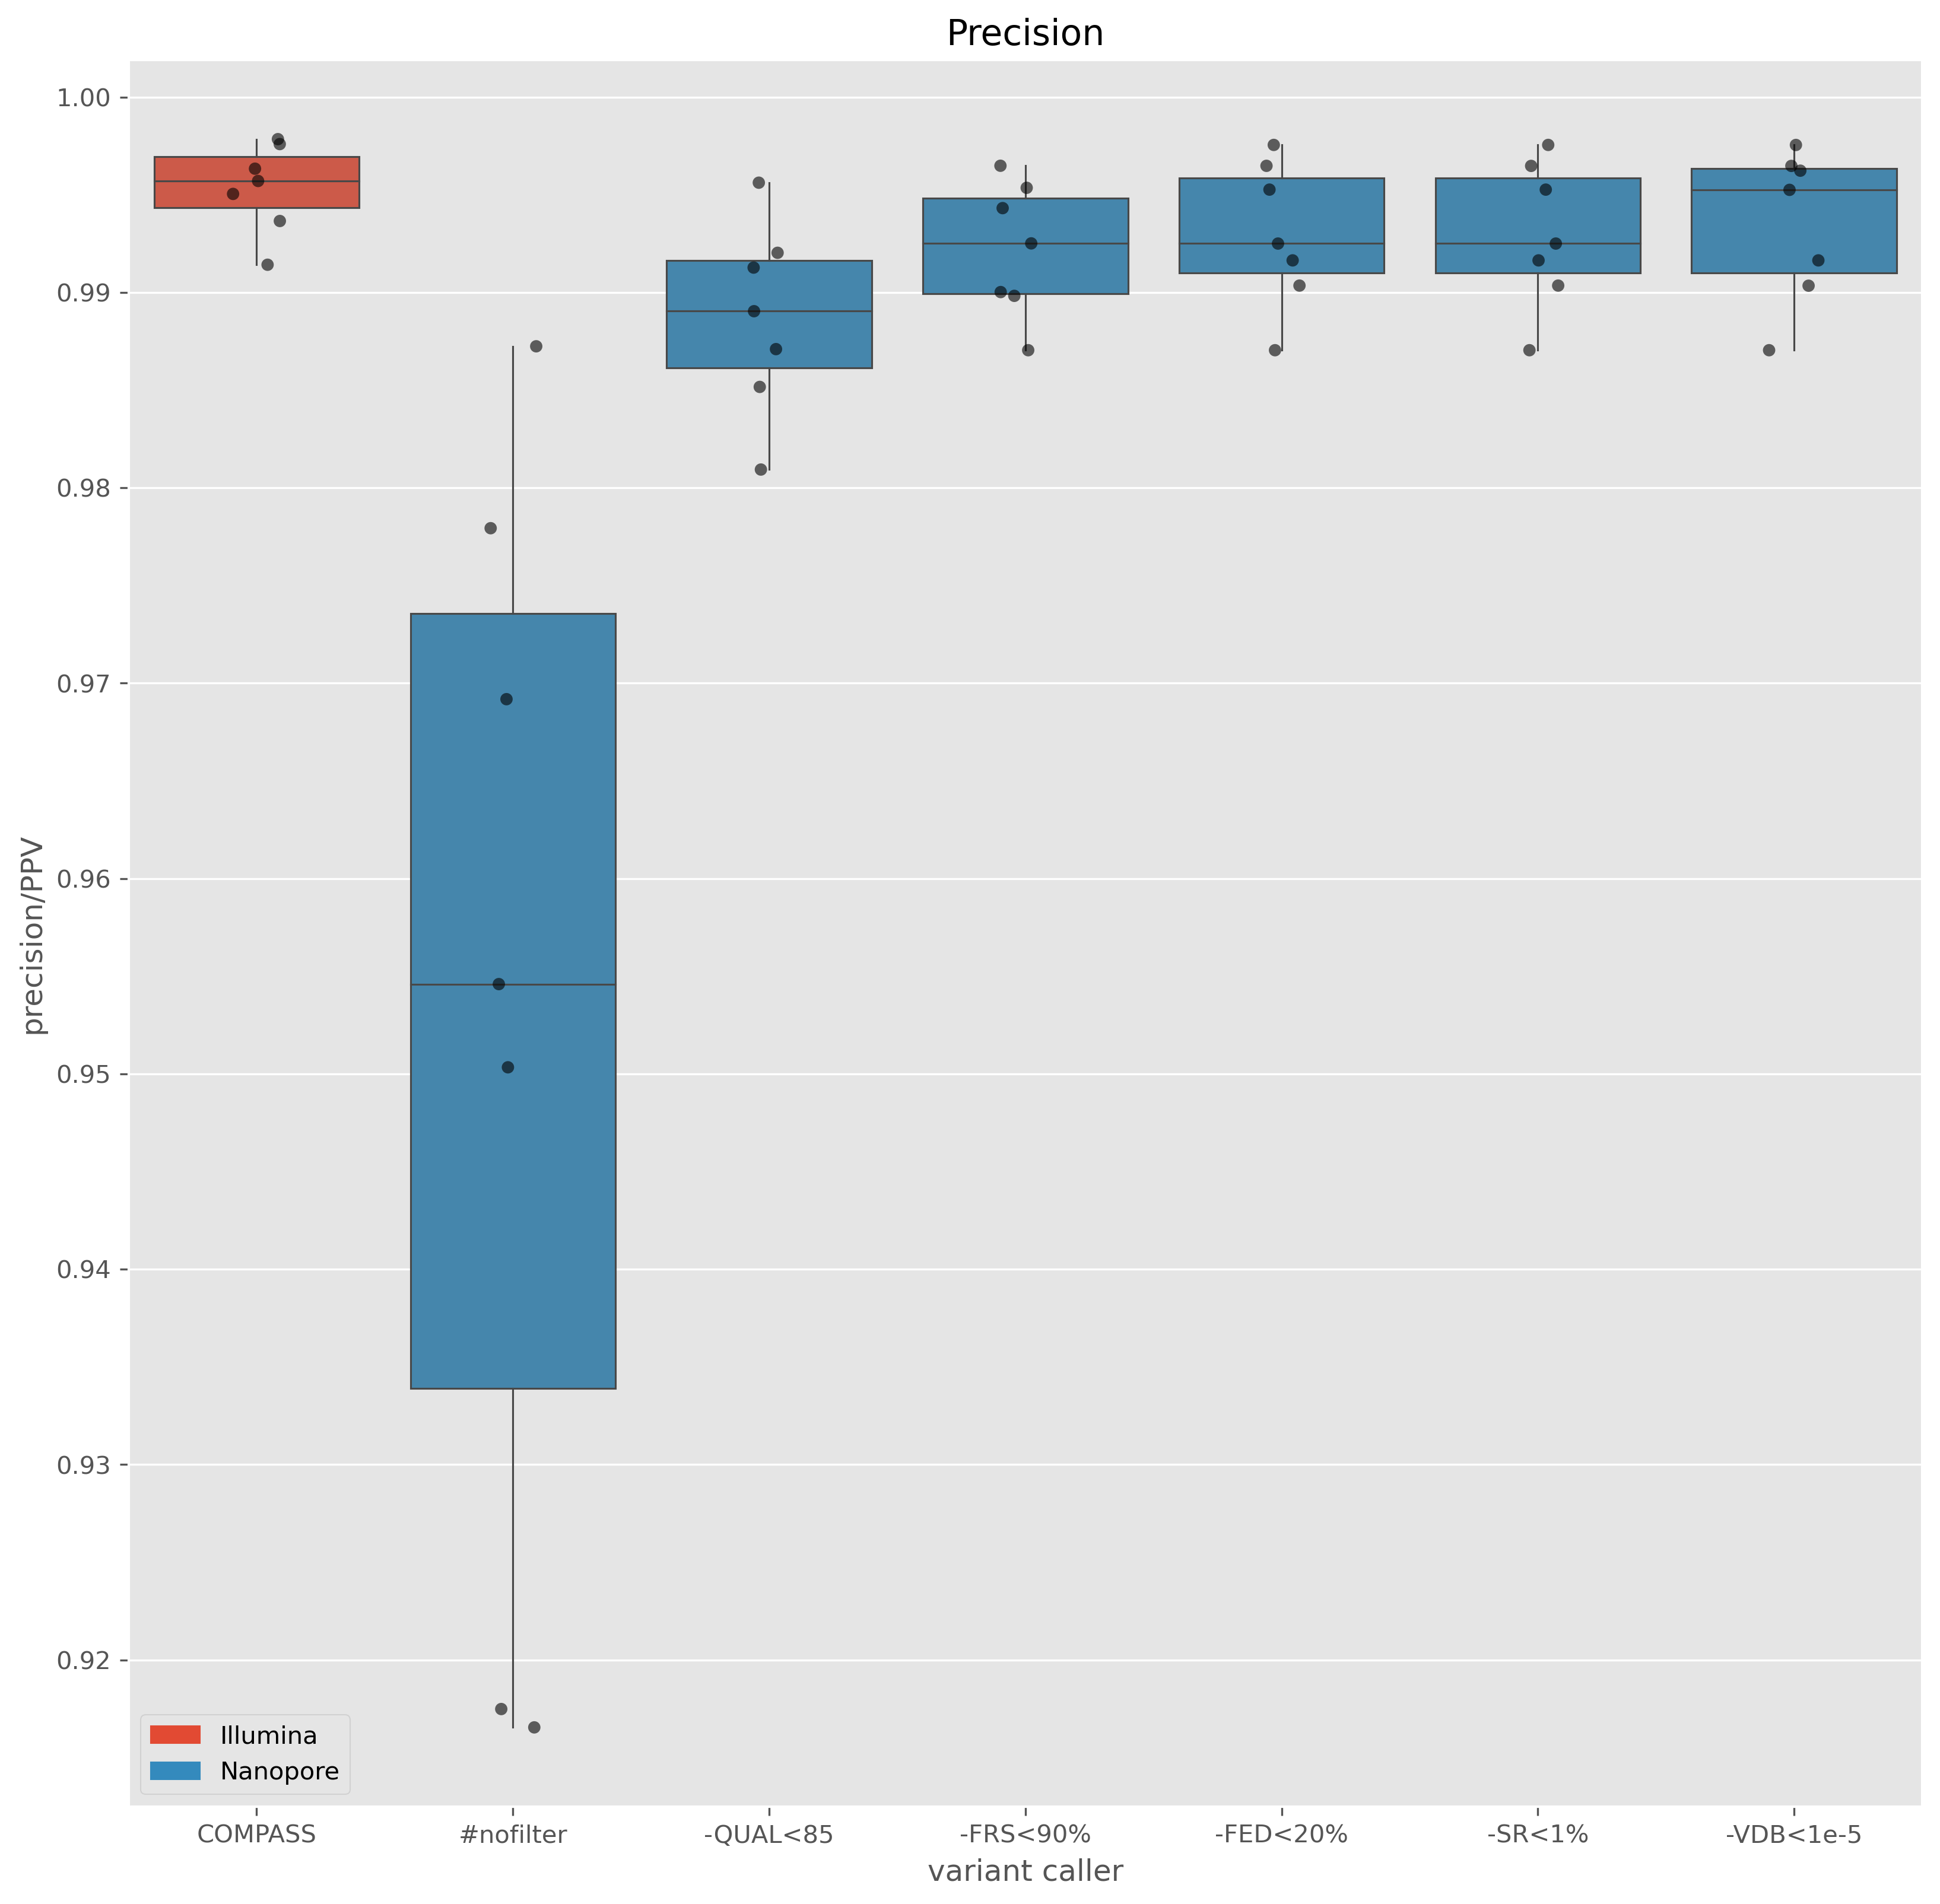

In [89]:
y = "precision"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
ax.set(title=y.capitalize(), xlabel="variant caller")
ax.set_ylabel("precision/PPV")
# ax.set_xticklabels(["COMPASS", "bcftools-ONT", "pandora-ONT"])
# ax.set(ylim=(0.995, 1.001))
# _ = plt.xticks(rotation=90)
# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)
_ = ax.set_xticklabels(xlabels)
red_patch = mpatches.Patch(color=RED, label="Illumina")
blue_patch = mpatches.Patch(color=BLUE, label="Nanopore")
_ = ax.legend(handles=[red_patch, blue_patch], loc="best")

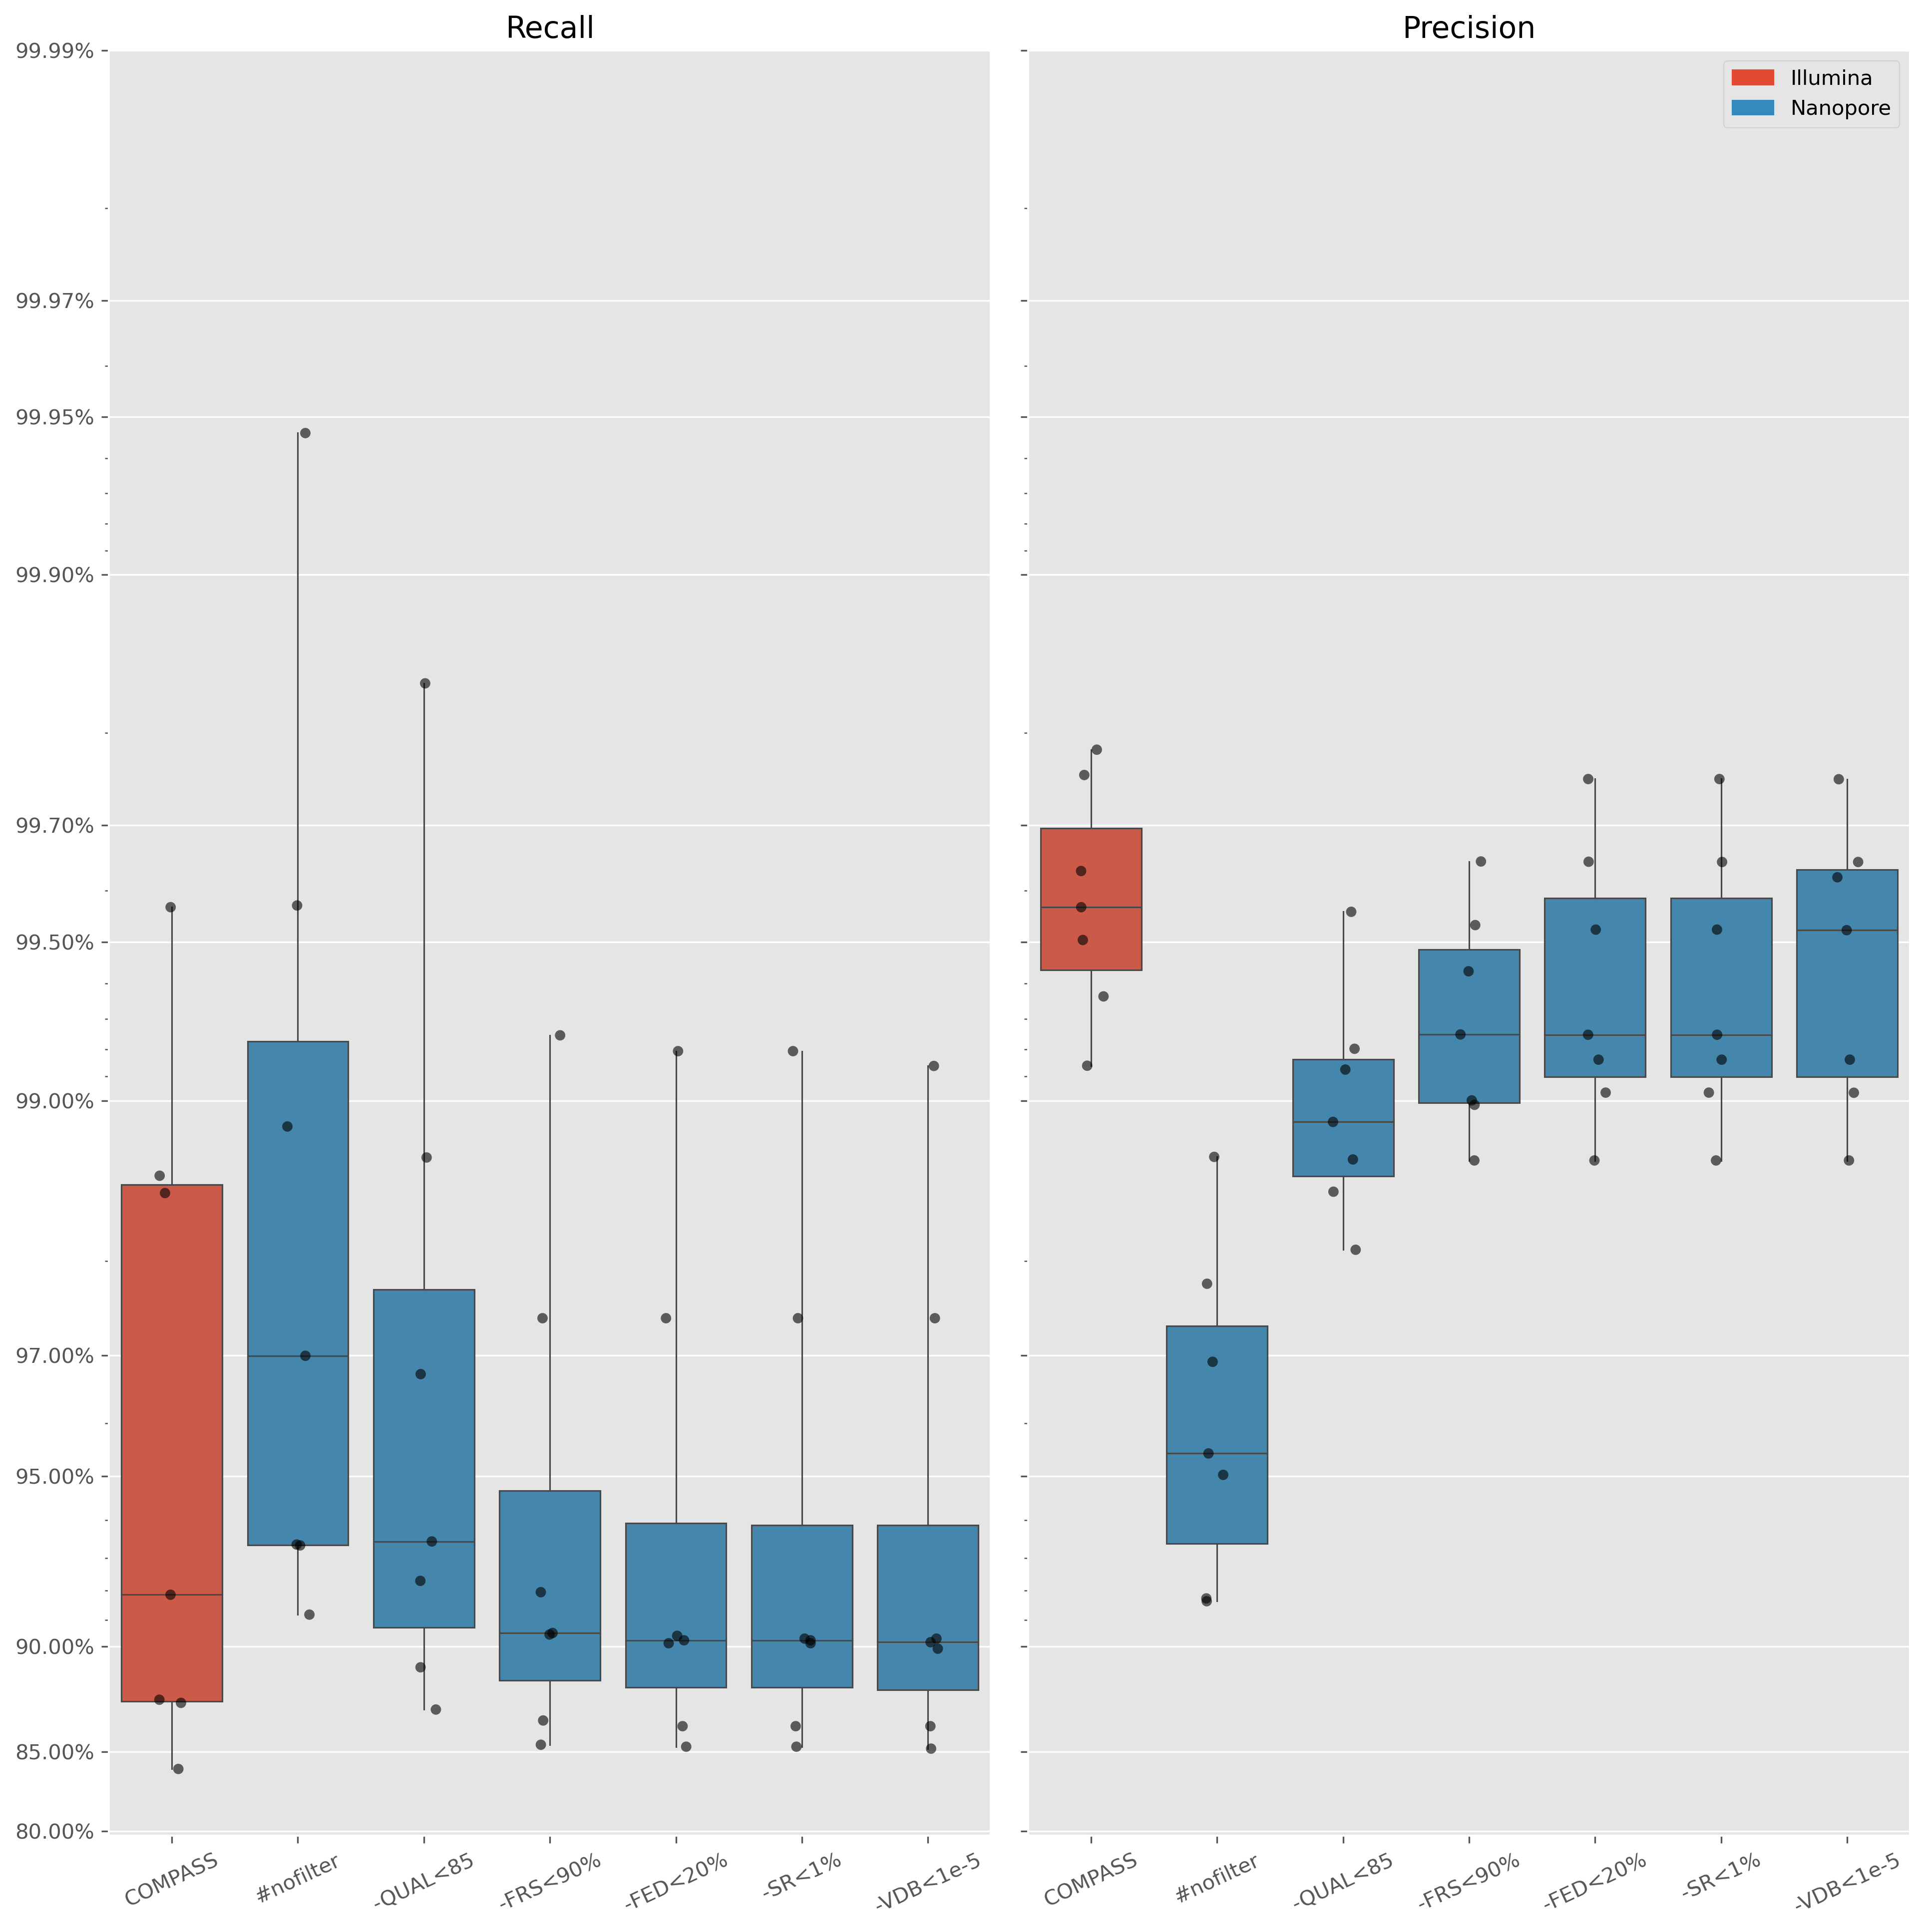

In [90]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI, sharey=True, sharex=True)
for ax, y in zip(axes.flatten(), ["recall", "precision"]):
    sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
    sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
    ax.set(title=y.capitalize(), xlabel="", ylabel="")
    ax.set_xlabel("")
#     leghandles, leglabels = ax.get_legend_handles_labels()
#     ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
#     if y == "precision":
#         ax.set_ylim(ymin=0.98)
    ax.tick_params("x", labelrotation=25)
    ax.set_yscale("logit")
    ylabs = [0.80, 0.85, 0.9, 0.95, 0.97, 0.99, 0.995, 0.997, 0.999, 0.9995, 0.9997, 0.9999]
    ax.set_yticks(ylabs)
    ax.set_yticklabels(ylabs)
    _ = ax.set_xticklabels(xlabels)
#     ax.set_xticklabels(["COMPASS", "#nofilter", "QUAL", "+RPB+VDB+SGB", "+FRS"])
    # plt.legend(loc='lower left')
    # fig.savefig(snakemake.output.recall_plot)
# ax.get_legend().remove()
axes.flatten()[0].yaxis.set_major_formatter(PercentFormatter(1.0, decimals=2))
red_patch = mpatches.Patch(color=RED, label="Illumina")
blue_patch = mpatches.Patch(color=BLUE, label="Nanopore")
_ = ax.legend(handles=[red_patch, blue_patch], loc="best")
fig.tight_layout()
# plt.xlabel("variant caller", x=0, ha="center")

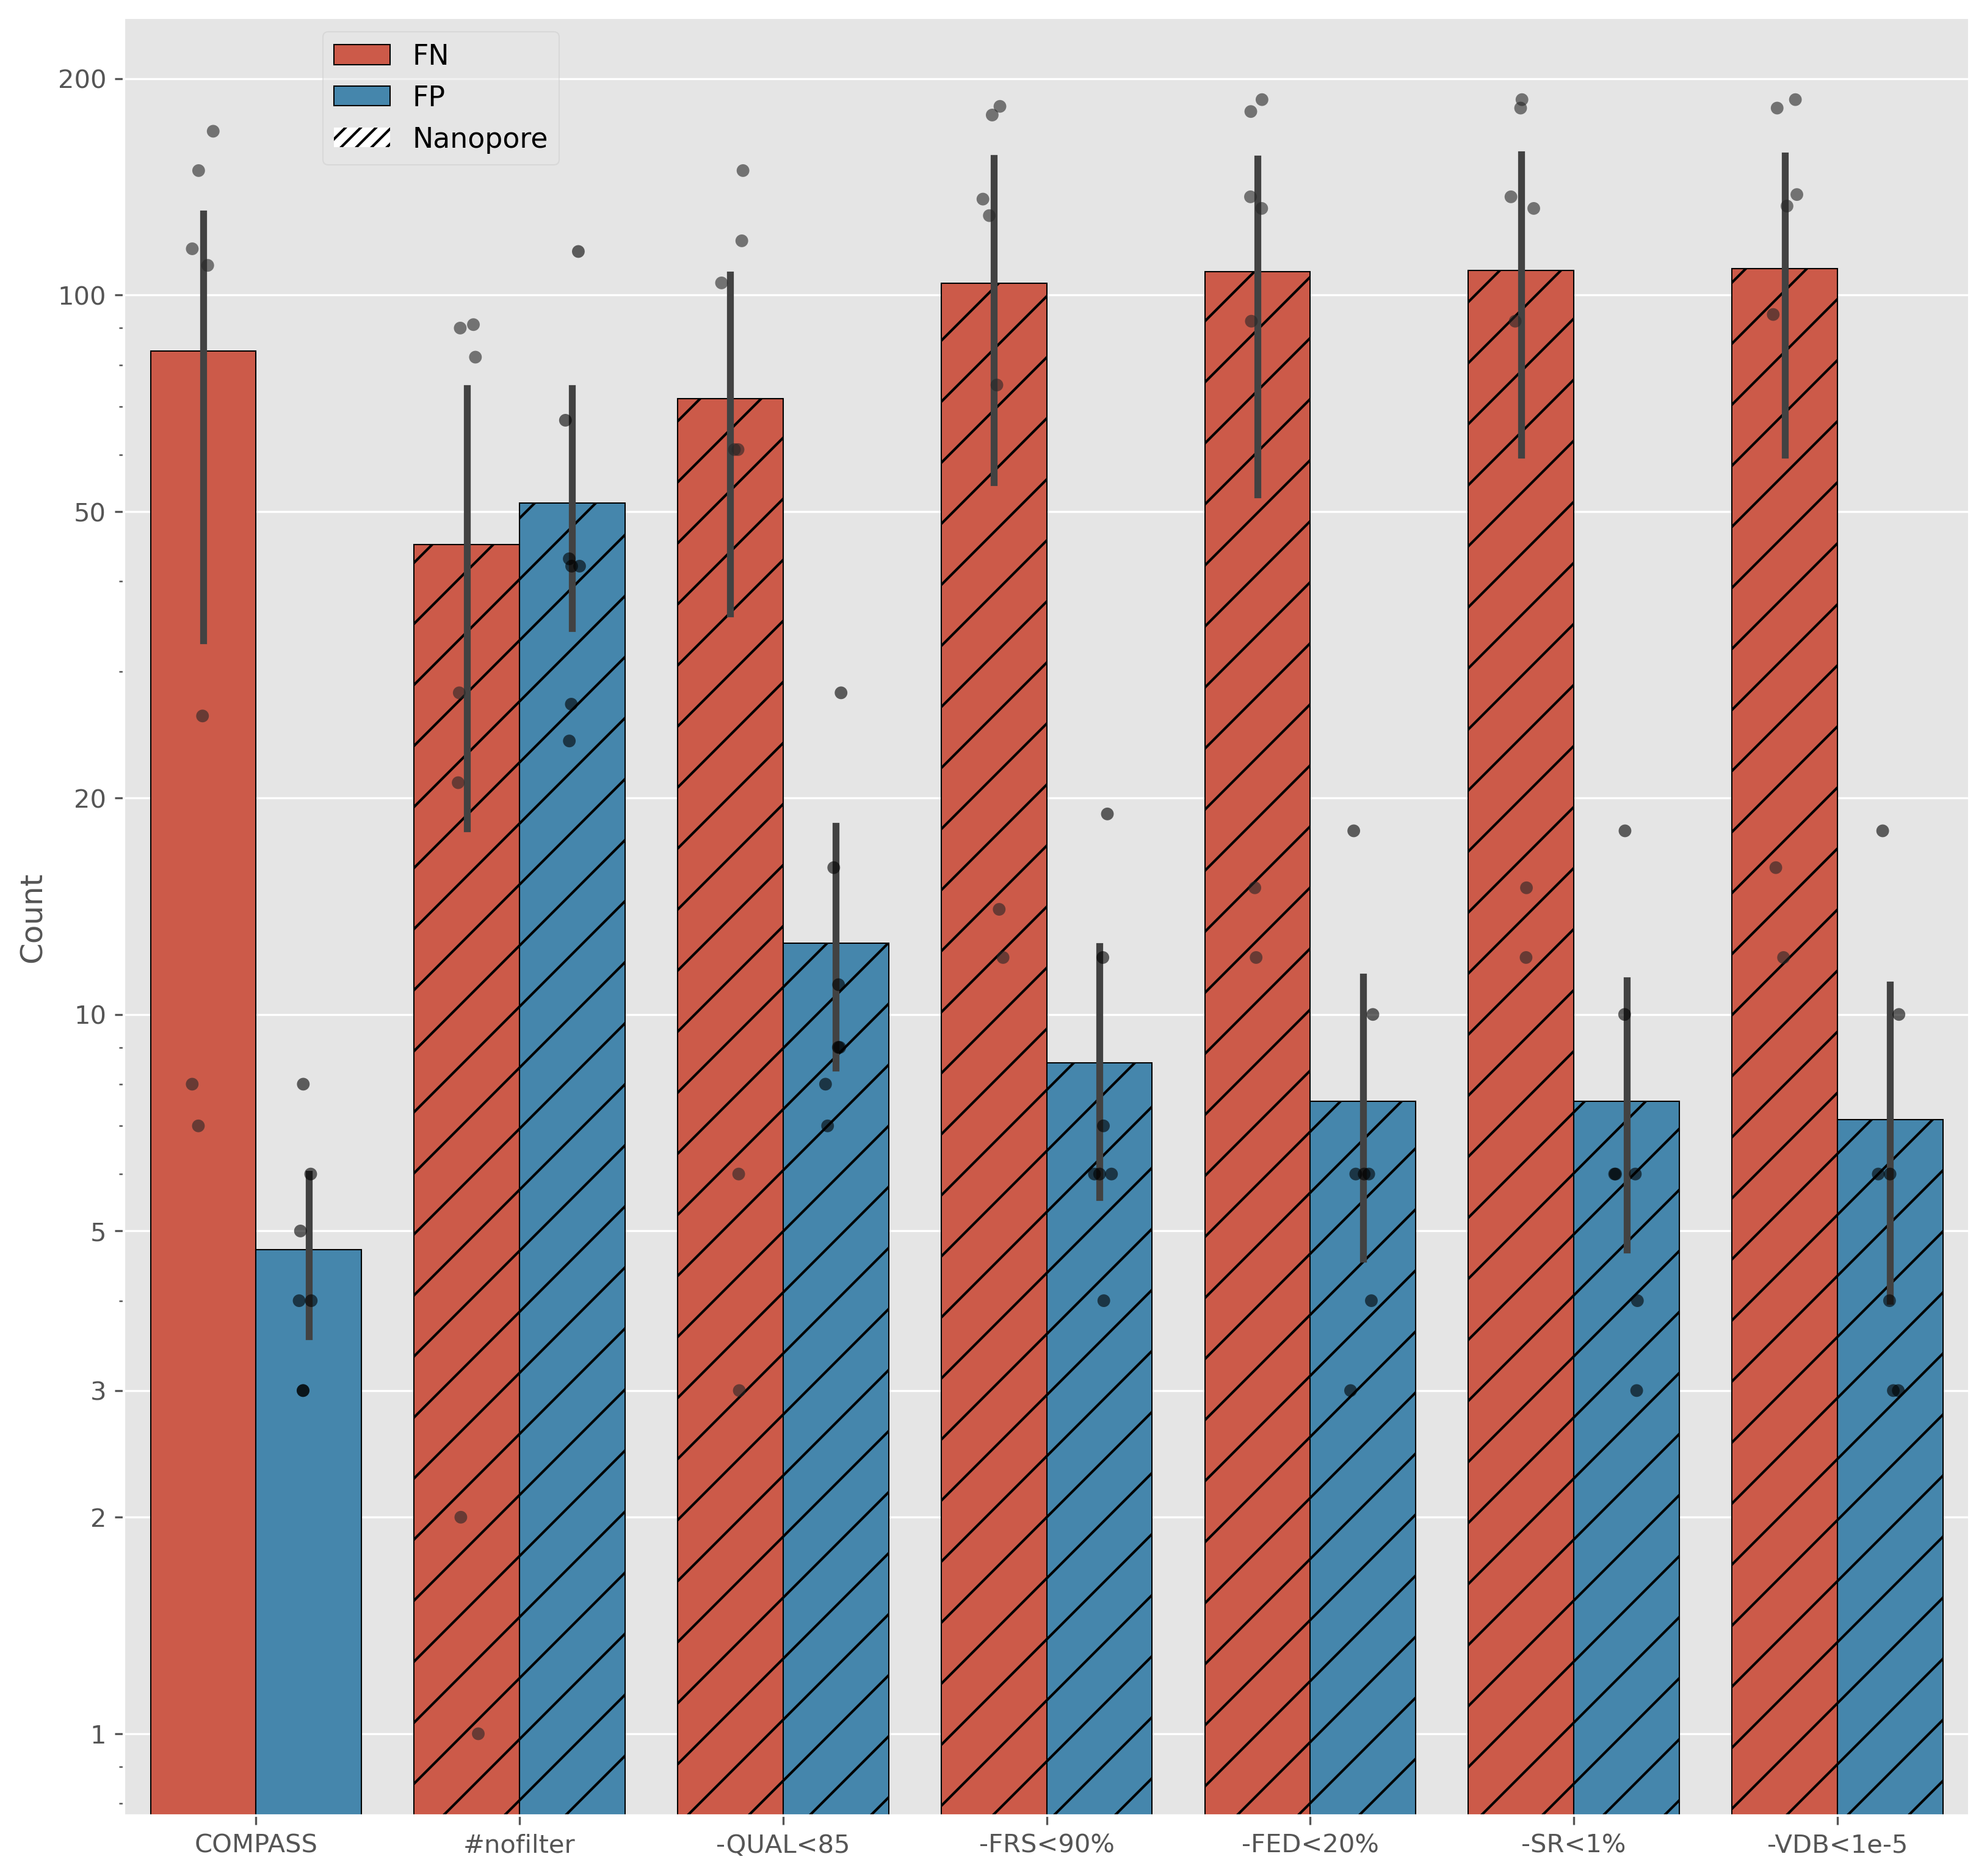

In [92]:
d = df.melt(id_vars=["sample", "tool", "judge"]).query("variable in ('FP', 'FN')")
x = "tool"
y = "value"
hue = "variable"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.barplot(x=x, y=y, data=d, ax=ax, hue=hue, edgecolor="black", order=order)
sns.stripplot(x=x, y=y, data=d, ax=ax, hue=hue, order=order, **stripprops)
ax.set_yscale("log")
ylabs = [1, 2, 3, 5, 10, 20, 50, 100, 200]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
leghandles, leglabels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for i in range(len(leghandles)):
    h = leghandles[i]
    if type(h) == BarContainer:
        new_handles.append(h)
        new_labels.append(leglabels[i])

ax.set_xlabel("")
ax.set_ylabel("Count")
_ = ax.set_xticklabels(xlabels)
hatch = "/"
# Loop over the bars
for i, bar in enumerate(ax.patches):
    # Set a different hatch for each bar
    if i % 7 == 0:  # illumina
        continue
    bar.set_hatch(hatch)
    
hatch_leghandle = Patch(facecolor="white", hatch=hatch*4)
new_handles.append(hatch_leghandle)
new_labels.append("Nanopore")
ax.legend(new_handles, new_labels, loc="upper left", framealpha=0.5, prop={"size": 11}, bbox_to_anchor=(0.1, 1.0))

In [83]:
df.to_csv("filter-precision-recall.csv", index=False)

In [134]:
df.nlargest(5, columns=["precision"])

,sample,tool,judge,precision,recall,false_negs,fps,f1,fbeta
3,mada_104,compass,happy,0.997845,0.986155,26,4,0.991966,0.997150
5,mada_125,compass,happy,0.997592,0.918699,110,3,0.956522,0.992578
5,mada_125,q85K90x20s1,happy,0.997549,0.902439,132,3,0.947614,0.991403
5,mada_125,q85K90x20,happy,0.997549,0.902439,132,3,0.947614,0.991403
3,mada_104,q70K90V1e-8,happy,0.996495,0.908413,172,6,0.950418,0.990844


In [135]:
df.nlargest(5, columns=["recall"])

,sample,tool,judge,precision,recall,false_negs,fps,f1,fbeta
1,mada_1-44,unfiltered,happy,0.977930,0.999463,1,42,0.988579,0.979171
1,mada_1-44,q85,happy,0.985162,0.998389,3,28,0.991731,0.985930
1,mada_1-44,K80s1q60x15,happy,0.987248,0.997852,4,24,0.992521,0.987866
4,mada_132,unfiltered,happy,0.917485,0.995736,2,42,0.955010,0.921746
1,mada_1-44,compass,happy,0.995704,0.995704,8,8,0.995704,0.995704


In [95]:
df.groupby(["tool"]).describe().T

tool              compass       q85    q85K90  q85K90x20  q85K90x20s1  \
precision count  7.000000  7.000000  7.000000   7.000000     7.000000   
          mean   0.995369  0.988735  0.992220   0.992974     0.992973   
          std    0.002265  0.004848  0.003413   0.003709     0.003708   
          min    0.991416  0.980932  0.987041   0.987041     0.987041   
          25%    0.994348  0.986129  0.989920   0.990994     0.990994   
          50%    0.995704  0.989038  0.992509   0.992500     0.992500   
          75%    0.996962  0.991648  0.994834   0.995870     0.995868   
          max    0.997845  0.995616  0.996483   0.997549     0.997549   
recall    count  7.000000  7.000000  7.000000   7.000000     7.000000   
          mean   0.925440  0.939208  0.916705   0.912984     0.912832   
          std    0.063720  0.047712  0.051313   0.052233     0.052265   
          min    0.840129  0.872180  0.853921   0.852846     0.852846   
          25%    0.876158  0.907307  0.885686   0.882545     0.882545   
          50%    0.918699  0.934549  0.905218   0.902439     0.902439   
          75%    0.985615  0.977363  0.946971   0.939283     0.938751   
          max    0.995704  0.998389  0.992481   0.991944     0.991944   
f1        count  7.000000  7.000000  7.000000   7.000000     7.000000   
          mean   0.958157  0.962767  0.952299   0.950596     0.950512   
          std    0.034381  0.024628  0.026855   0.027183     0.027193   
          min    0.910465  0.926941  0.918014   0.917389     0.917389   
          25%    0.932105  0.946422  0.935820   0.934631     0.934631   
          50%    0.956522  0.962431  0.948661   0.947614     0.947486   
          75%    0.990101  0.982713  0.968314   0.964380     0.964150   
          max    0.995704  0.991731  0.991150   0.991146     0.991146   
fbeta     count  7.000000  7.000000  7.000000   7.000000     7.000000   
          mean   0.990726  0.985542  0.987271   0.987710     0.987699   
          std    0.004935  0.004801  0.003627   0.003573     0.003563   
          min    0.983087  0.980908  0.981801   0.983031     0.983031   
          25%    0.987760  0.981301  0.984706   0.984685     0.984685   
          50%    0.991041  0.985930  0.988551   0.989194     0.989194   
          75%    0.994141  0.987718  0.990264   0.990486     0.990446   
          max    0.997150  0.993918  0.990608   0.991403     0.991403   

tool             q85K90x20s1V1e-5  unfiltered  
precision count          7.000000    7.000000  
          mean           0.993504    0.953330  
          std            0.003892    0.027853  
          min            0.987041    0.916546  
          25%            0.990991    0.933909  
          50%            0.995249    0.954593  
          75%            0.996353    0.973554  
          max            0.997547    0.987241  
recall    count          7.000000    7.000000  
          mean           0.912189    0.961871  
          std            0.052444    0.035225  
          min            0.851772    0.911923  
          25%            0.881472    0.933601  
          50%            0.901700    0.969957  
          75%            0.938751    0.992277  
          max            0.991407    0.999463  
f1        count          7.000000    7.000000  
          mean           0.950383    0.957200  
          std            0.026977    0.024308  
          min            0.918356    0.924936  
          25%            0.934037    0.940816  
          50%            0.947205    0.955010  
          75%            0.964087    0.975121  
          max            0.990875    0.988579  
fbeta     count          7.000000    7.000000  
          mean           0.988142    0.953744  
          std            0.002990    0.026689  
          min            0.983081    0.917525  
          25%            0.986340    0.935543  
          50%            0.989030    0.955483  
          75%            0.990428    0.972391  
          max            0.991348    0.987334

In [14]:
class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1

    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)

@dataclass
class StrandDepths:
    ref_forward: int = 0
    ref_reverse: int = 0
    alt_forward: int = 0
    alt_reverse: int = 0

    @staticmethod
    def _ratio(depths: Tuple[int, int]) -> float:
        try:
            return min(depths) / sum(depths)
        except ZeroDivisionError:
            return 0.5

    @property
    def ref_depths(self) -> Tuple[int, int]:
        return self.ref_forward, self.ref_reverse

    @property
    def alt_depths(self) -> Tuple[int, int]:
        return self.alt_forward, self.alt_reverse

    @property
    def ref_ratio(self) -> float:
        return self._ratio(self.ref_depths)

    @property
    def alt_ratio(self) -> float:
        return self._ratio(self.alt_depths)

    def to_tuple(self) -> Tuple[int, int, int, int]:
        return self.ref_forward, self.ref_reverse, self.alt_forward, self.alt_reverse

def fraction_read_support(variant) -> float:
    strand_depths = get_strand_depths(variant)
    if strand_depths is None:
        return 1.0
    total_covg = sum(strand_depths.to_tuple())
    called_idx = Genotype.from_arr(variant.genotypes[0]).allele_index()
    if called_idx == 0:  # ref
        called_covg = sum(strand_depths.ref_depths)
    else:
        called_covg = sum(strand_depths.alt_depths)
    try:
        return called_covg / total_covg
    except ZeroDivisionError:
        return 1.0
    
def fraction_expected_depth(variant, expected_depth) -> Tuple[float, float]:
    fed = variant.INFO["DP"] / expected_depth
    strand_depths = get_strand_depths(variant)
    i = Genotype.from_arr(variant.genotypes[0]).allele_index()
    if i == 0:
        hqdp = sum(strand_depths.ref_depths)
    else:
        hqdp = sum(strand_depths.alt_depths)
    return fed, hqdp/expected_depth
    
    
    
    
def get_strand_depths(
    variant, default = None
) -> StrandDepths:
    strand_depths = variant.INFO.get("DP4", None)
    return StrandDepths(*strand_depths) if strand_depths is not None else default

def strand_bias(variant) -> float:
        strand_depths = get_strand_depths(variant)
        assert strand_depths is not None, (
            f"Strand bias filter should be turned off if no DP4 "
            f"tag is present."
        )

        gt = Genotype.from_arr(variant.genotypes[0])
        if gt.is_hom_alt():
            ratio = strand_depths.alt_ratio
        elif gt.is_hom_ref():
            ratio = strand_depths.ref_ratio
        elif gt.is_het():
            ratio = min(strand_depths.ref_ratio, strand_depths.alt_ratio)
        elif gt.is_null():
            ratio = 0.5
        else:
            raise NotImplementedError(
                f"Don't know how to interpret genotype {gt} for variant at "
                f"POS {variant.POS}"
            )
        return ratio

In [15]:
clf_vcfs = sorted(Path("bcftools-q85K90x20s1V1e-5/").rglob("*.bcf"))
query_vcfs = sorted(Path("vcfs/bcftools/unfiltered/").rglob("*.bcf"))

In [16]:
info = ["BQBZ", "DP", "FS", "MQ", "MQ0F", "RPBZ", "SCBZ", "SGB", "VDB", "MQBZ"]

In [18]:
# median_covgs = {}
# for p in query_vcfs:
#     sample = p.name.split(".")[0]
#     dps = []
#     for v in VCF(p):
#         dp = v.INFO["DP"]
#         if dp is None:
#             continue
#         dps.append(dp)
#     median_covgs[sample] = np.median(dps)

In [19]:
median_covgs

{'mada_1-44': 131.0,
 'mada_102': 147.0,
 'mada_104': 37.0,
 'mada_116': 80.0,
 'mada_125': 68.0,
 'mada_130': 46.0,
 'mada_132': 30.0}

In [46]:
data = []
index_cols = ["sample", "pos"]
columns = [*index_cols, "classification", "quality", "FRS", "HQDP", "DR", "SB", "SP", "FED", "HQFED", "SCR", "SCRF"]
info = ["MQSBZ", "MQ", "VDB", "RPBZ", "SCBZ", "BQBZ", "SGB", "DP"]
columns.extend(info)
for p, qp in zip(clf_vcfs, query_vcfs):
    sample = p.parts[-3]
    qvcf = VCF(qp)
    for v in VCF(p):
        vtypes = v.format("BVT")
        ref_is_indel = vtypes[0] == "INDEL"
        if ref_is_indel:
            continue
        results = set([r for r in v.format("BD") if r != "."])
        assert len(results) == 1
        clfn = list(results)[0]
        
        qv = next(qvcf(f"{v.CHROM}:{v.POS}-{v.POS}"))
        assert qv.POS == v.POS
        
        d = [sample, v.POS, clfn, qv.QUAL]
        
        d.append(fraction_read_support(qv))

        hqdp = sum(qv.INFO["DP4"])
        d.append(hqdp)
        
        try:
            depth_ratio = hqdp / qv.INFO["DP"]
        except ZeroDivisionError:
            depth_ratio = None
        d.append(depth_ratio)
        
        sb = strand_bias(qv)
        sp = qv.format("SP")[0][0]
        d.extend([sb, sp])
        
        ed = median_covgs[sample]
        fed, hqfed = fraction_expected_depth(qv, ed)
        d.extend([fed, hqfed])
        
        scr = qv.INFO.get("SCR", 0)
        try:
            scr_frac = scr / hqdp
        except ZeroDivisionError:
            scr_frac = None
        d.extend([scr, scr_frac])
        
        for k in info:
            d.append(qv.INFO.get(k))
            
        data.append(tuple(d))

In [47]:
df = pd.DataFrame(data, columns=columns)

In [48]:
filter_out_fn = True
if filter_out_fn:
    df = df.query("classification!='FN'")

In [145]:
print(len(df.query("quality<100 and classification=='TP'")))
print(len(df.query("quality<100 and classification=='FP'")))

25
0


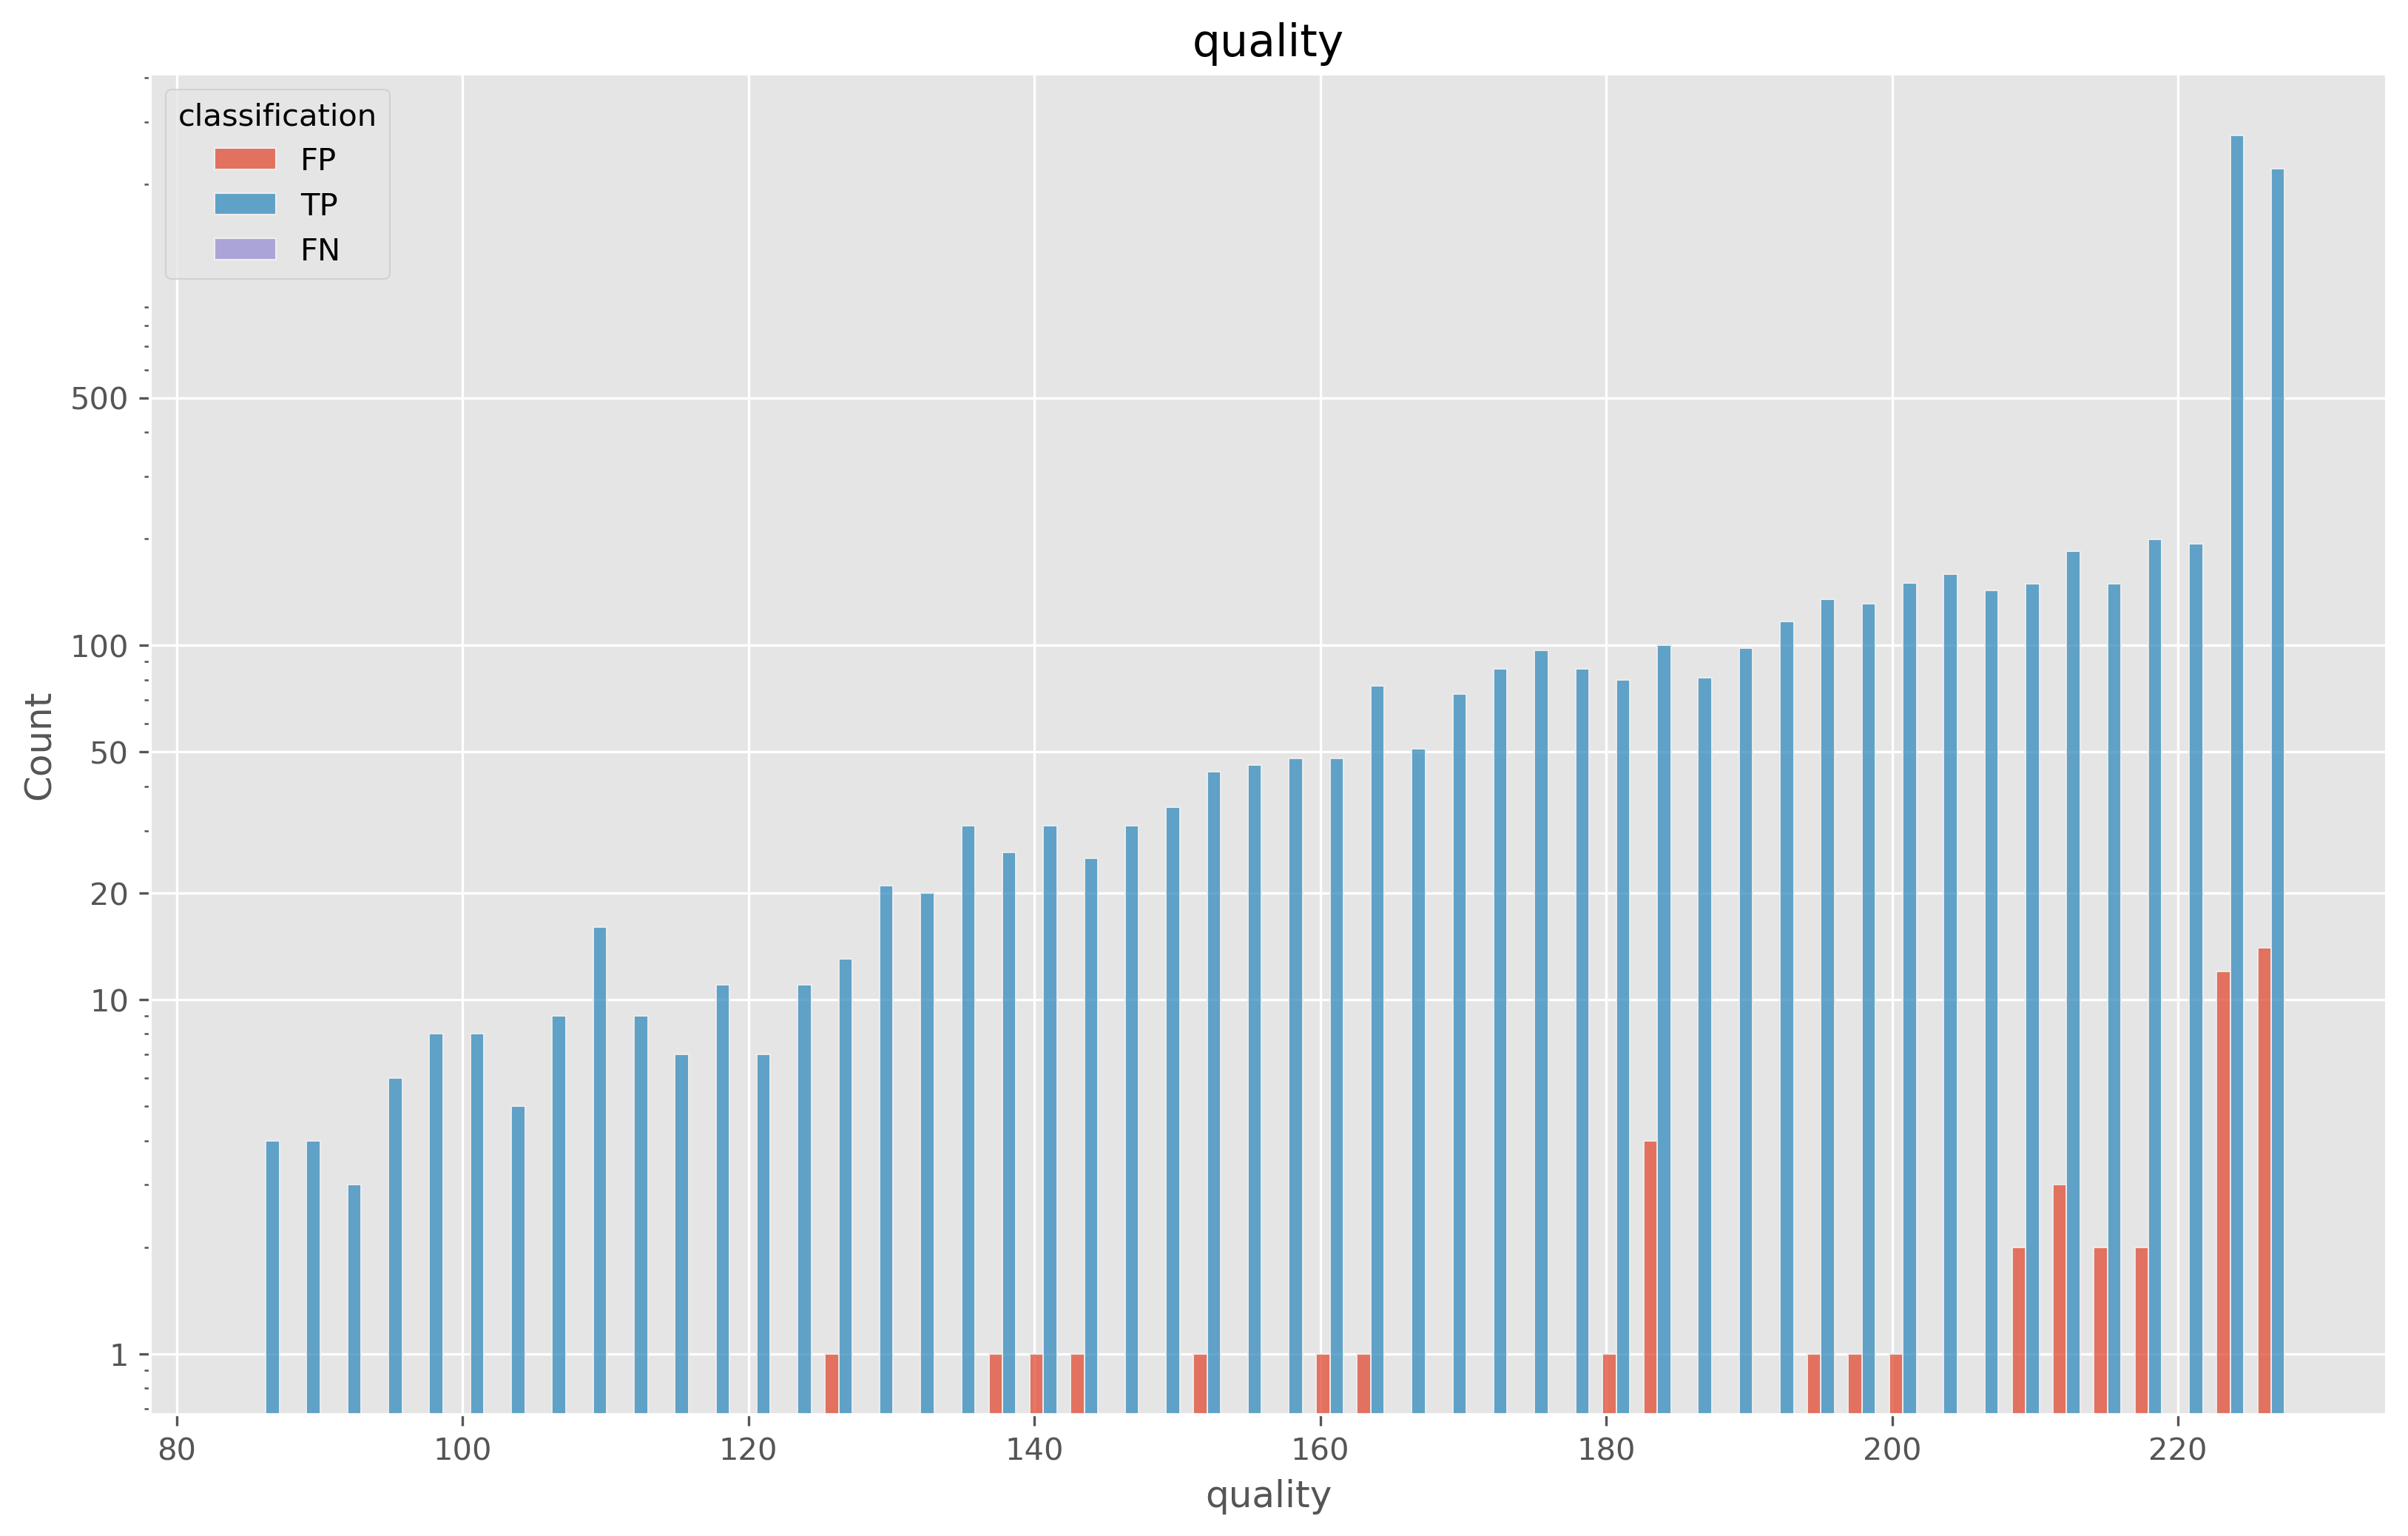

In [23]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "quality"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# xlabs = [60, 65, 70, 75, 80, 85, 90, 95, 100]
# ax.set_xticks(xlabs)
# ax.set_xticklabels(xlabs)
# ax.set_xlim((0, 110))
_=ax.set_title(x)

In [147]:
print(len(df.query("FRS<0.85 and classification=='TP'")))
print(len(df.query("FRS<0.85 and classification=='FP'")))

0
0


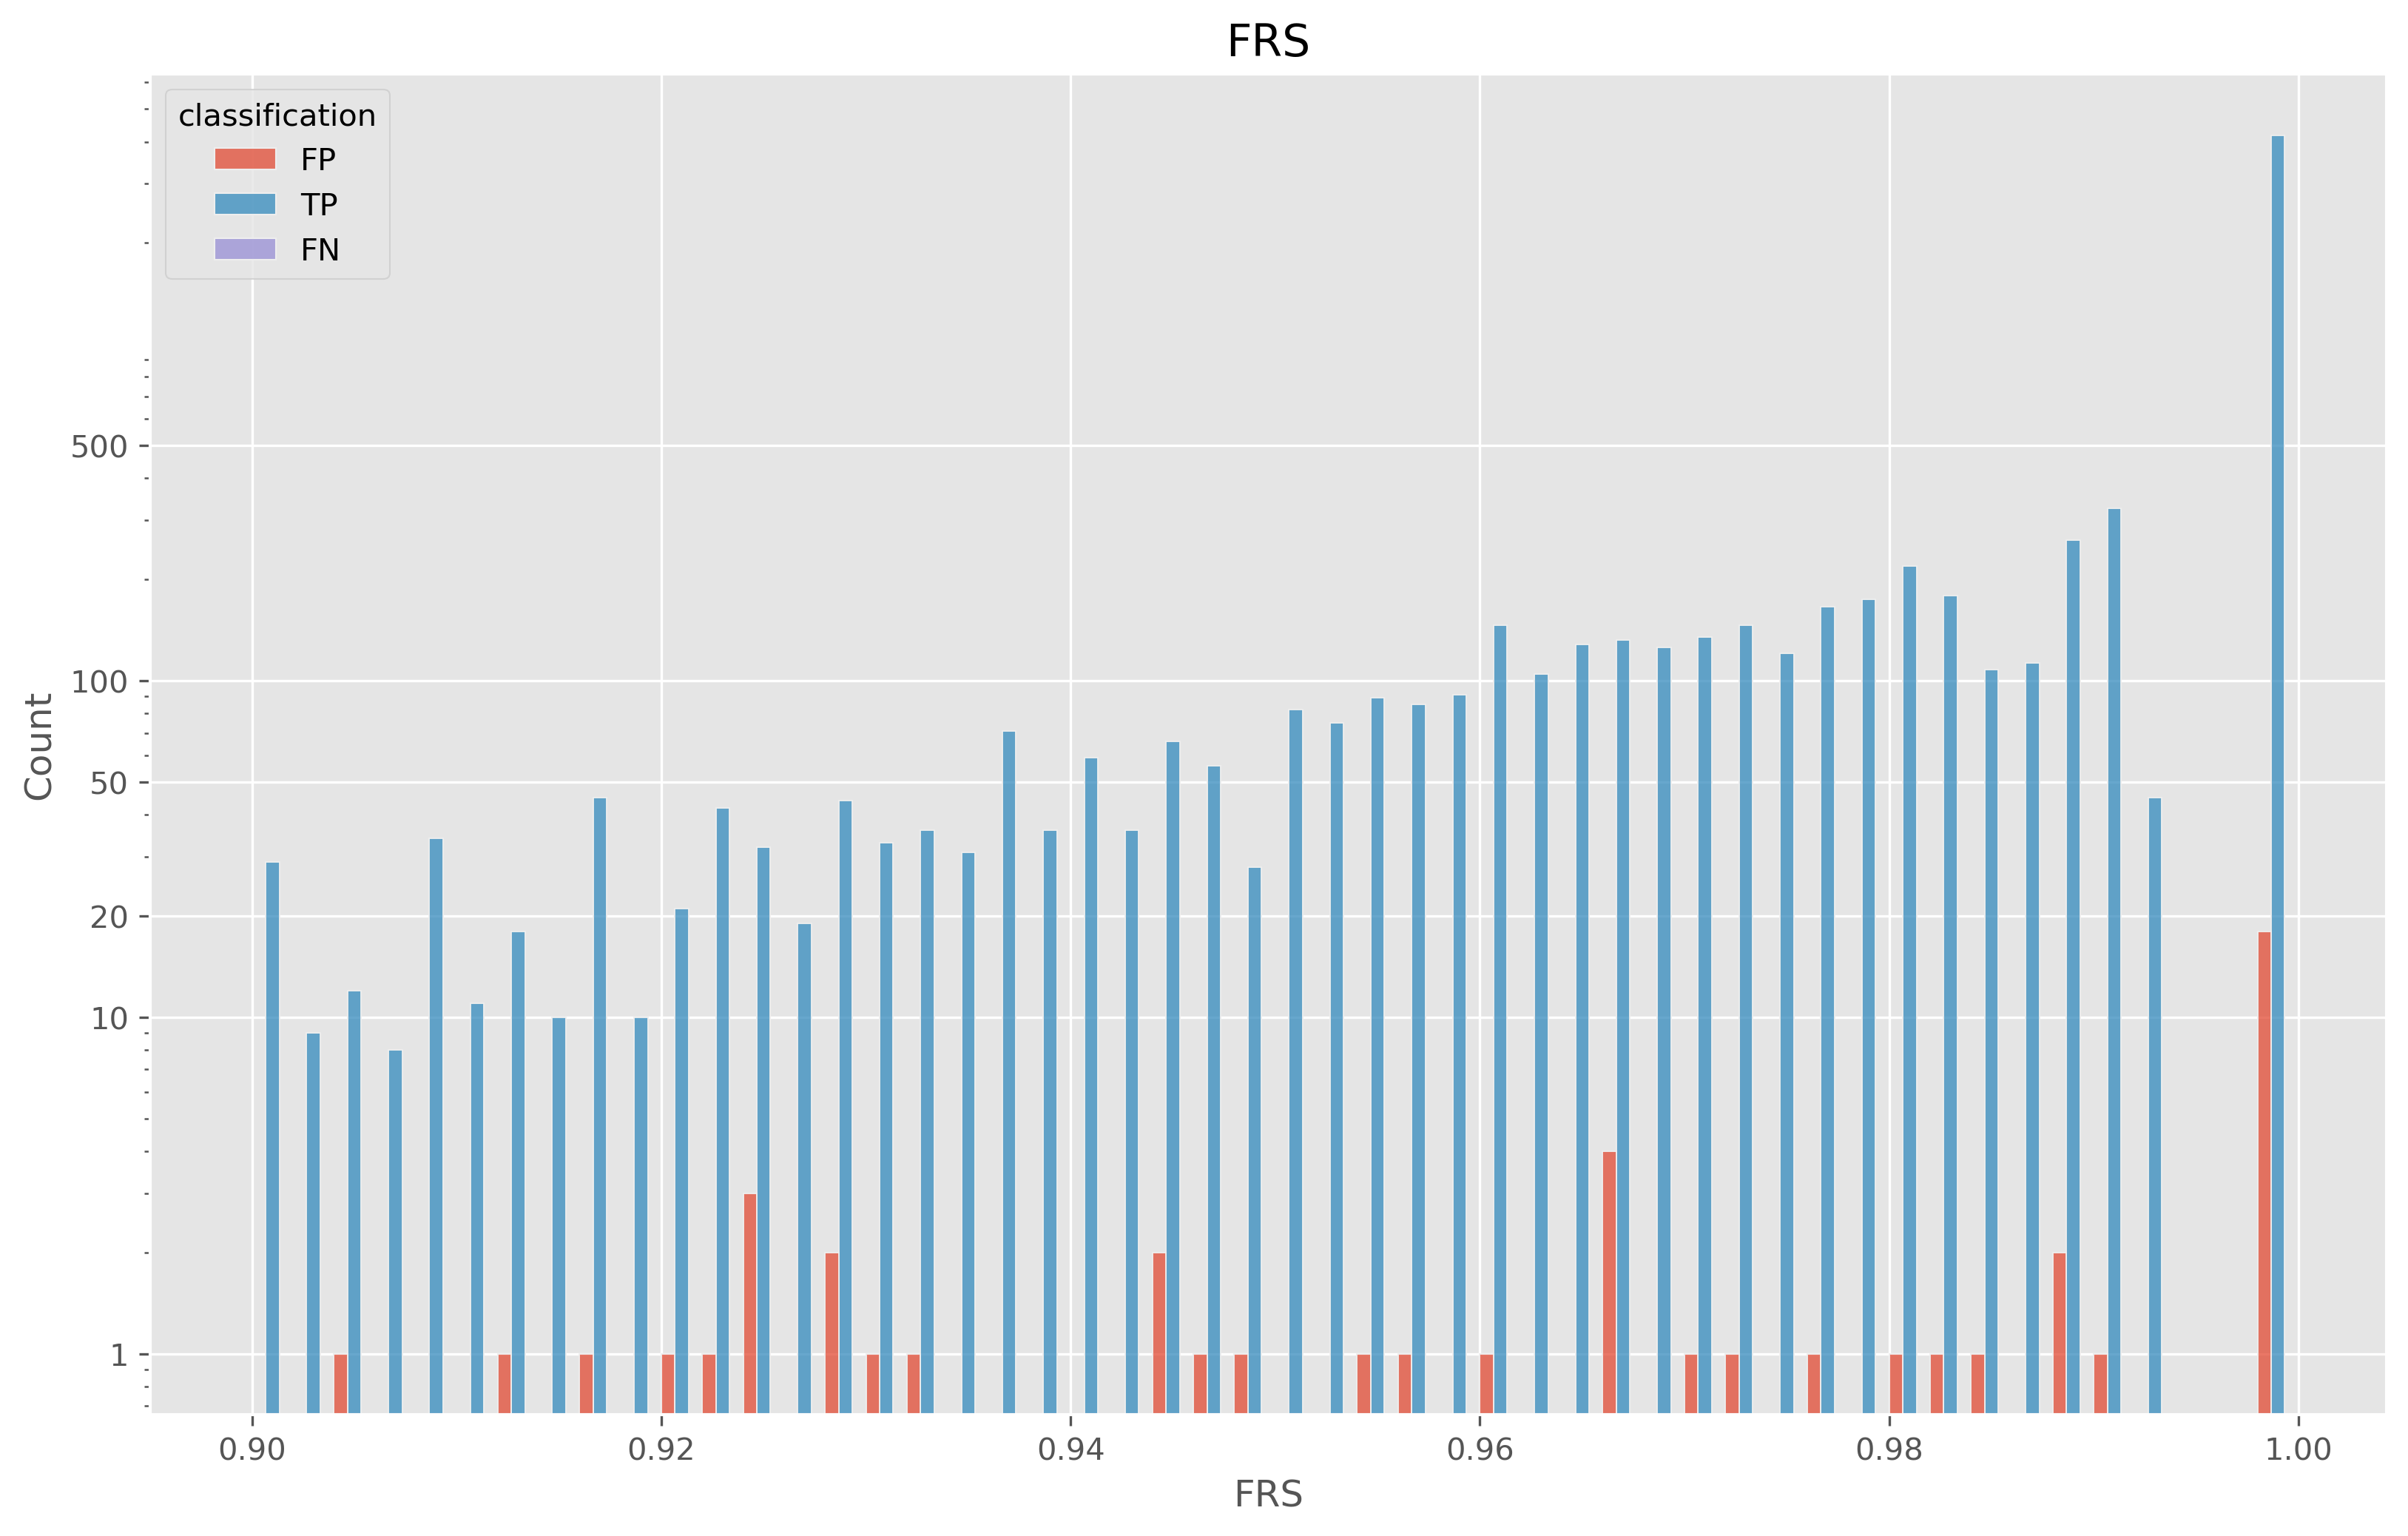

In [24]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "FRS"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# xlabs = [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# ax.set_xticks(xlabs)
# ax.set_xticklabels(xlabs)
_=ax.set_title(x)

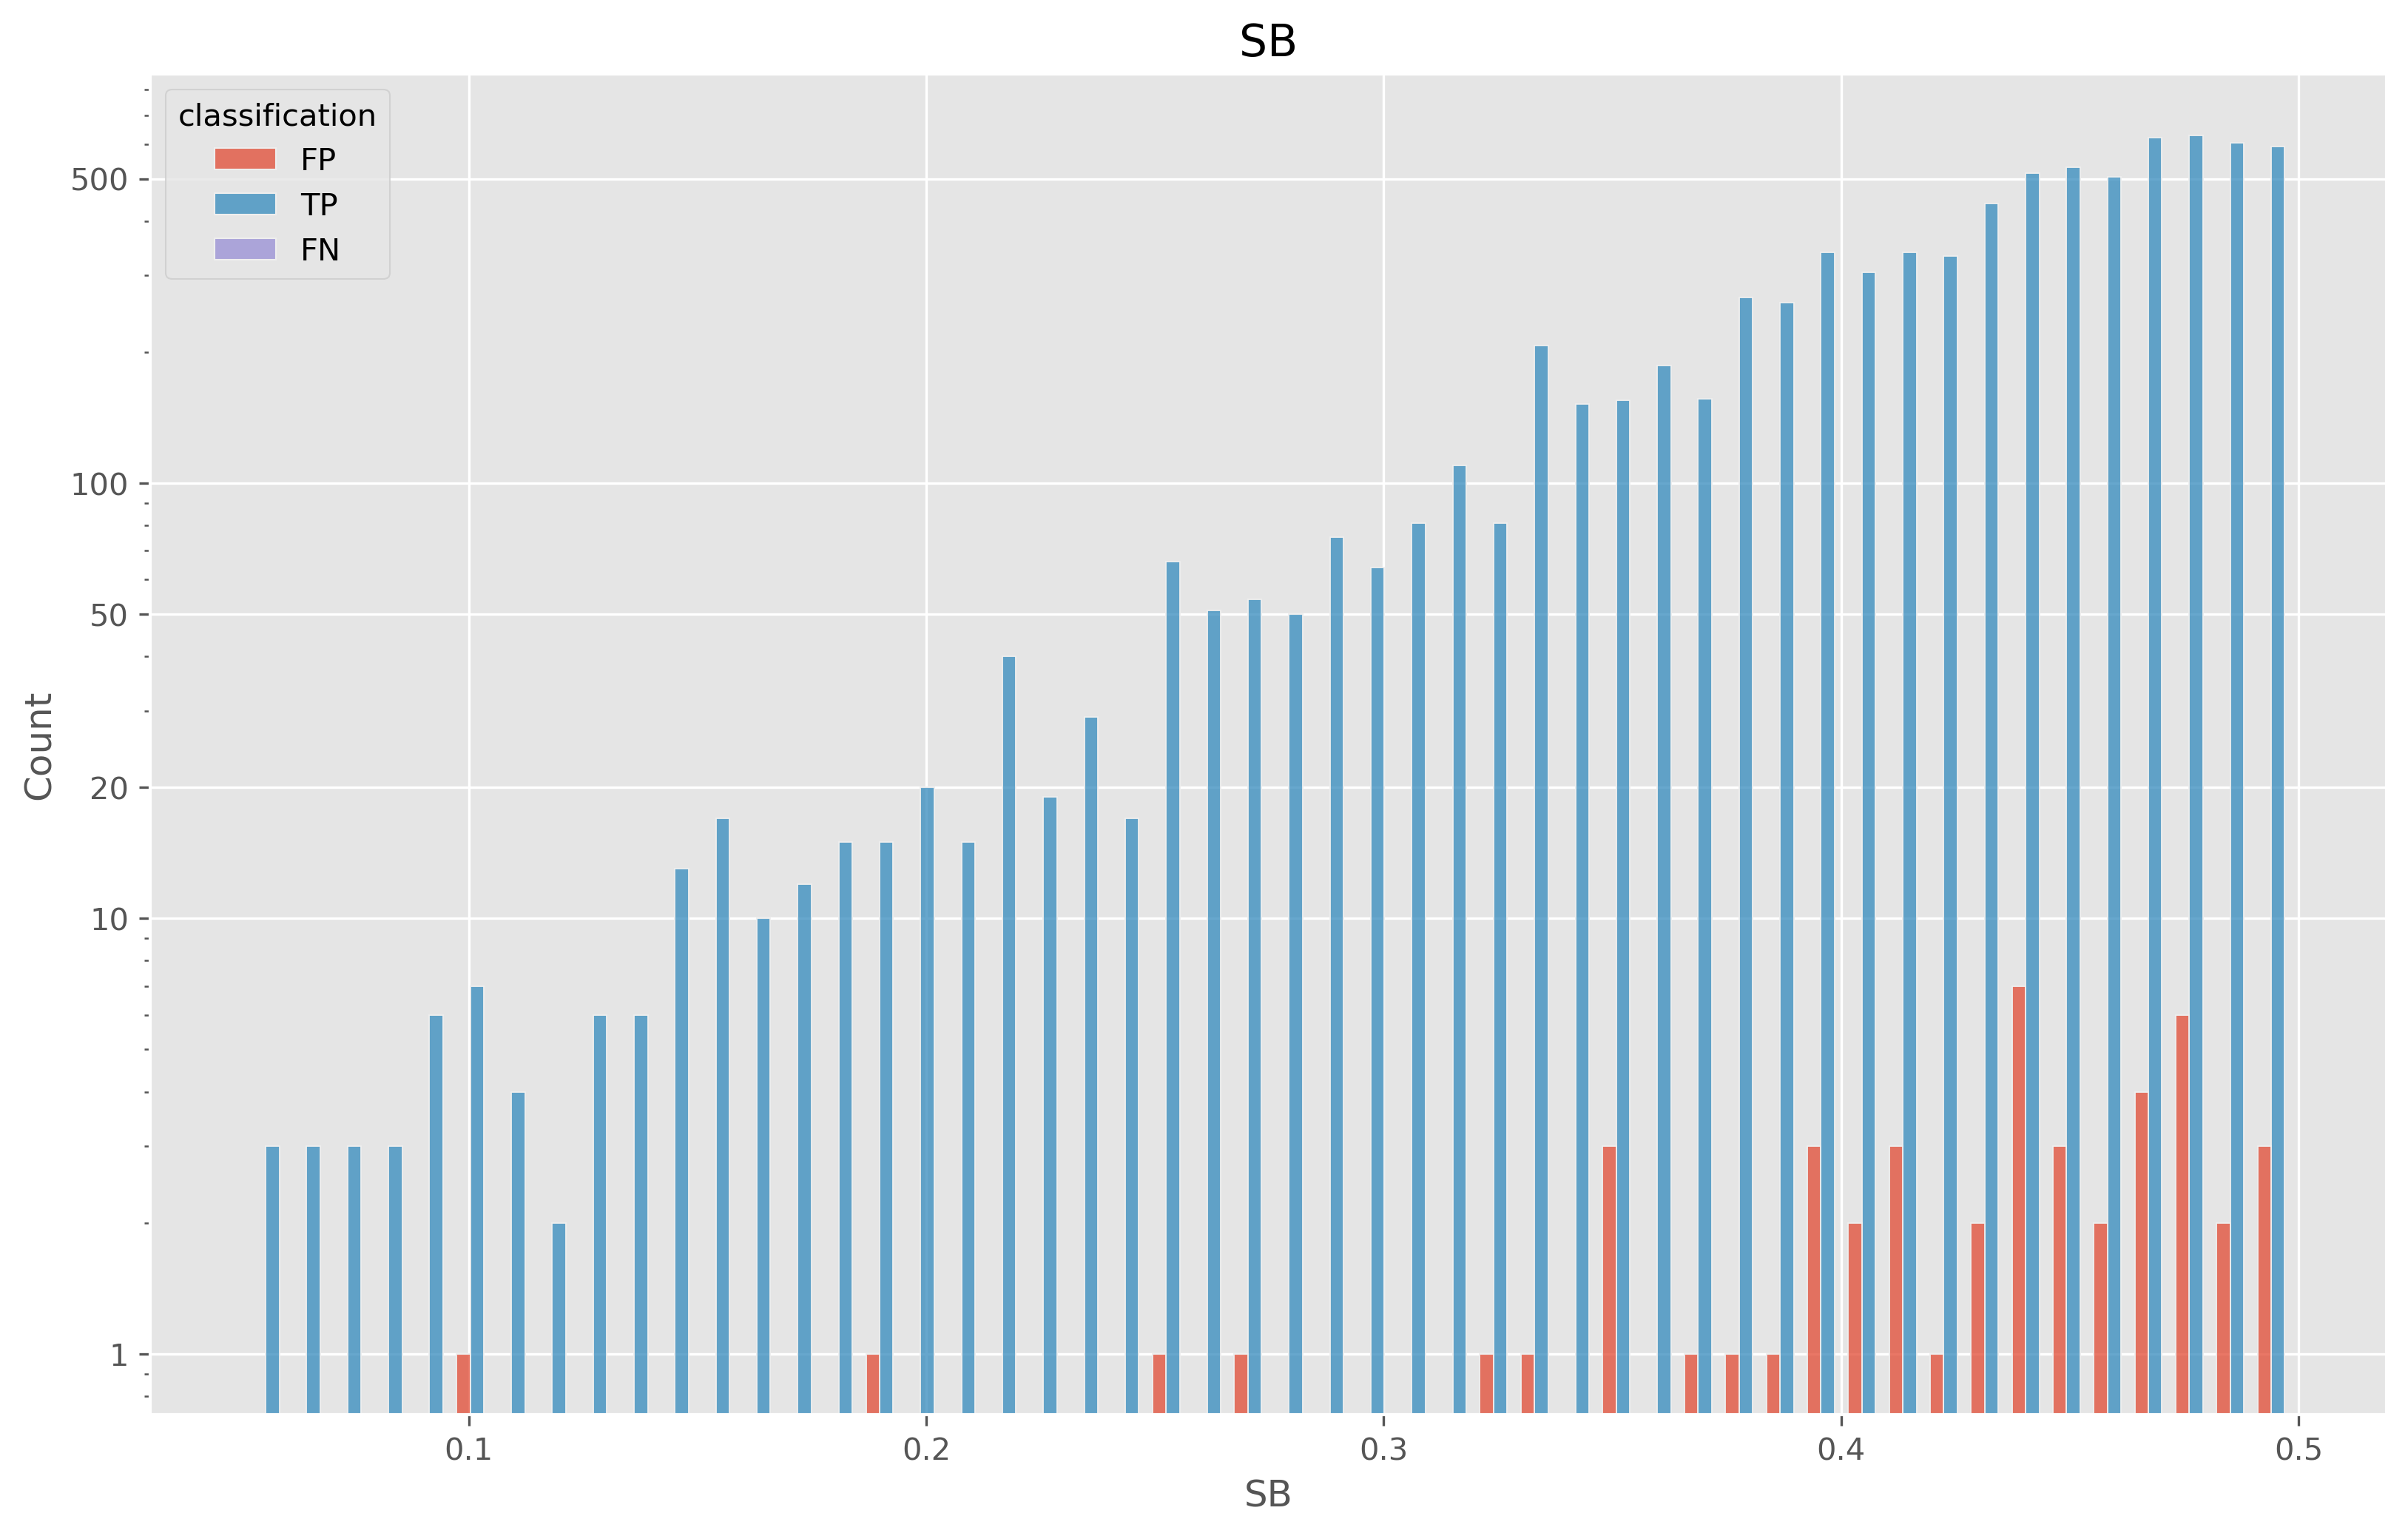

In [25]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SB"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
_=ax.set_title(x)

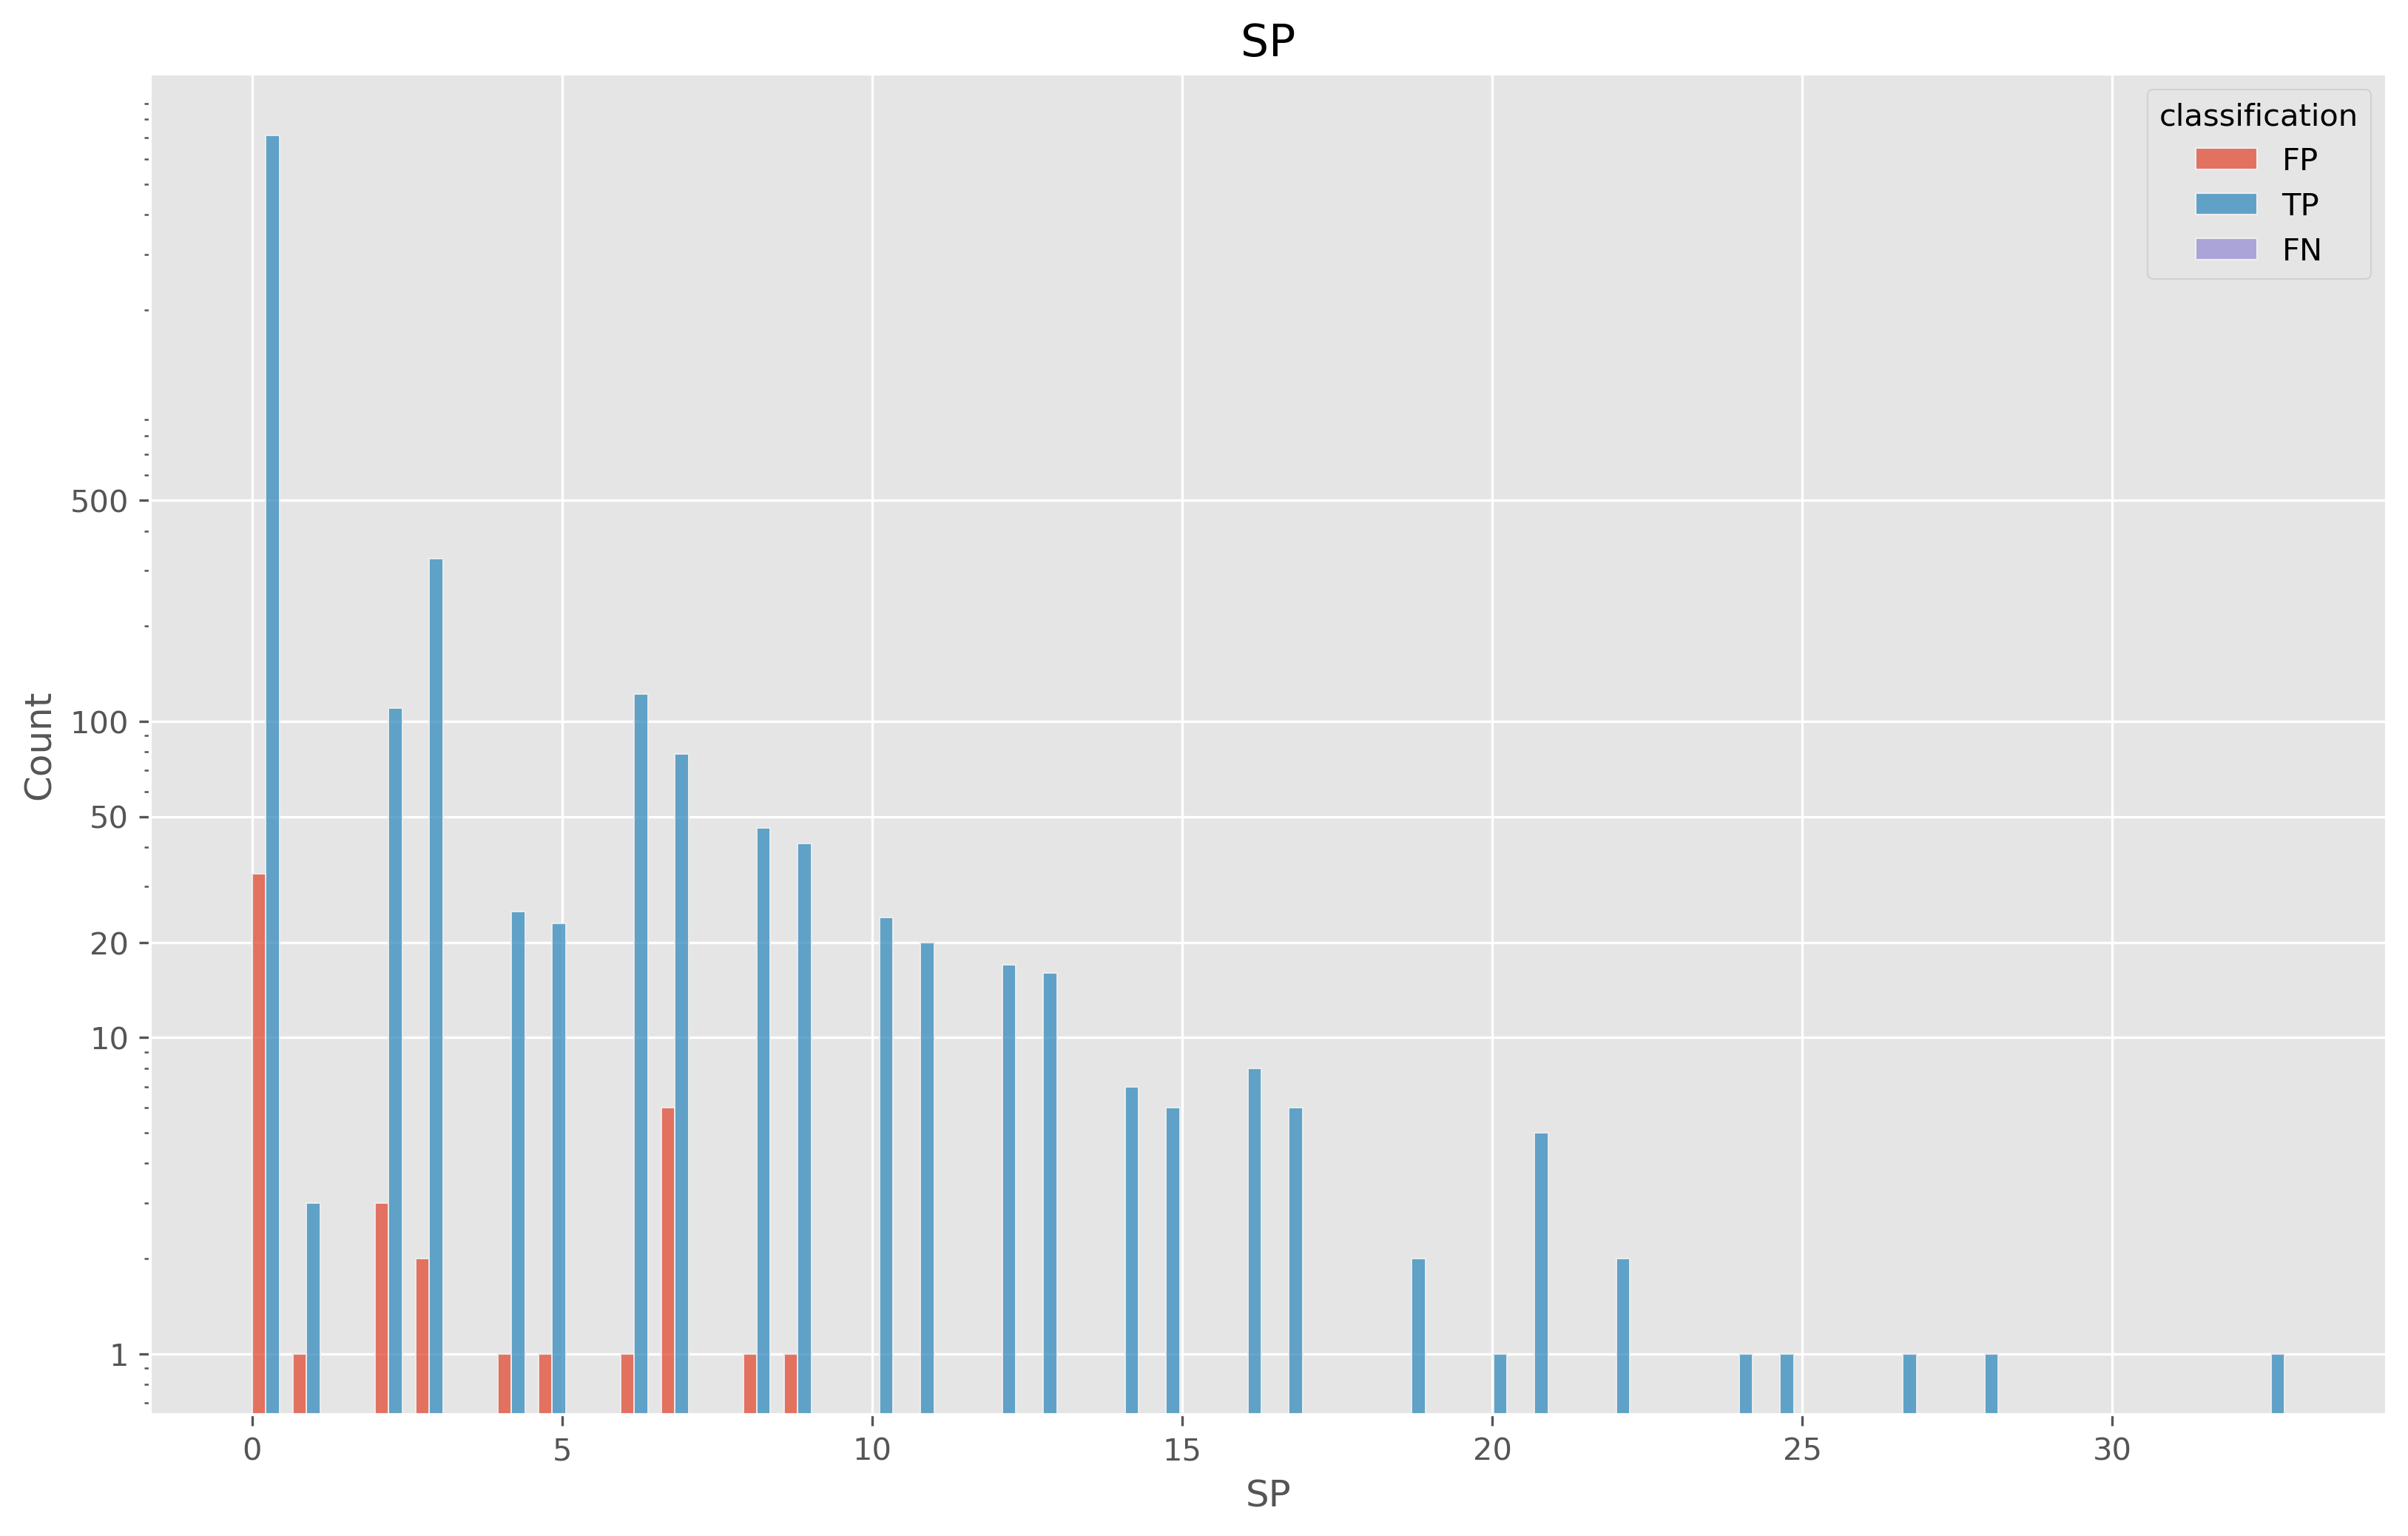

In [26]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SP"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
_=ax.set_title(x)

In [151]:
print(len(df.query("FED<0.15 and classification=='TP'")))
print(len(df.query("FED<0.15 and classification=='FP'")))

0
0


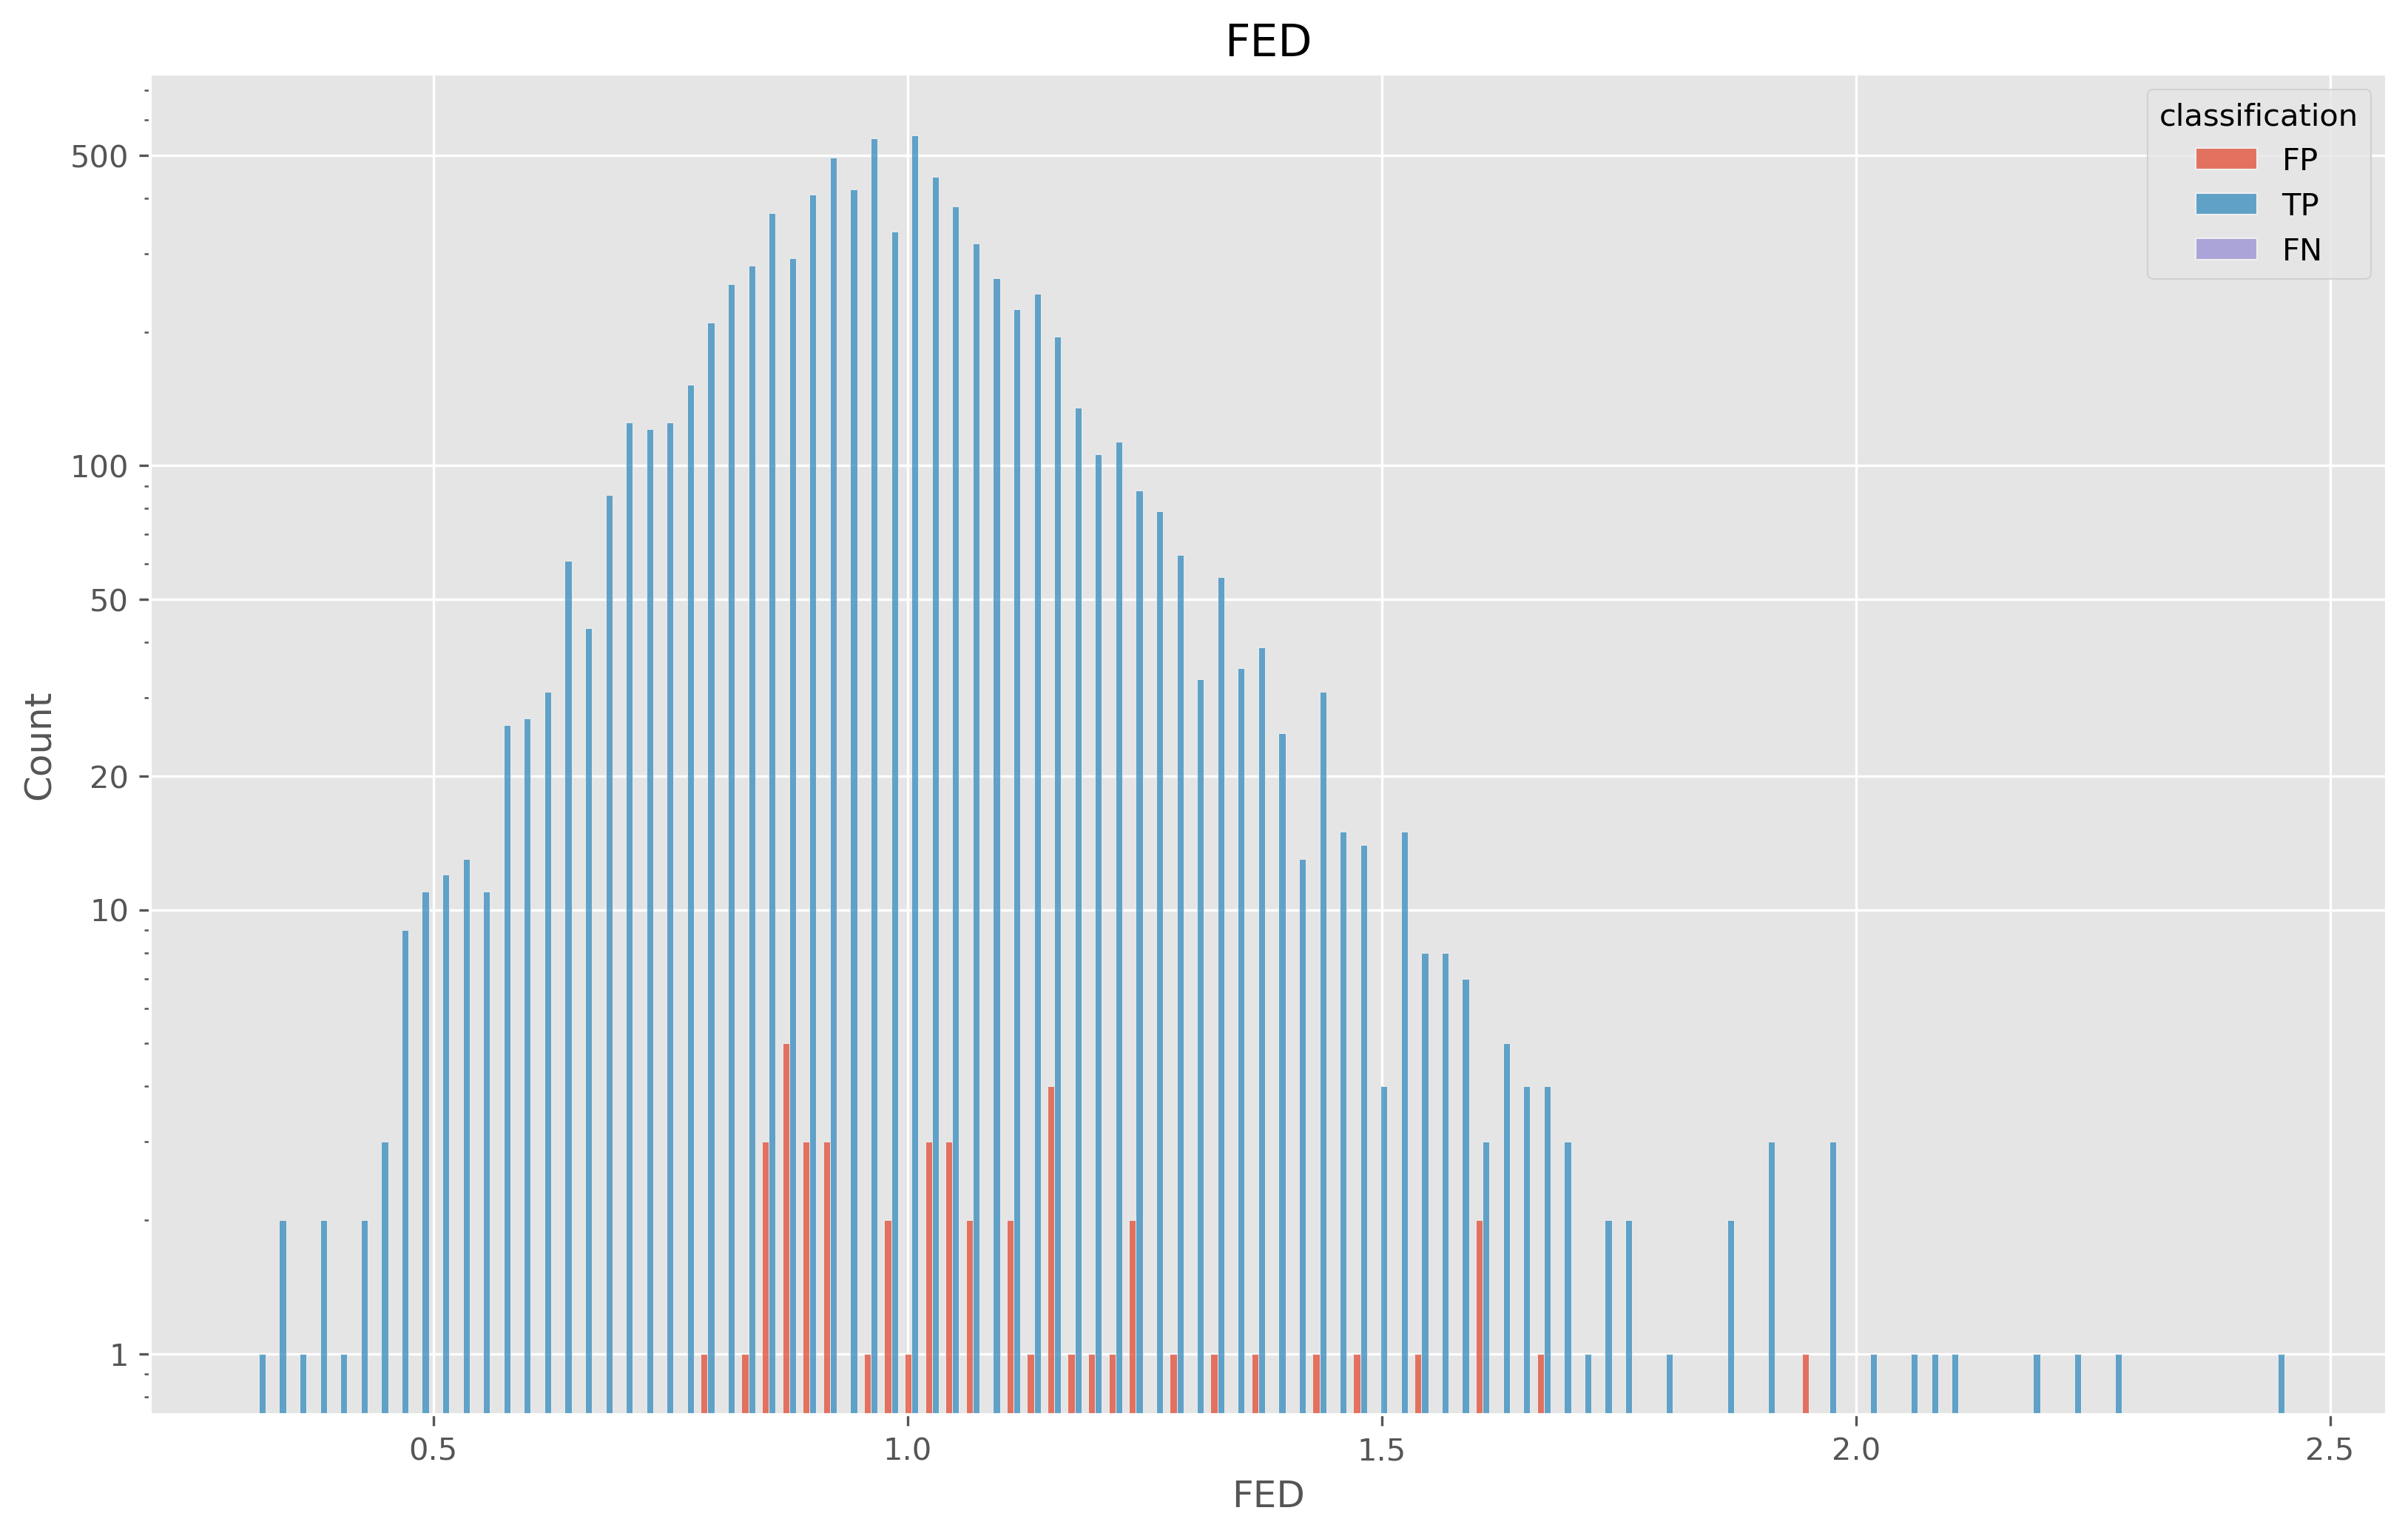

In [28]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "FED"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

In [153]:
for f in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    print(f)
    print(len(df.query(f"HQFED<{f} and classification=='TP'")))
    print(len(df.query(f"HQFED<{f} and classification=='FP'")))
    print()

0.05
0
0

0.1
0
0

0.15
0
0

0.2
0
0

0.25
28
2

0.3
109
8



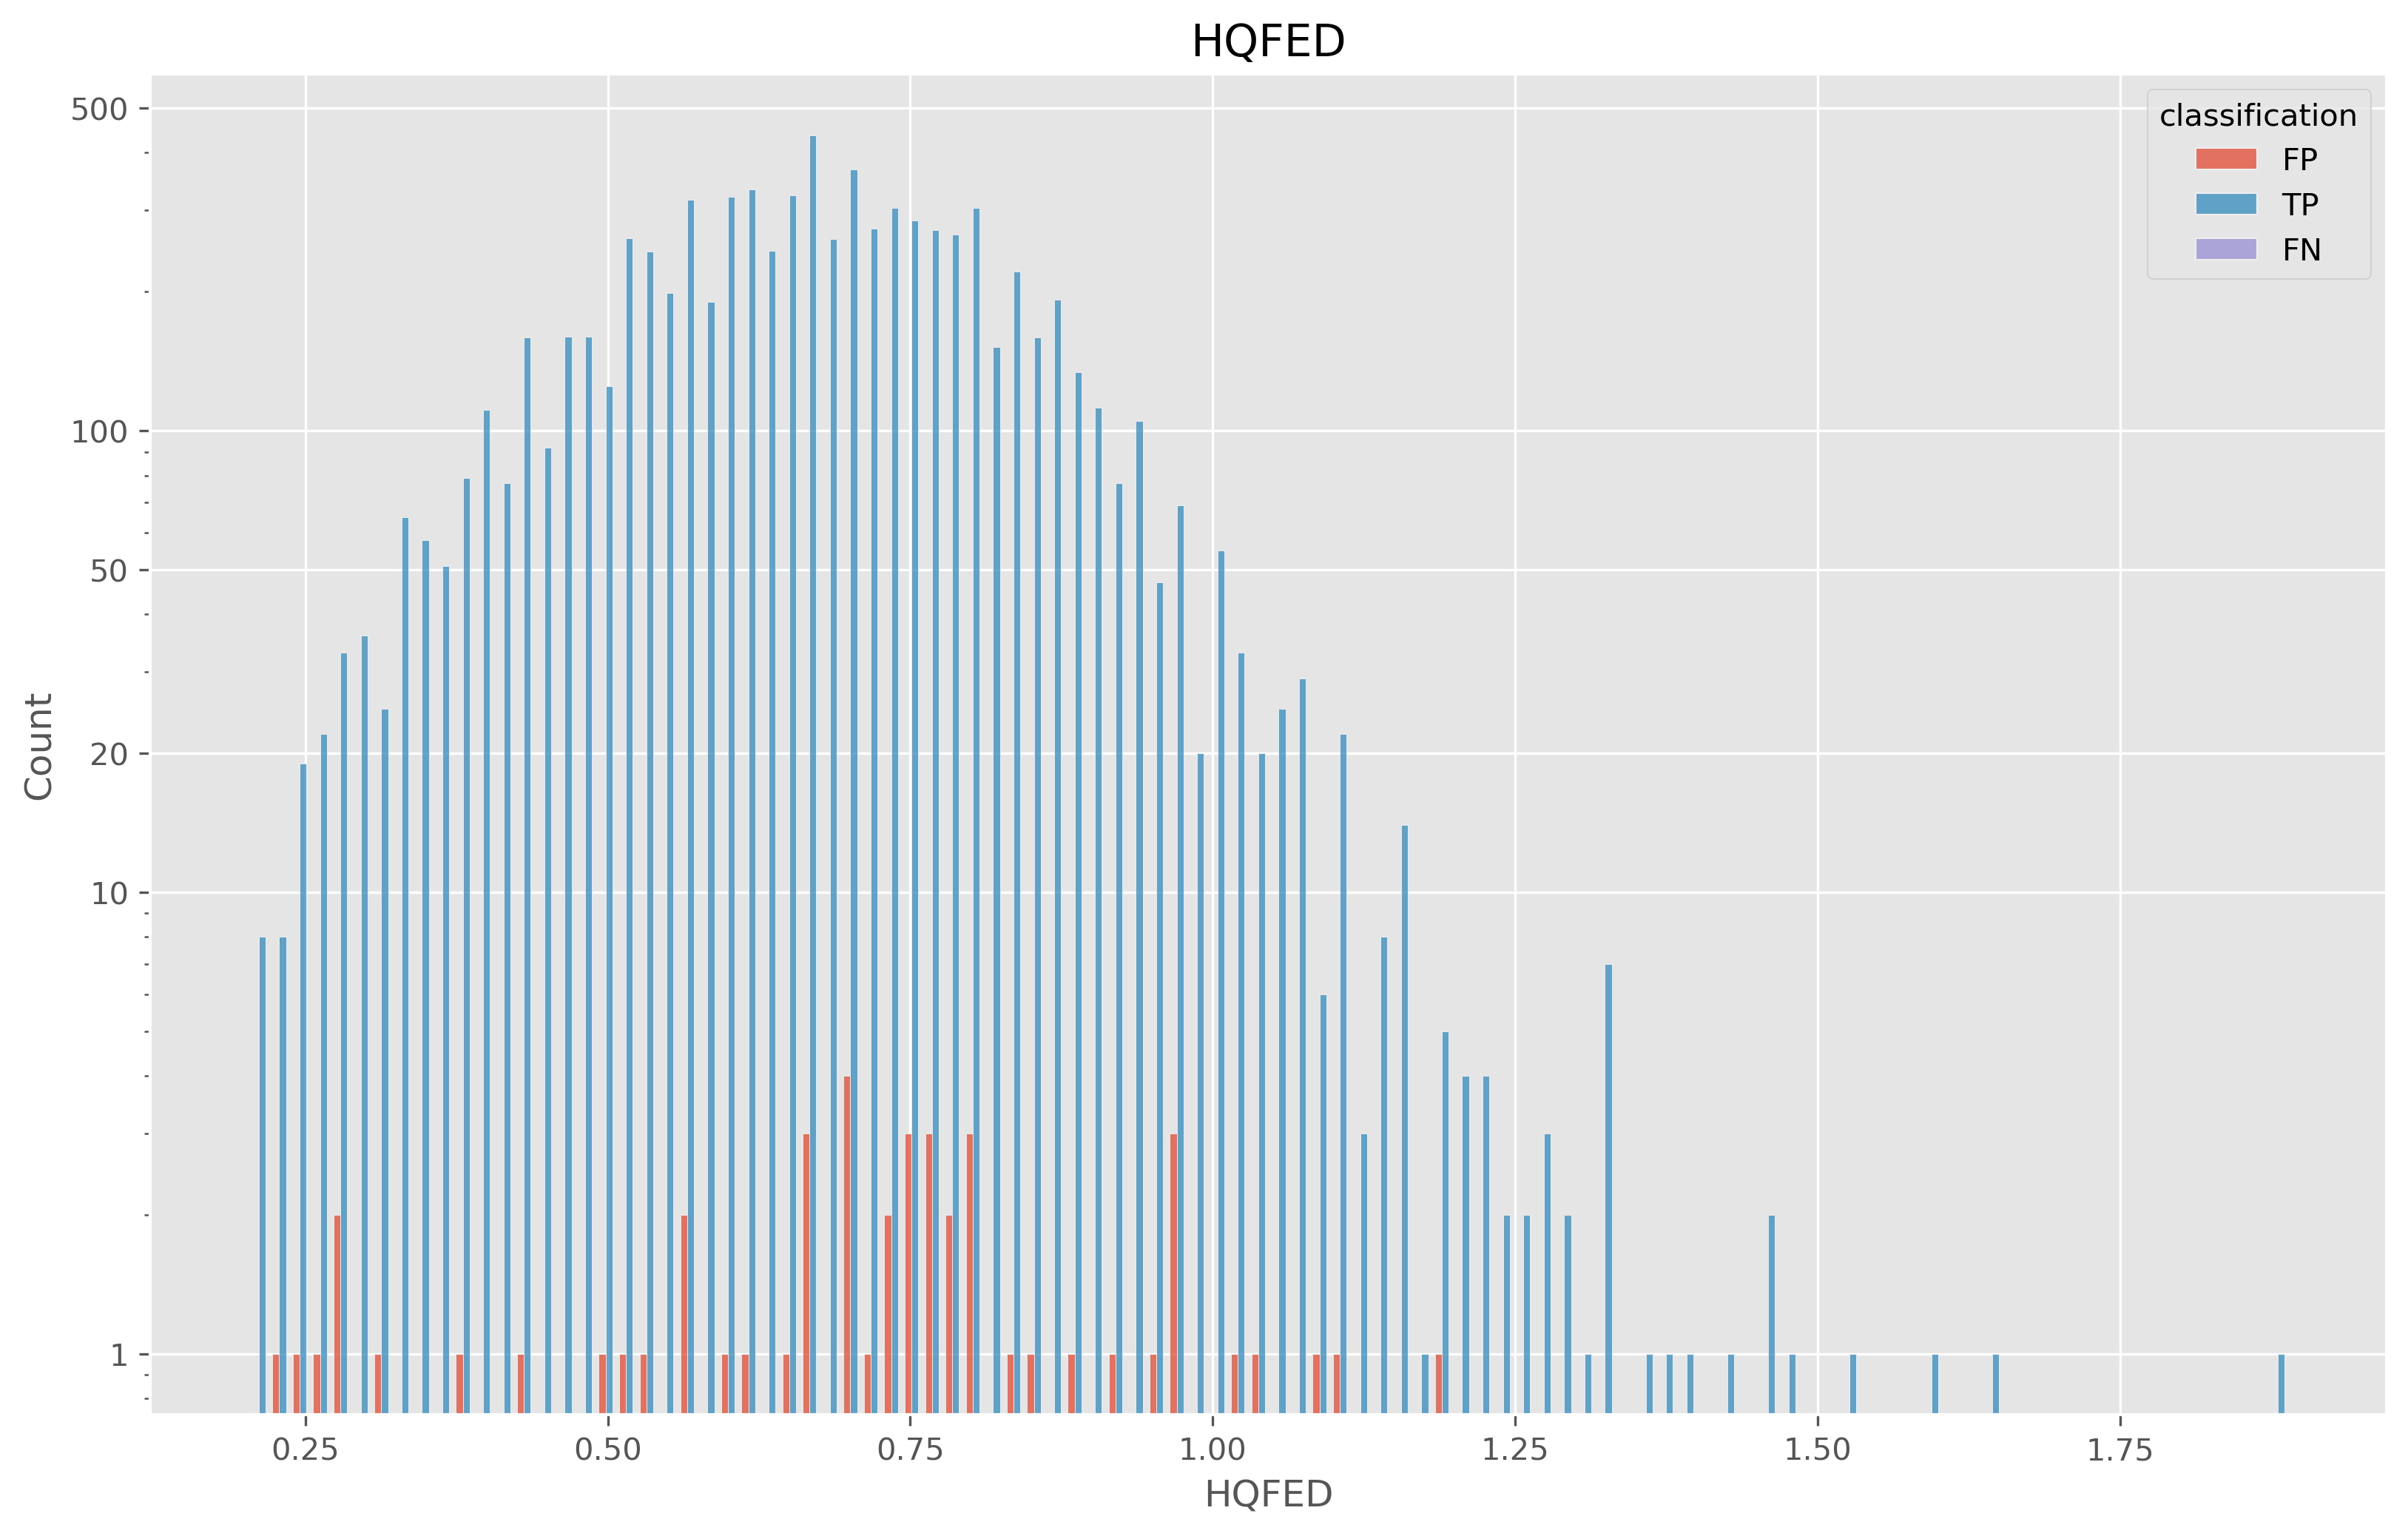

In [29]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "HQFED"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

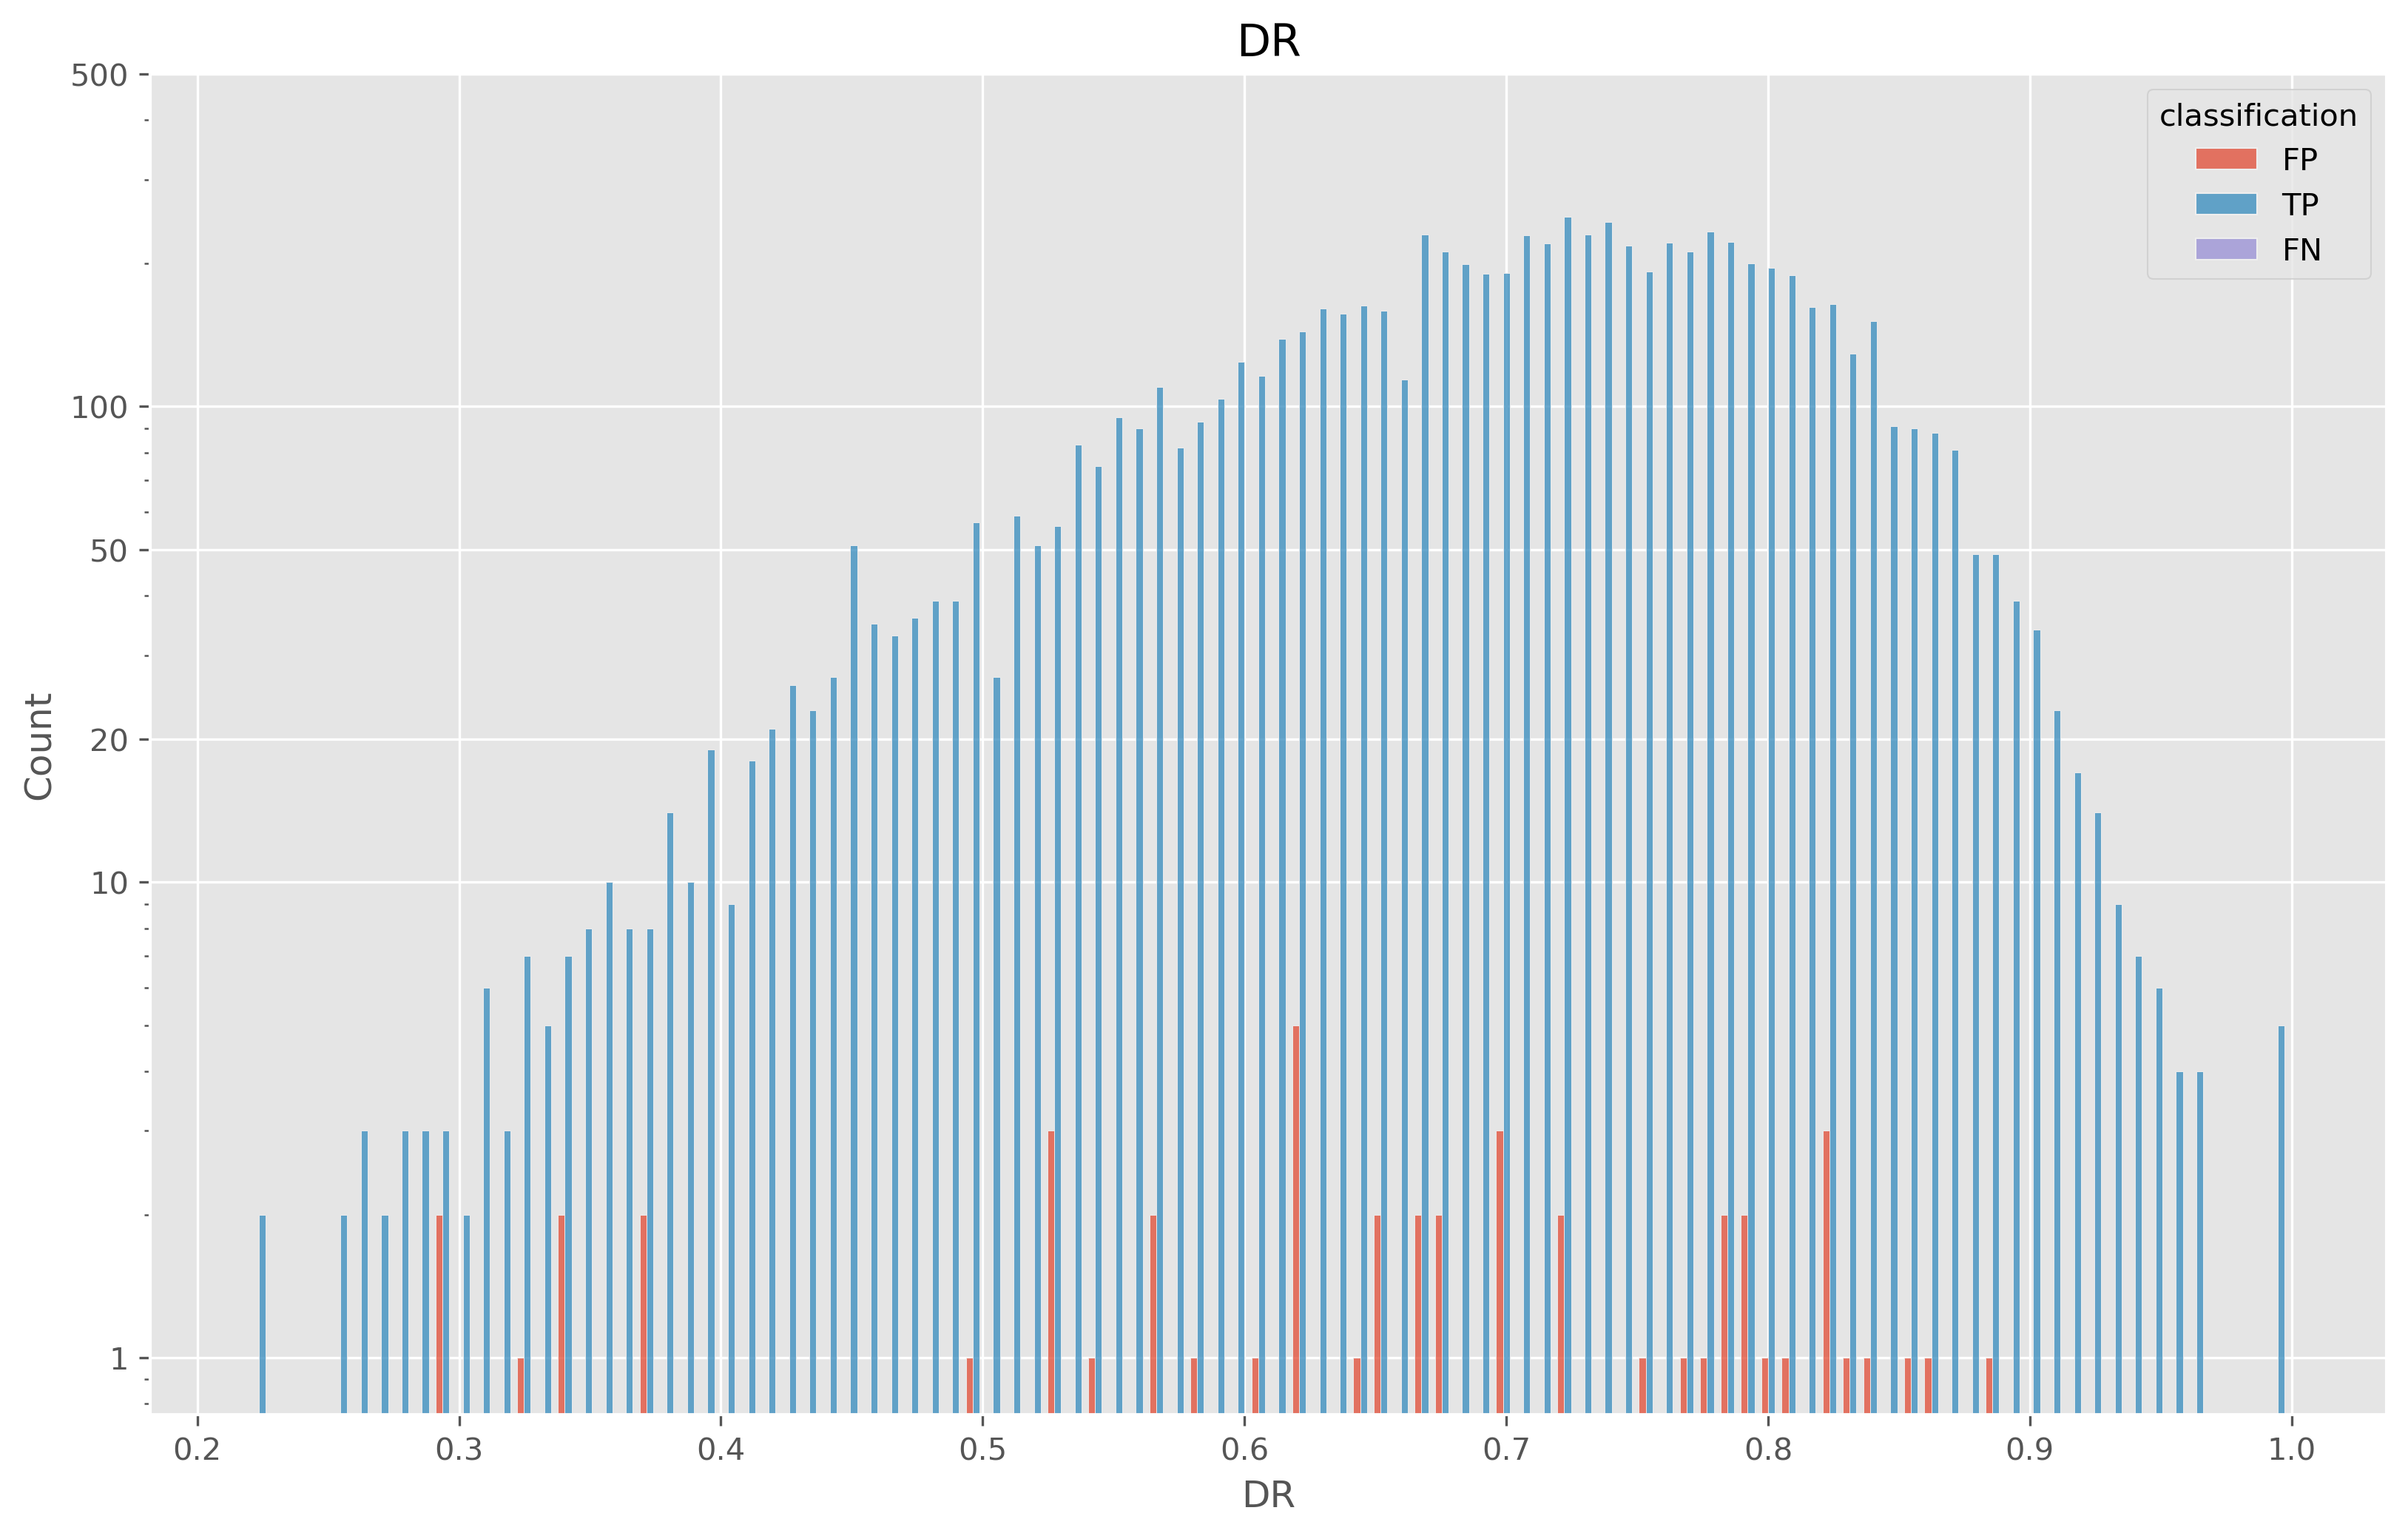

In [49]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "DR"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

In [35]:
print(len(df.query("SCRF>1.5 and classification=='TP'")))
print(len(df.query("SCRF>1.5 and classification=='FP'")))

27
4


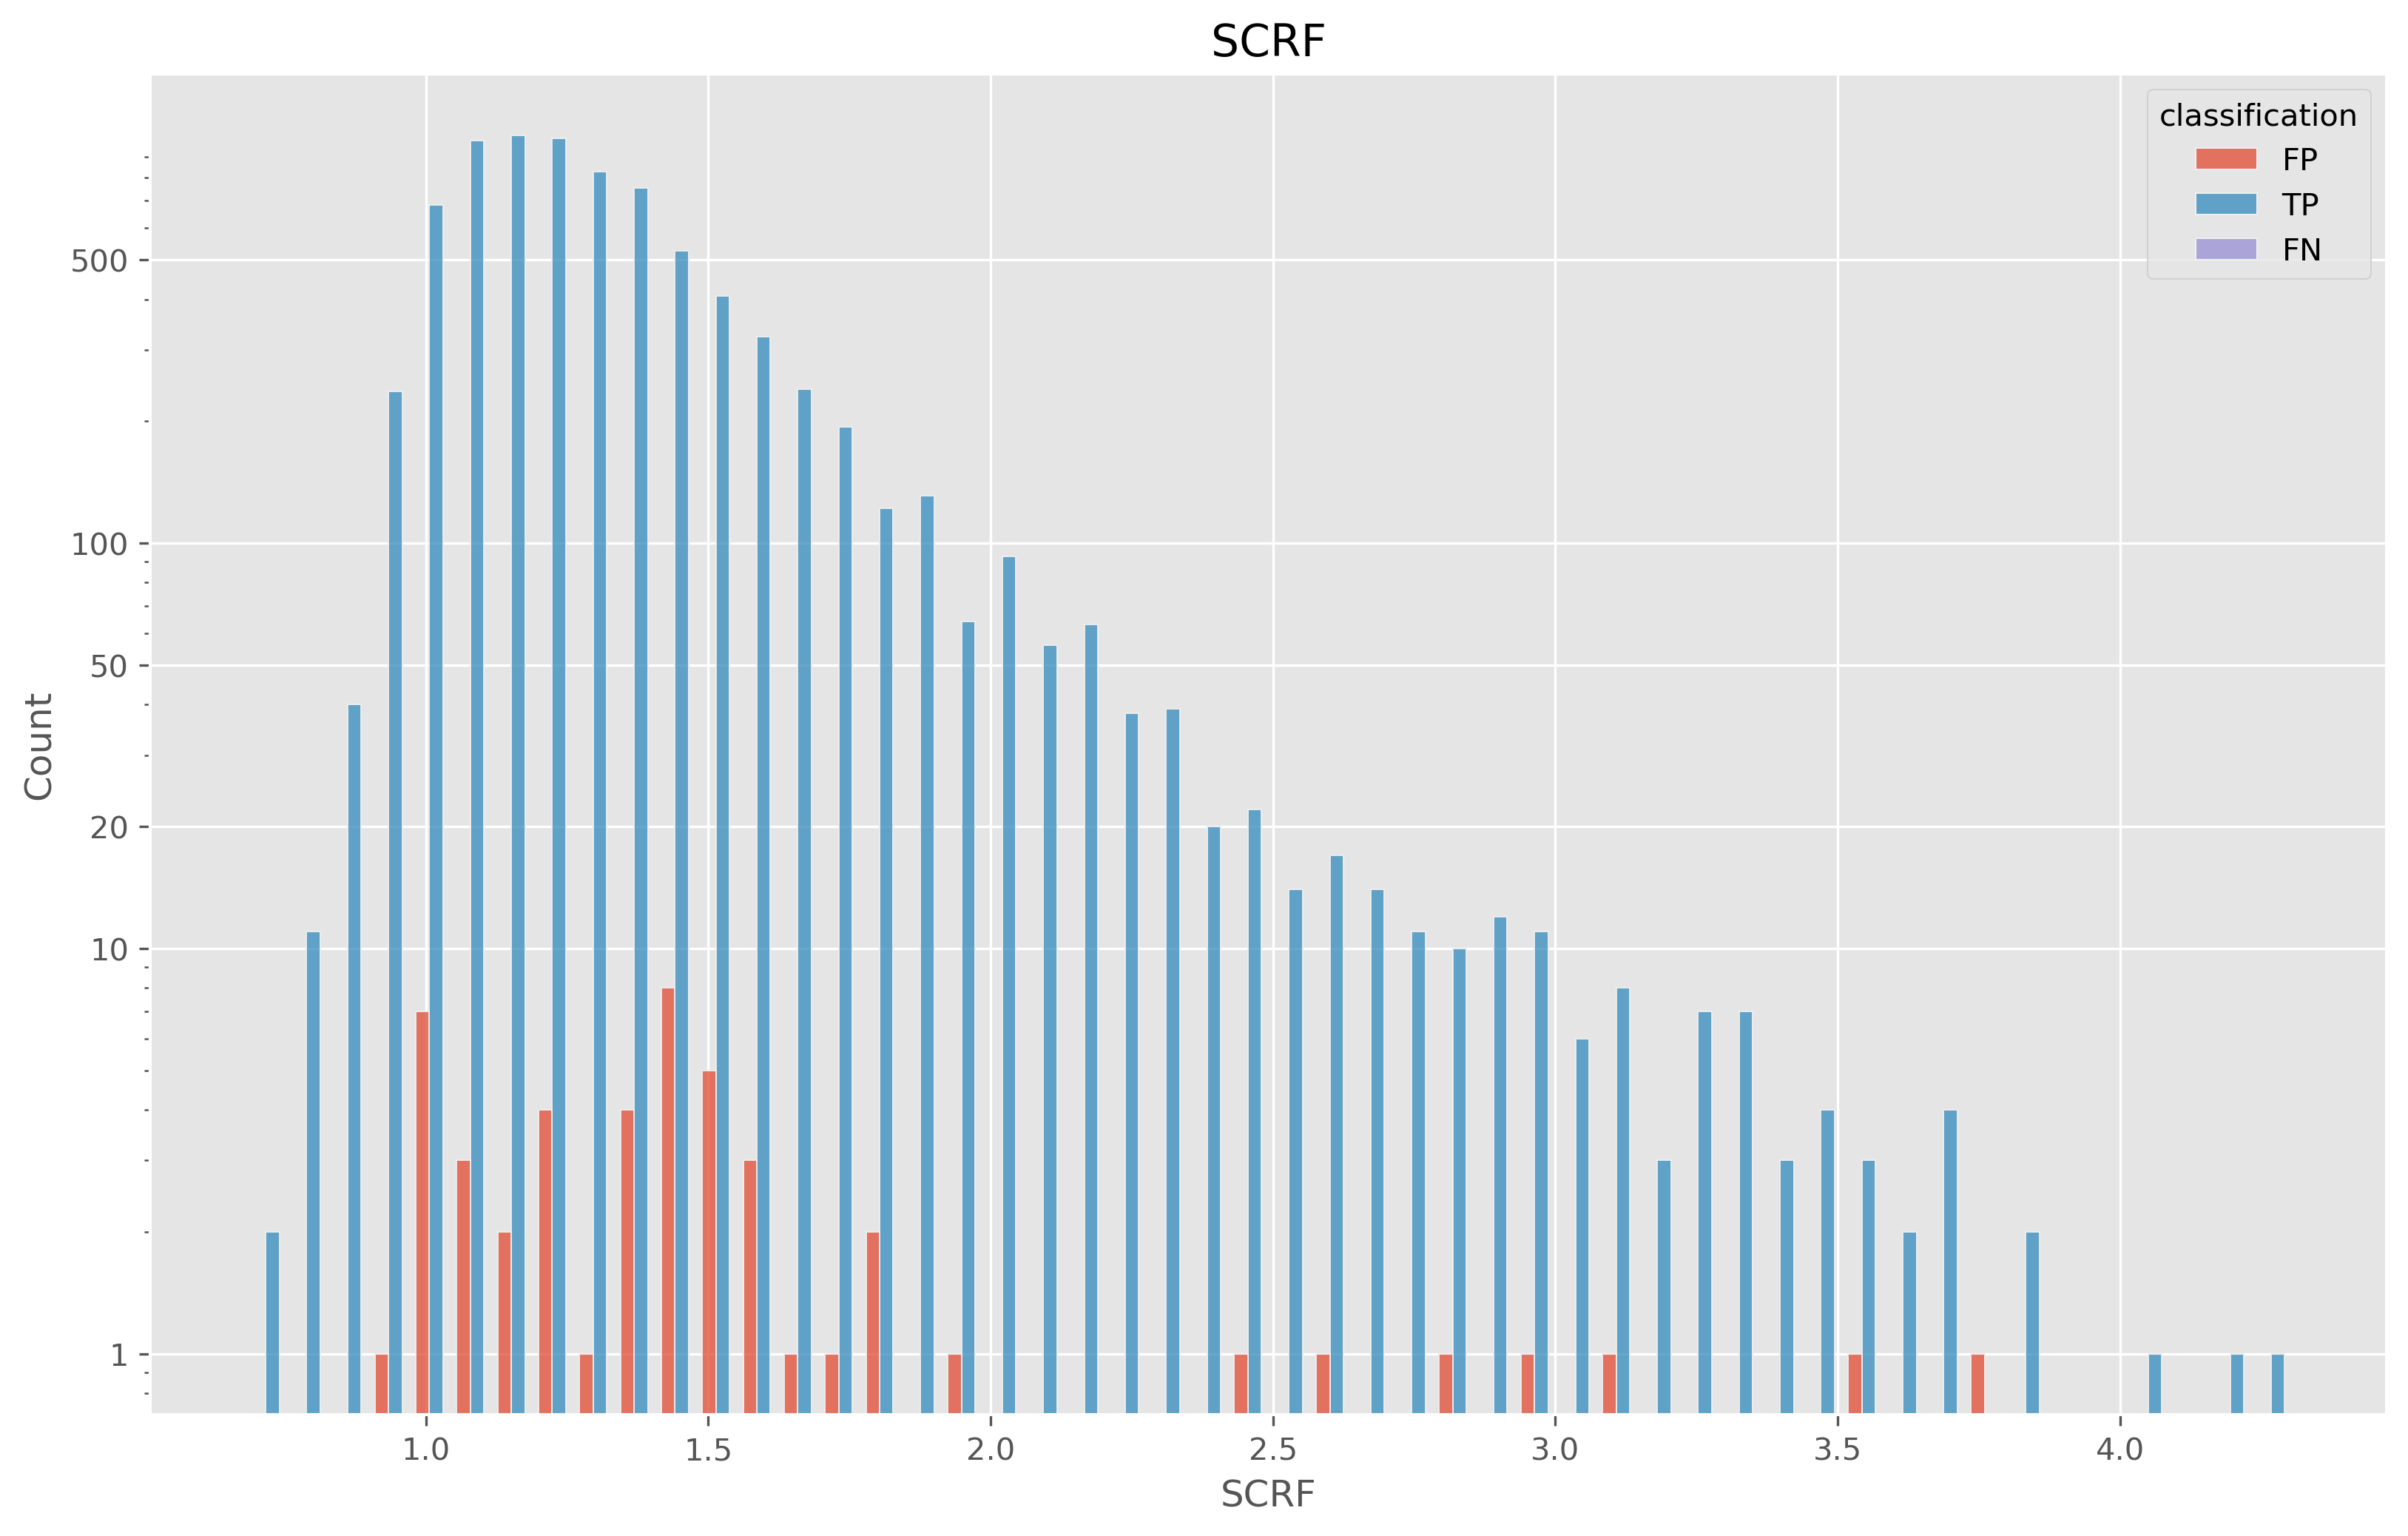

In [45]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCRF"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 1))
_=ax.set_title(x)

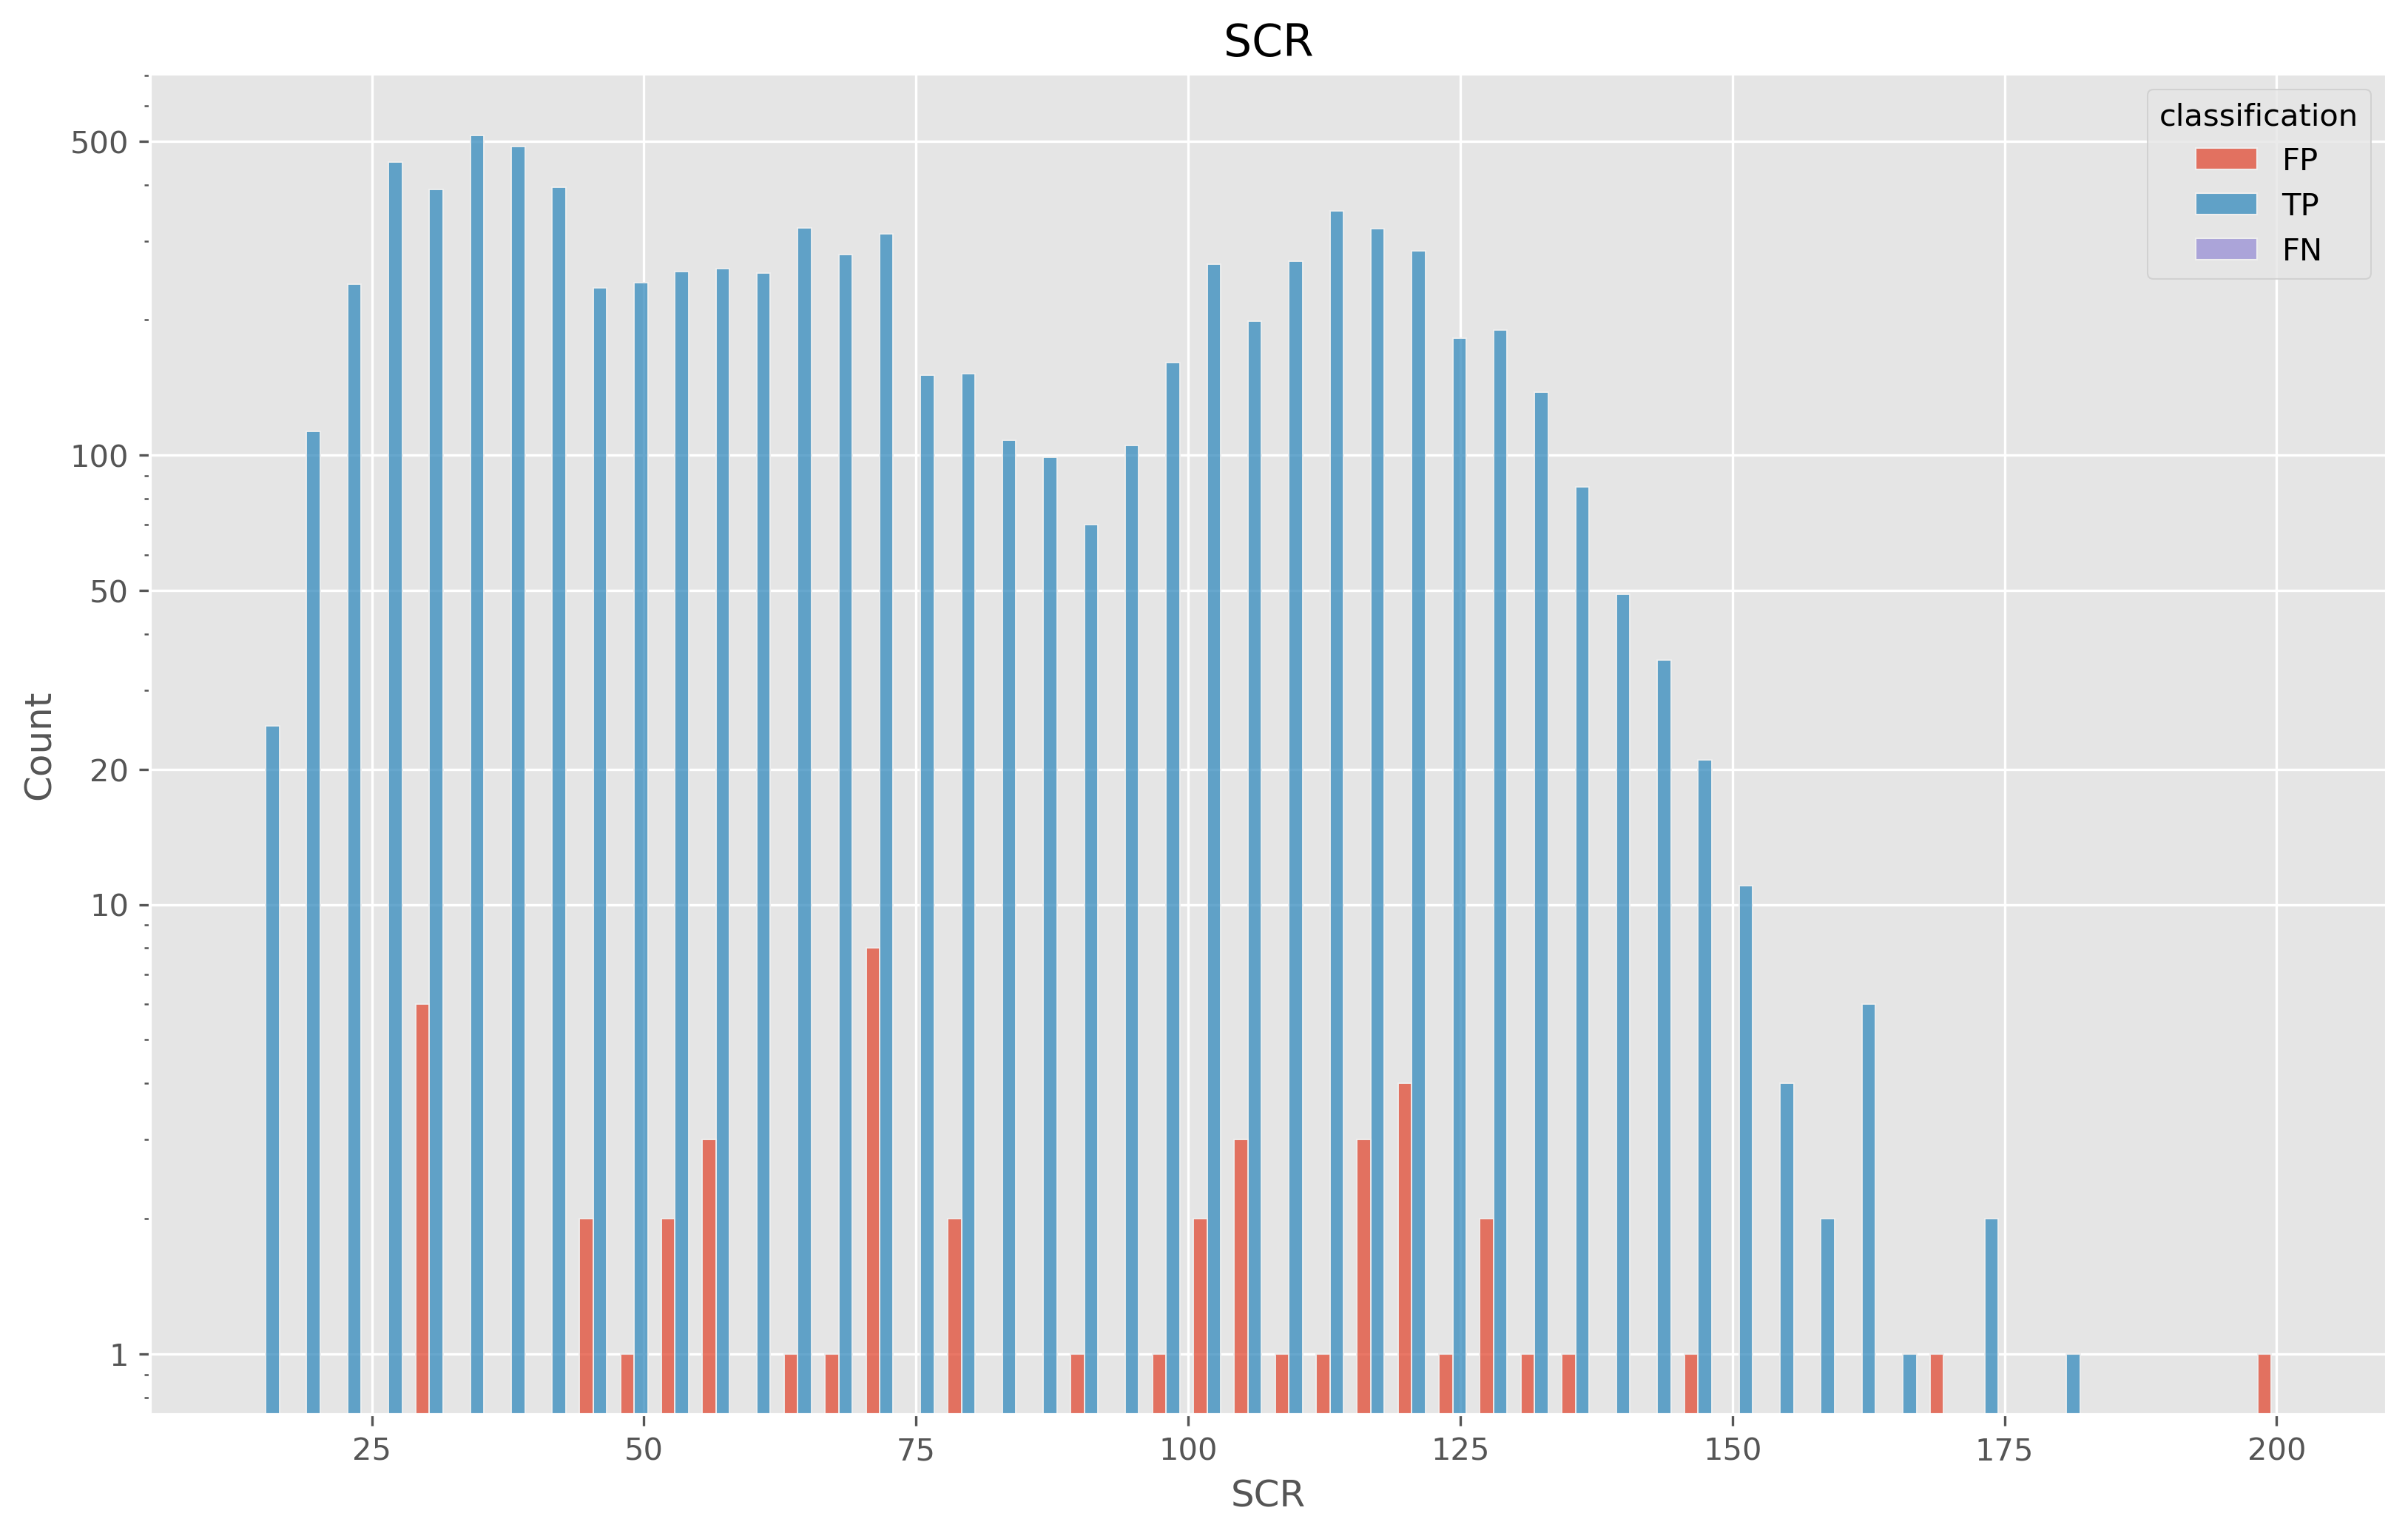

In [36]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCR"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 1))
_=ax.set_title(x)

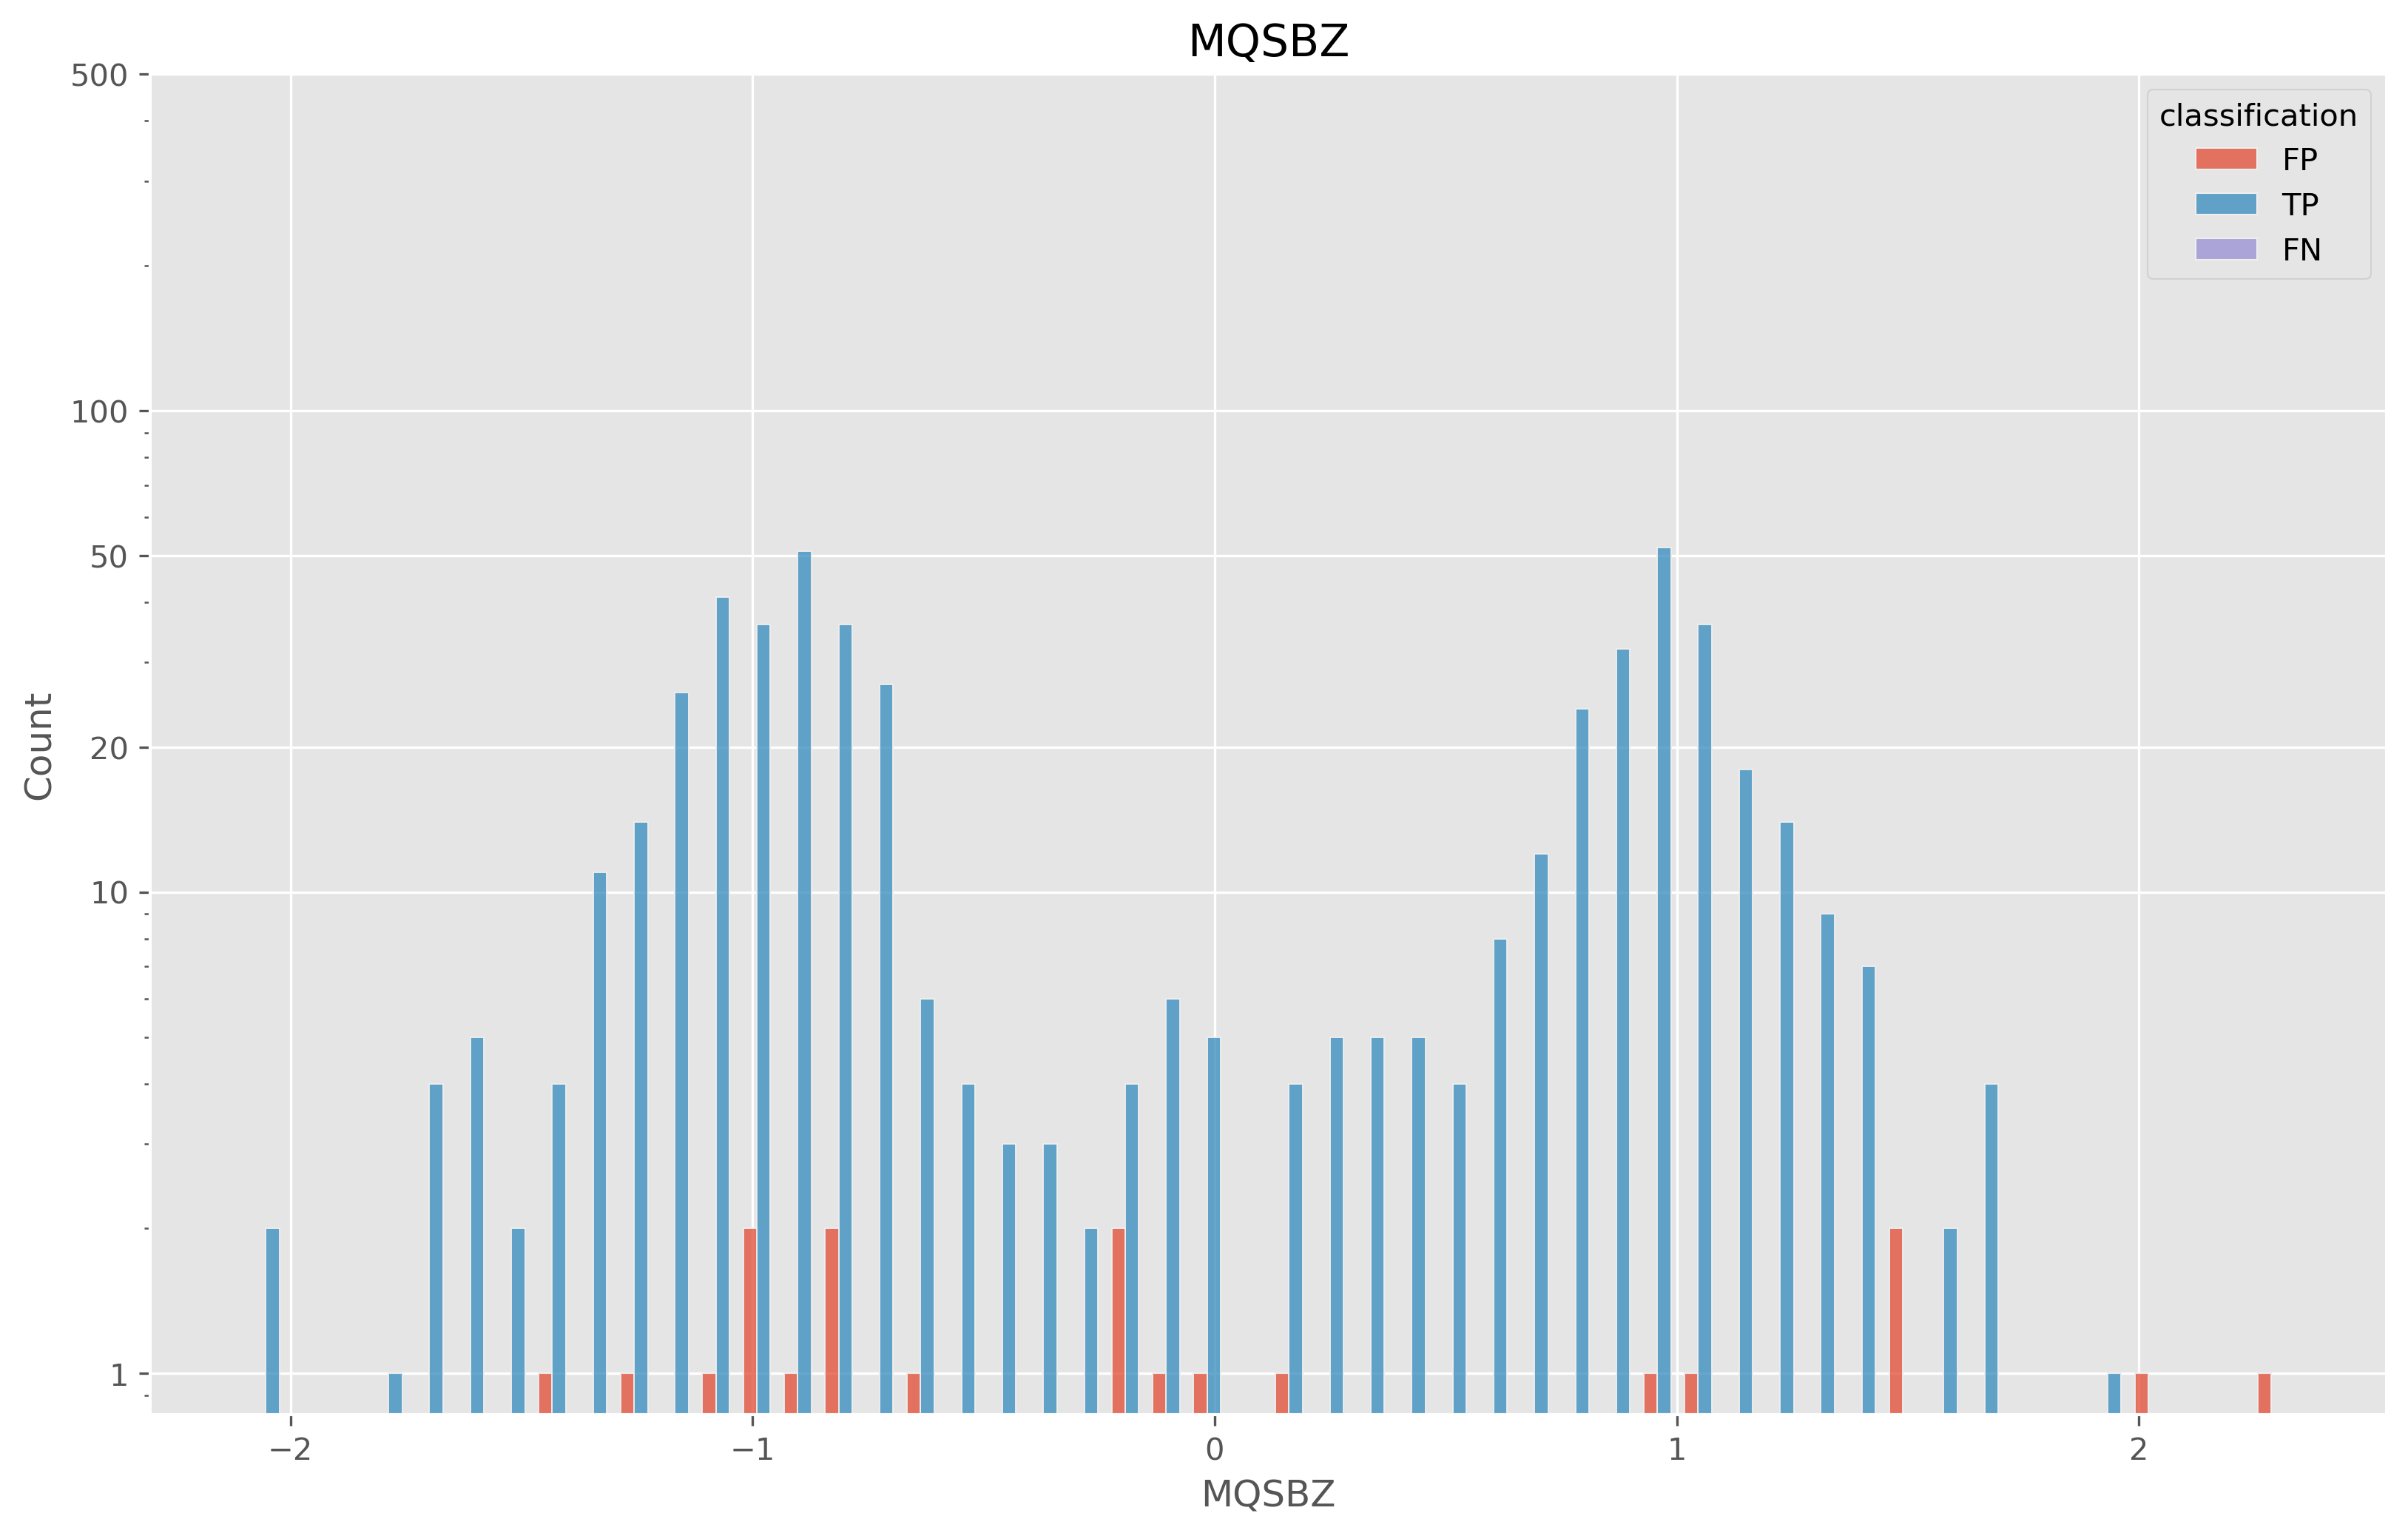

In [158]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "MQSBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [159]:
print(len(df.query("MQ<50 and classification=='TP'")))
print(len(df.query("MQ<50 and classification=='FP'")))

2
0


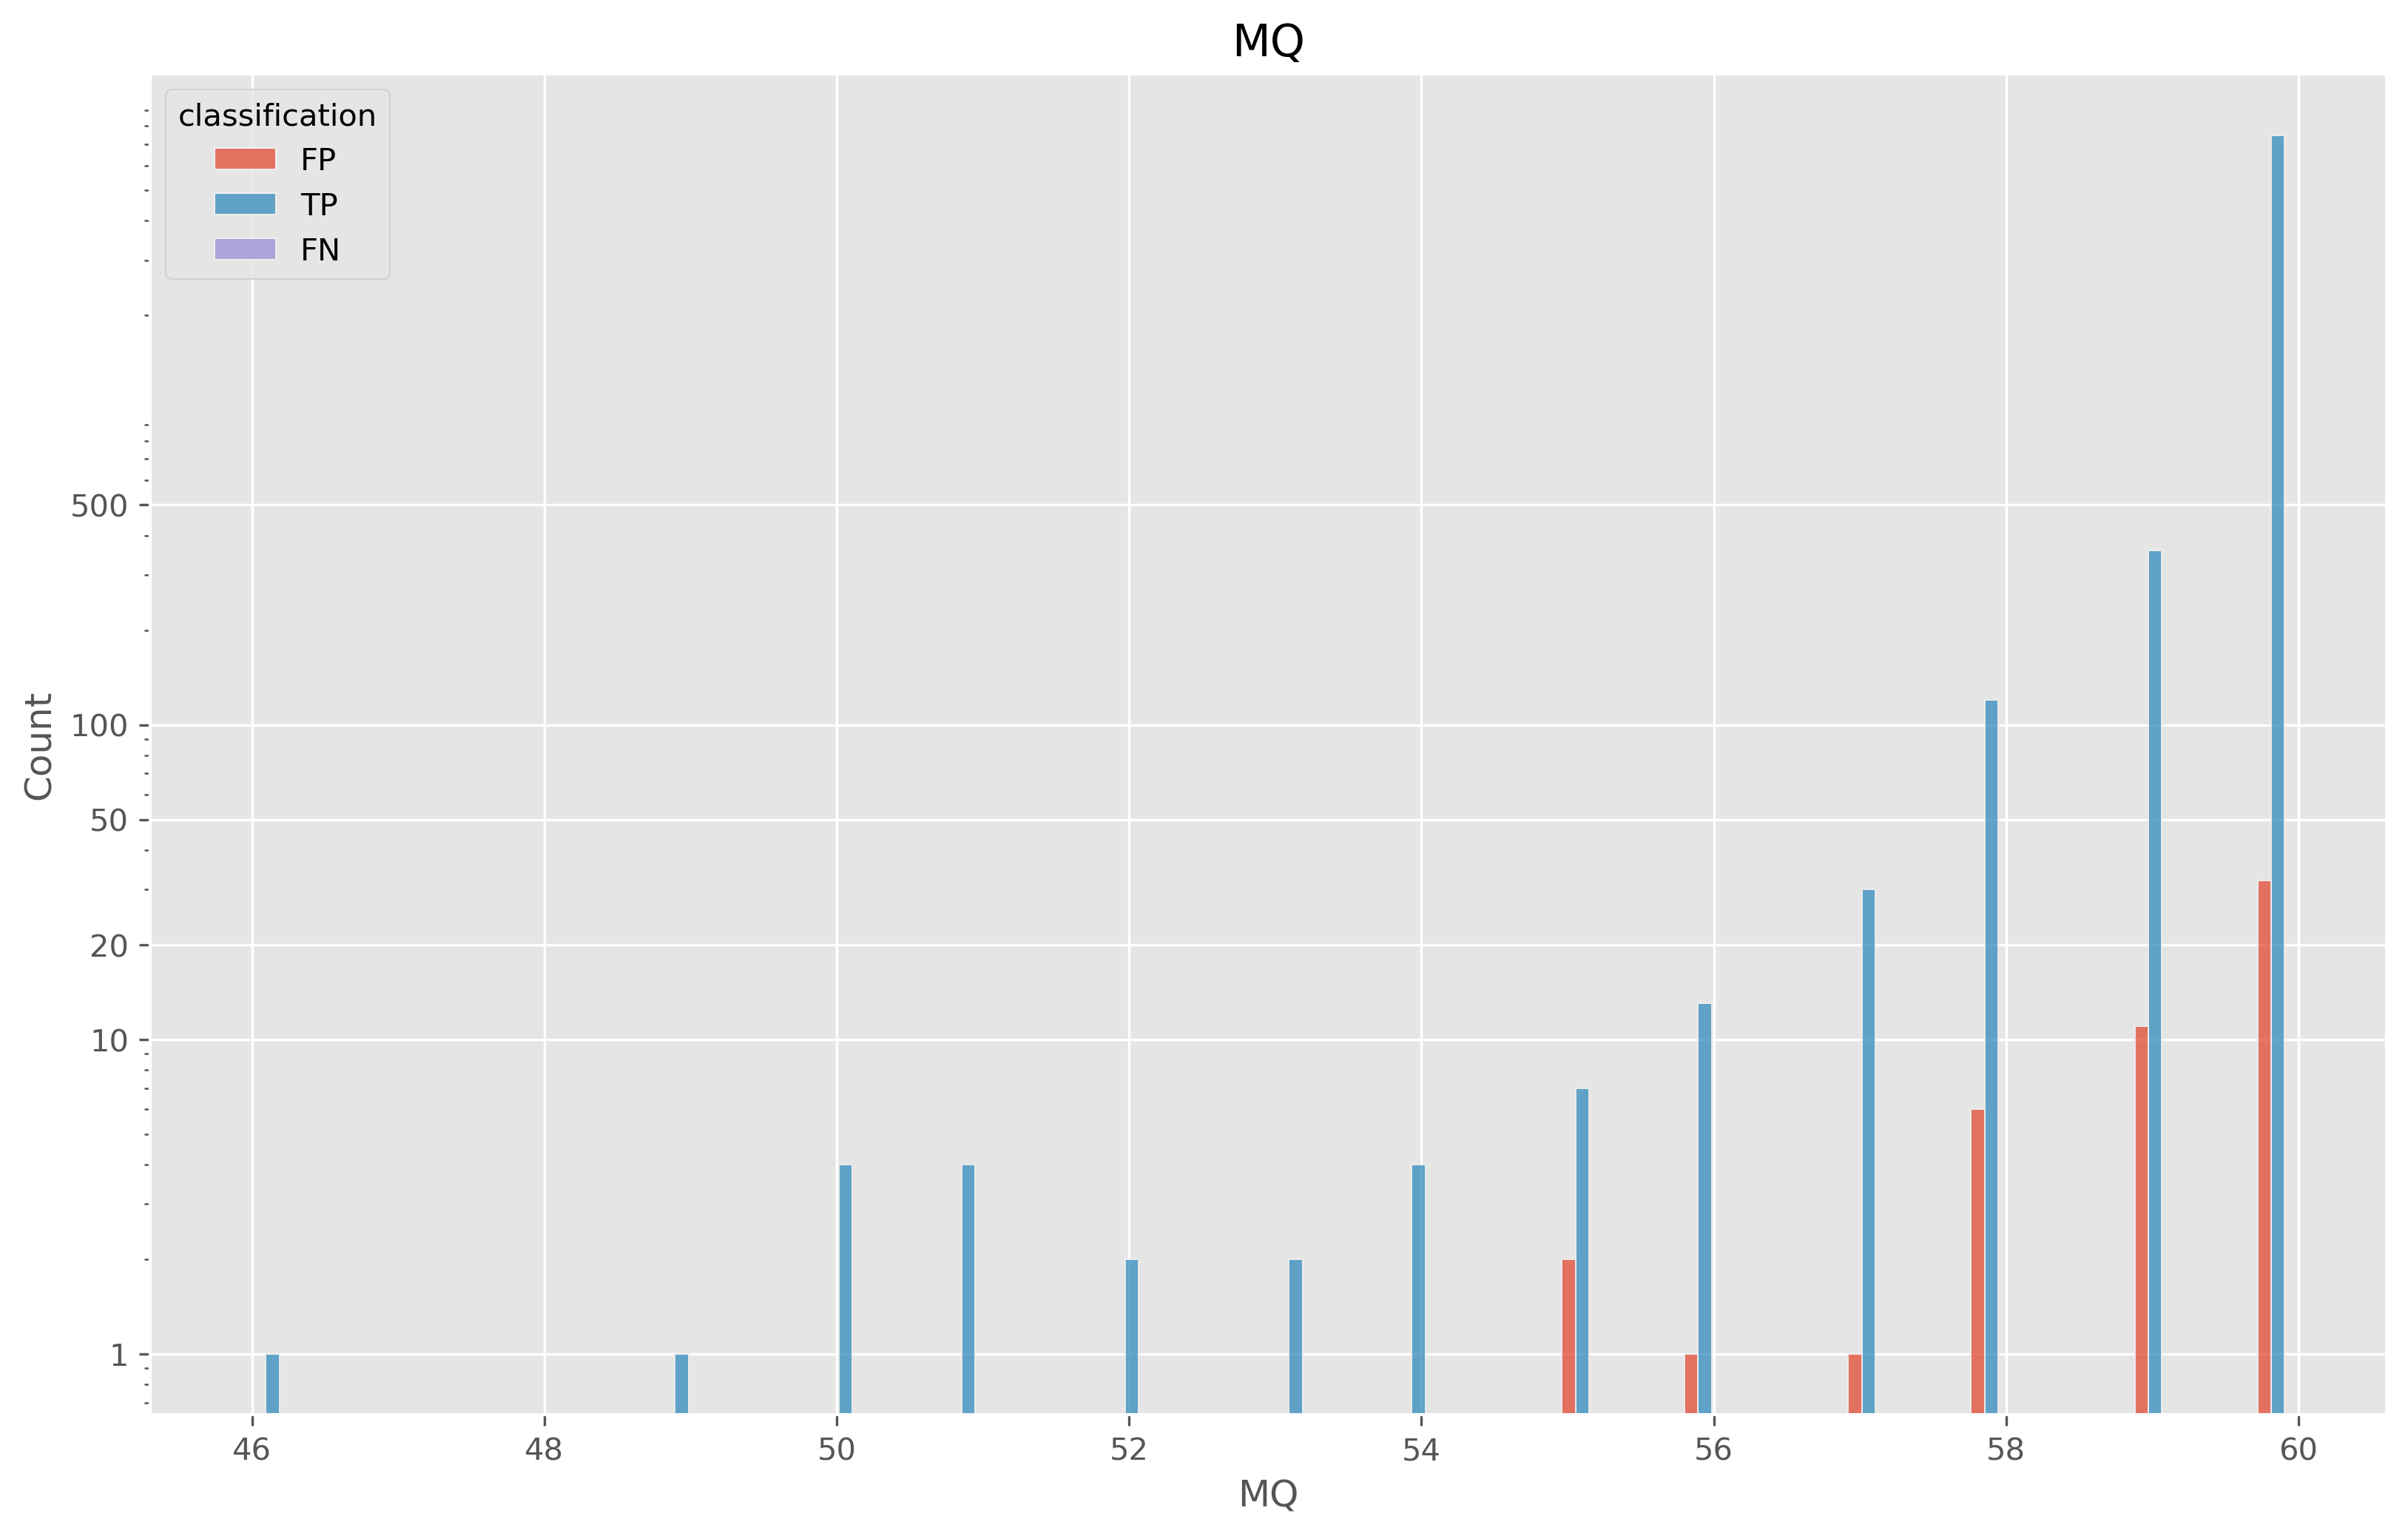

In [160]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "MQ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [175]:
print(len(df.query(f"VDB<0.0001 and classification=='TP'")))
print(len(df.query(f"VDB<0.0001 and classification=='FP'")))

13
3


##### 

In [169]:
f"{1e-5:.7f}"

'0.0000100'

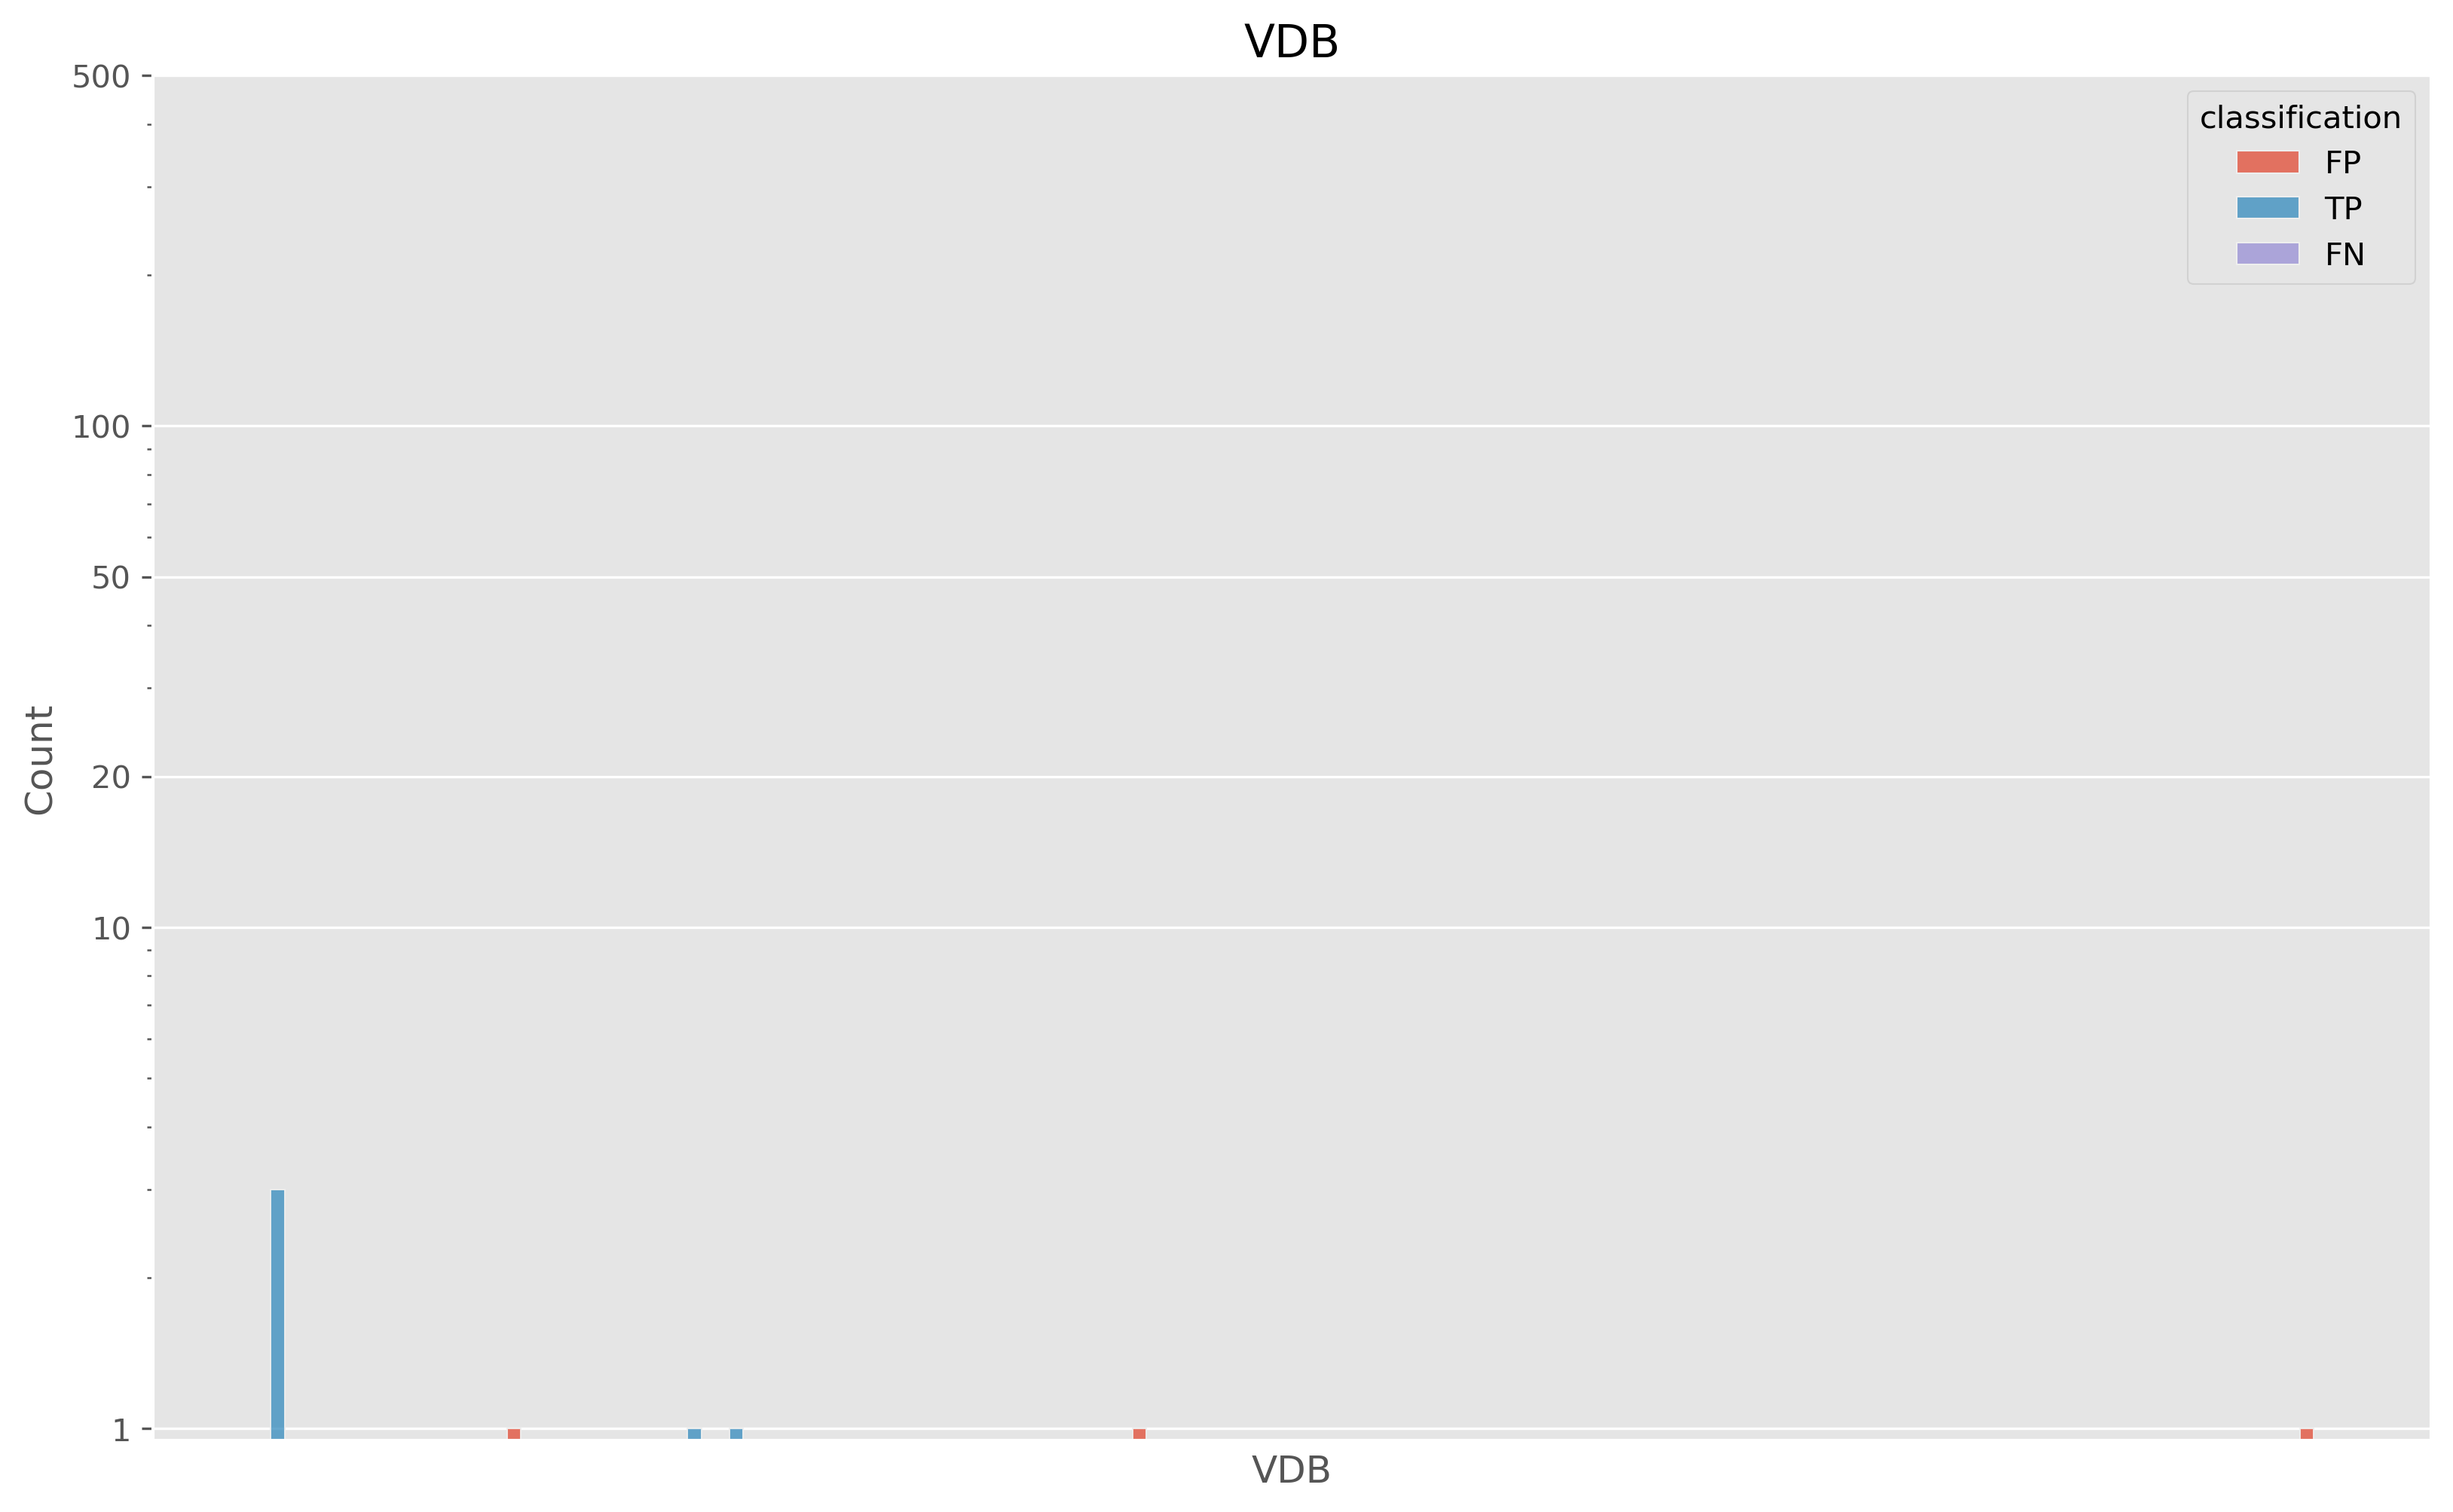

In [171]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "VDB"
sns.histplot(data=df.query("VDB<0.00001"), x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
xlabs = [1e-5]
ax.set_xticks(xlabs)
ax.set_xticklabels(xlabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

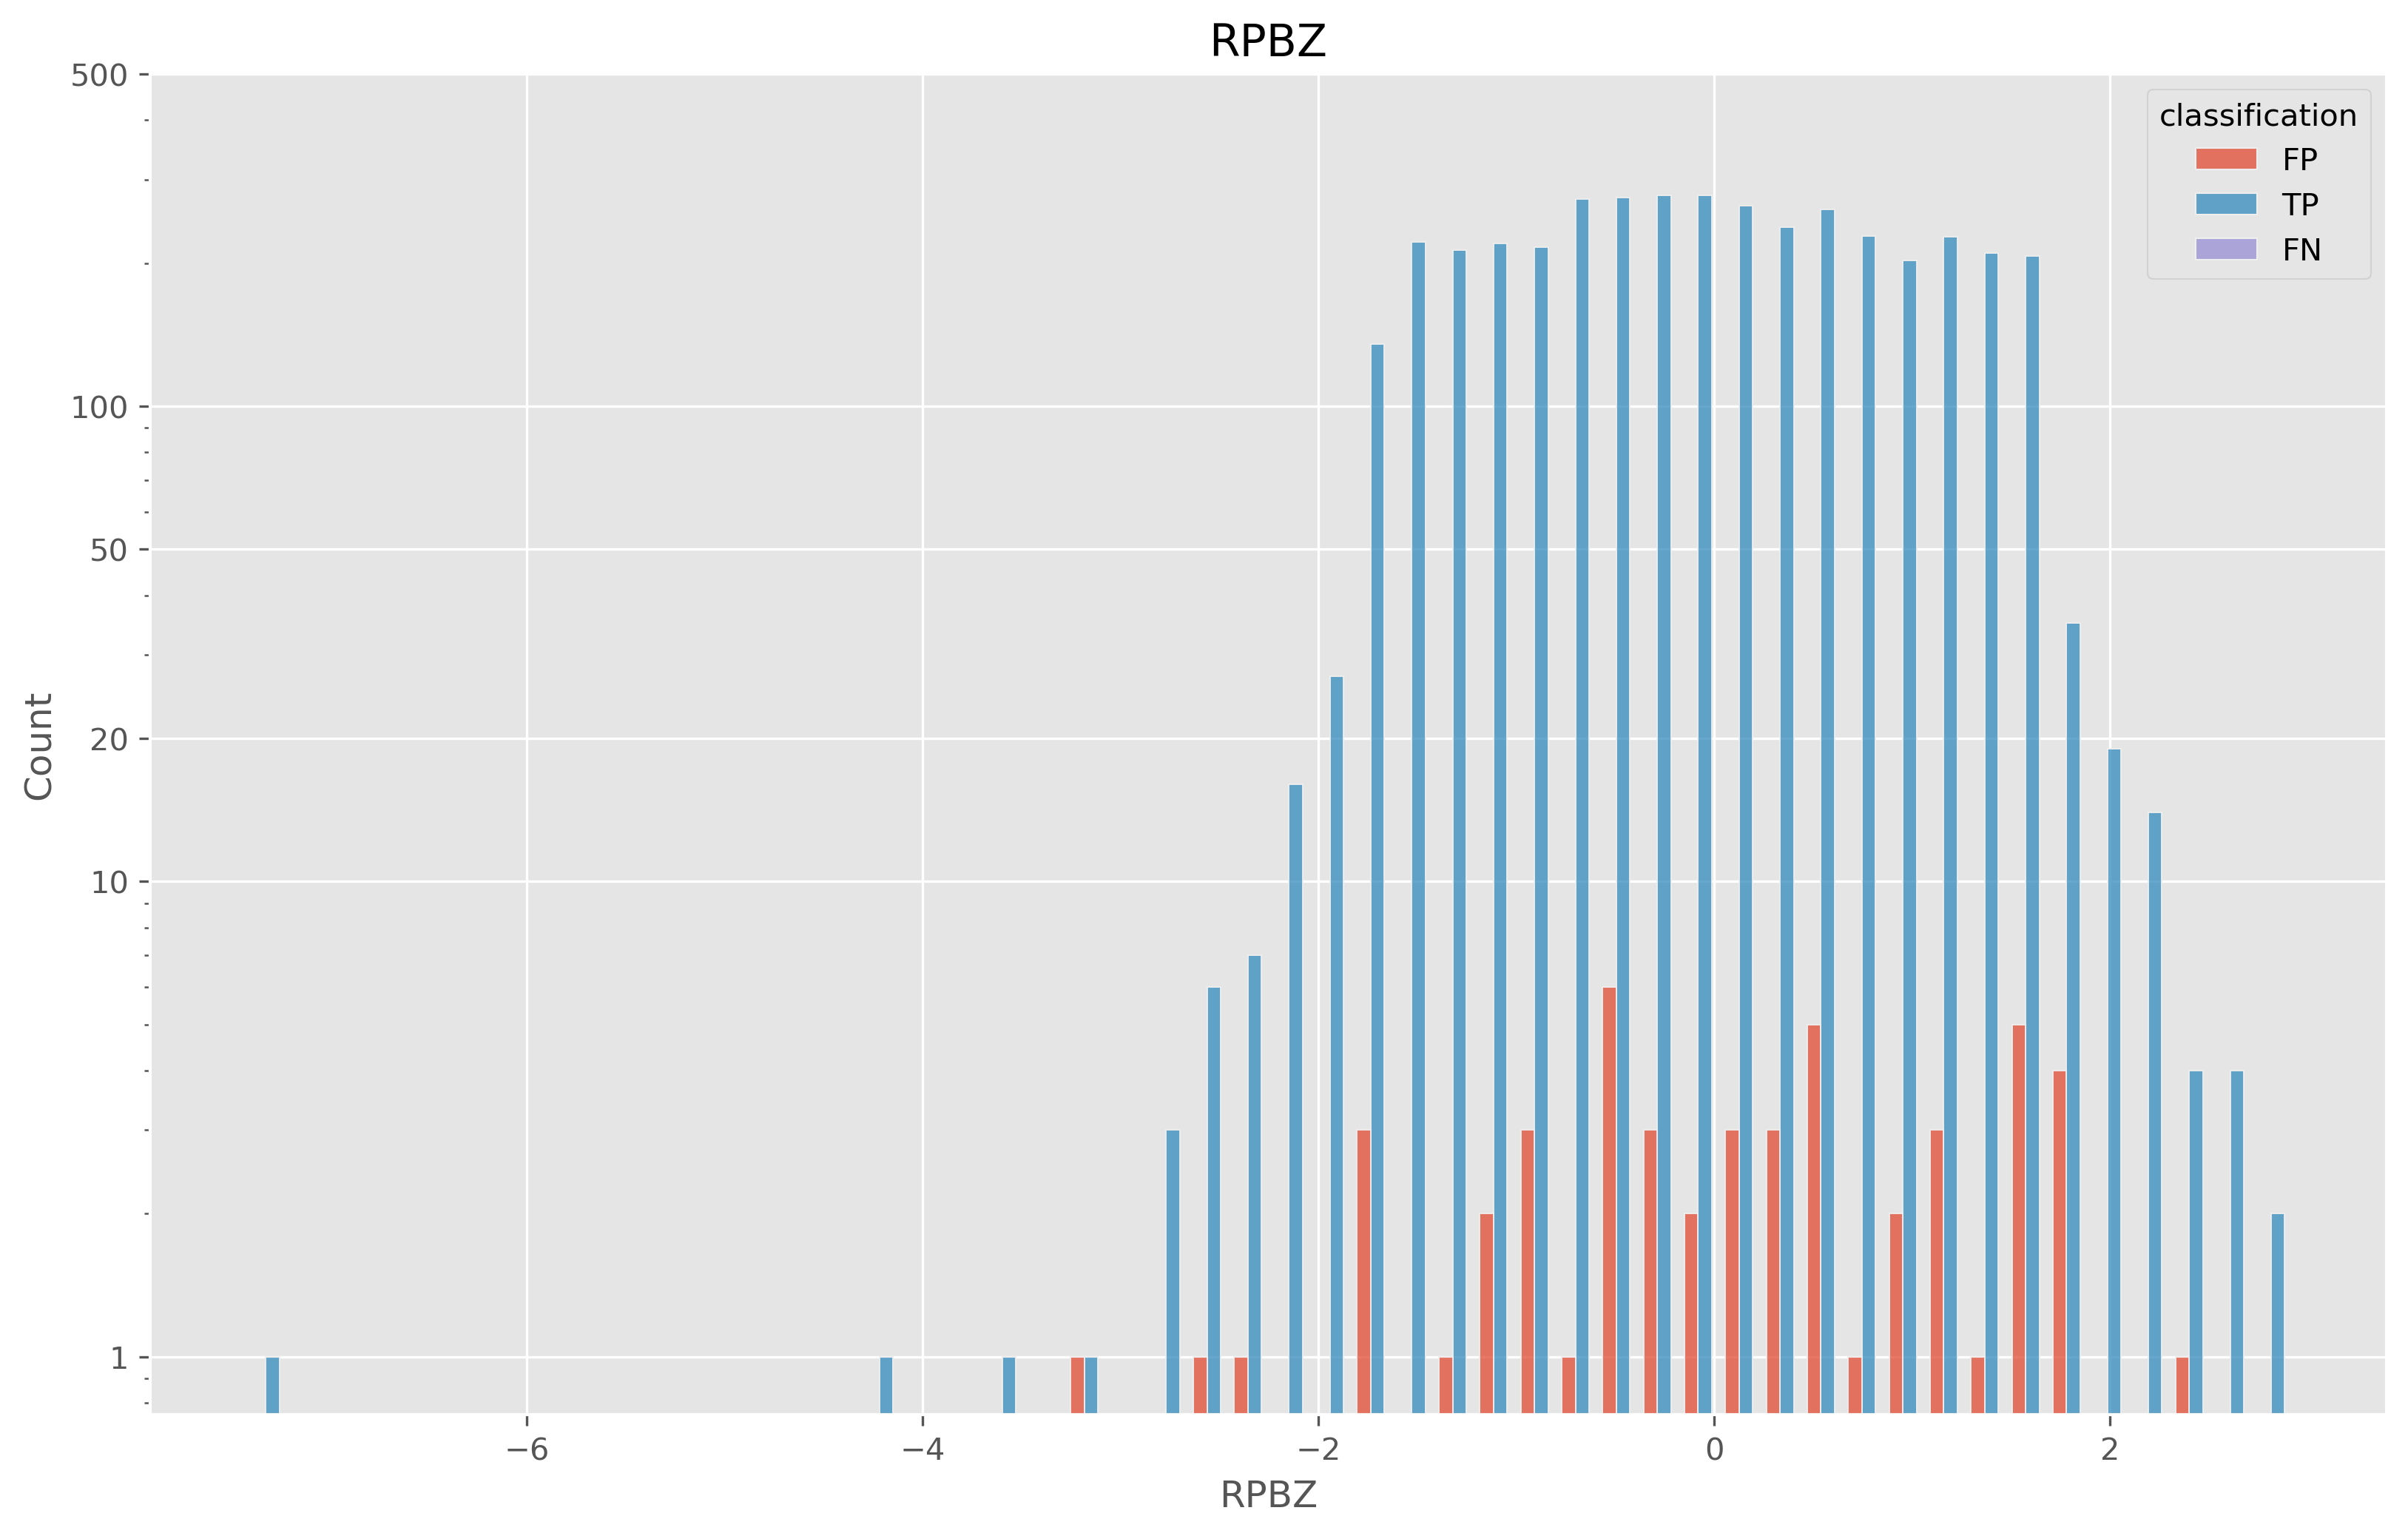

In [481]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "RPBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

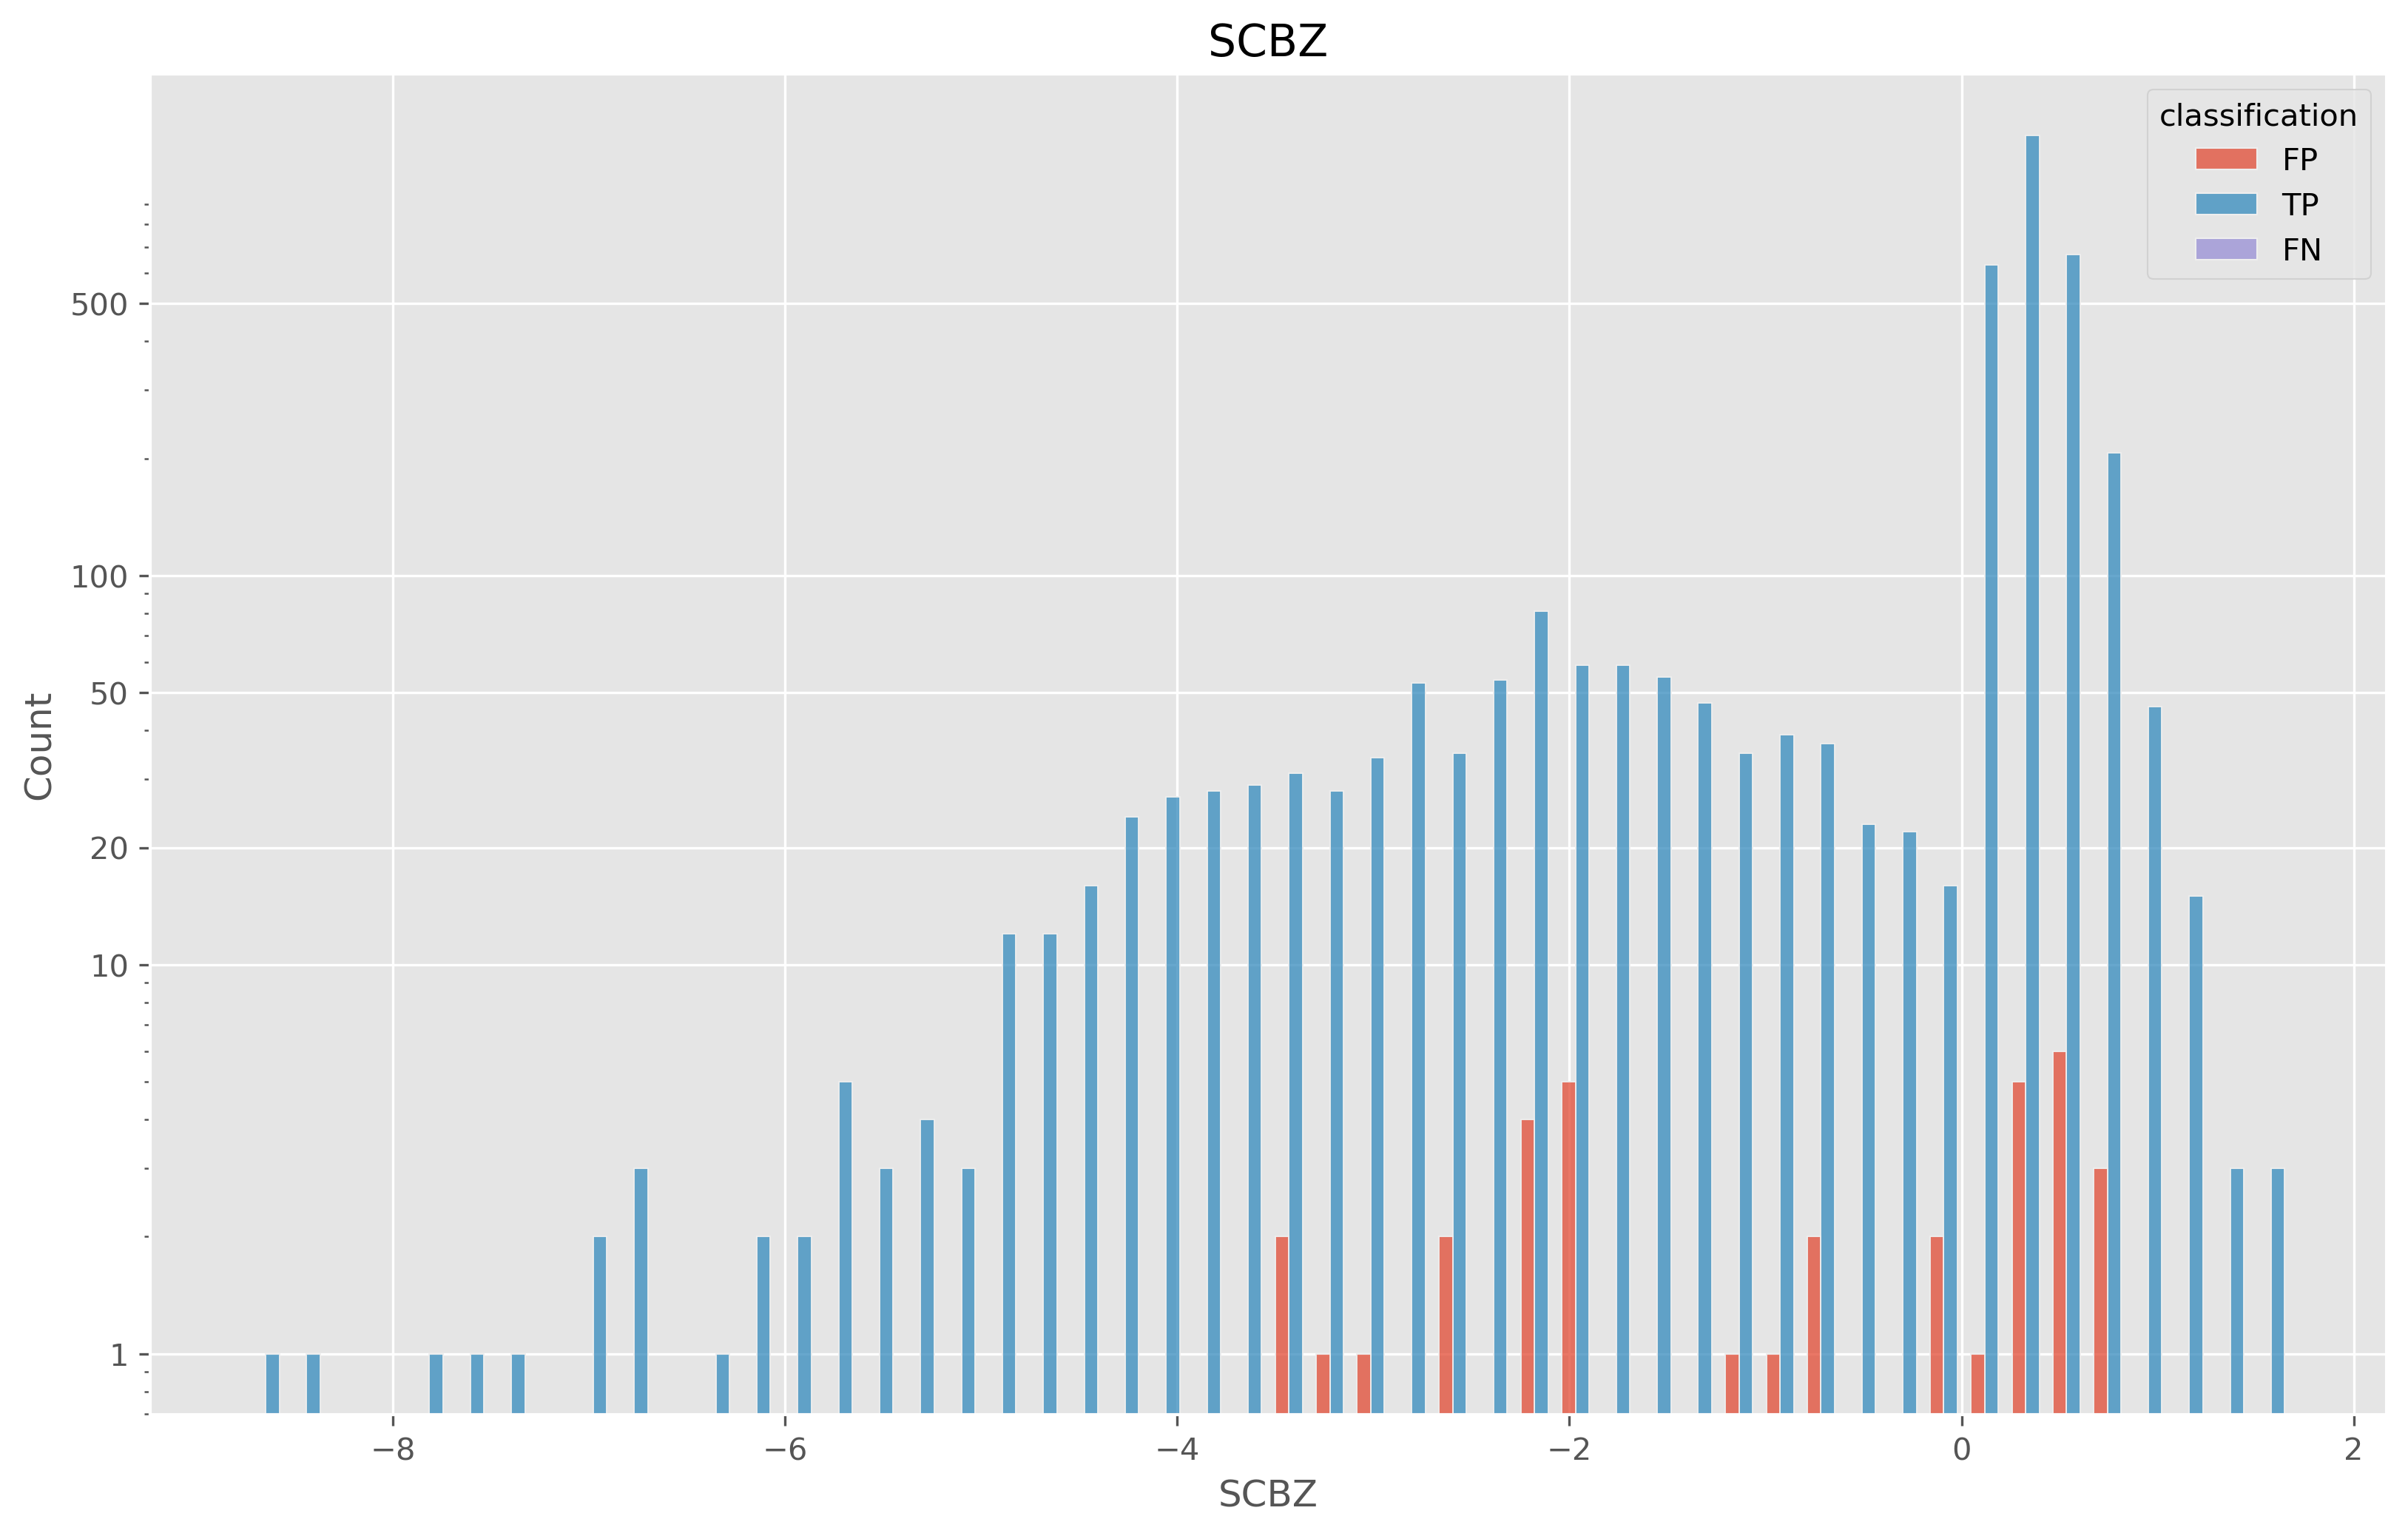

In [79]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

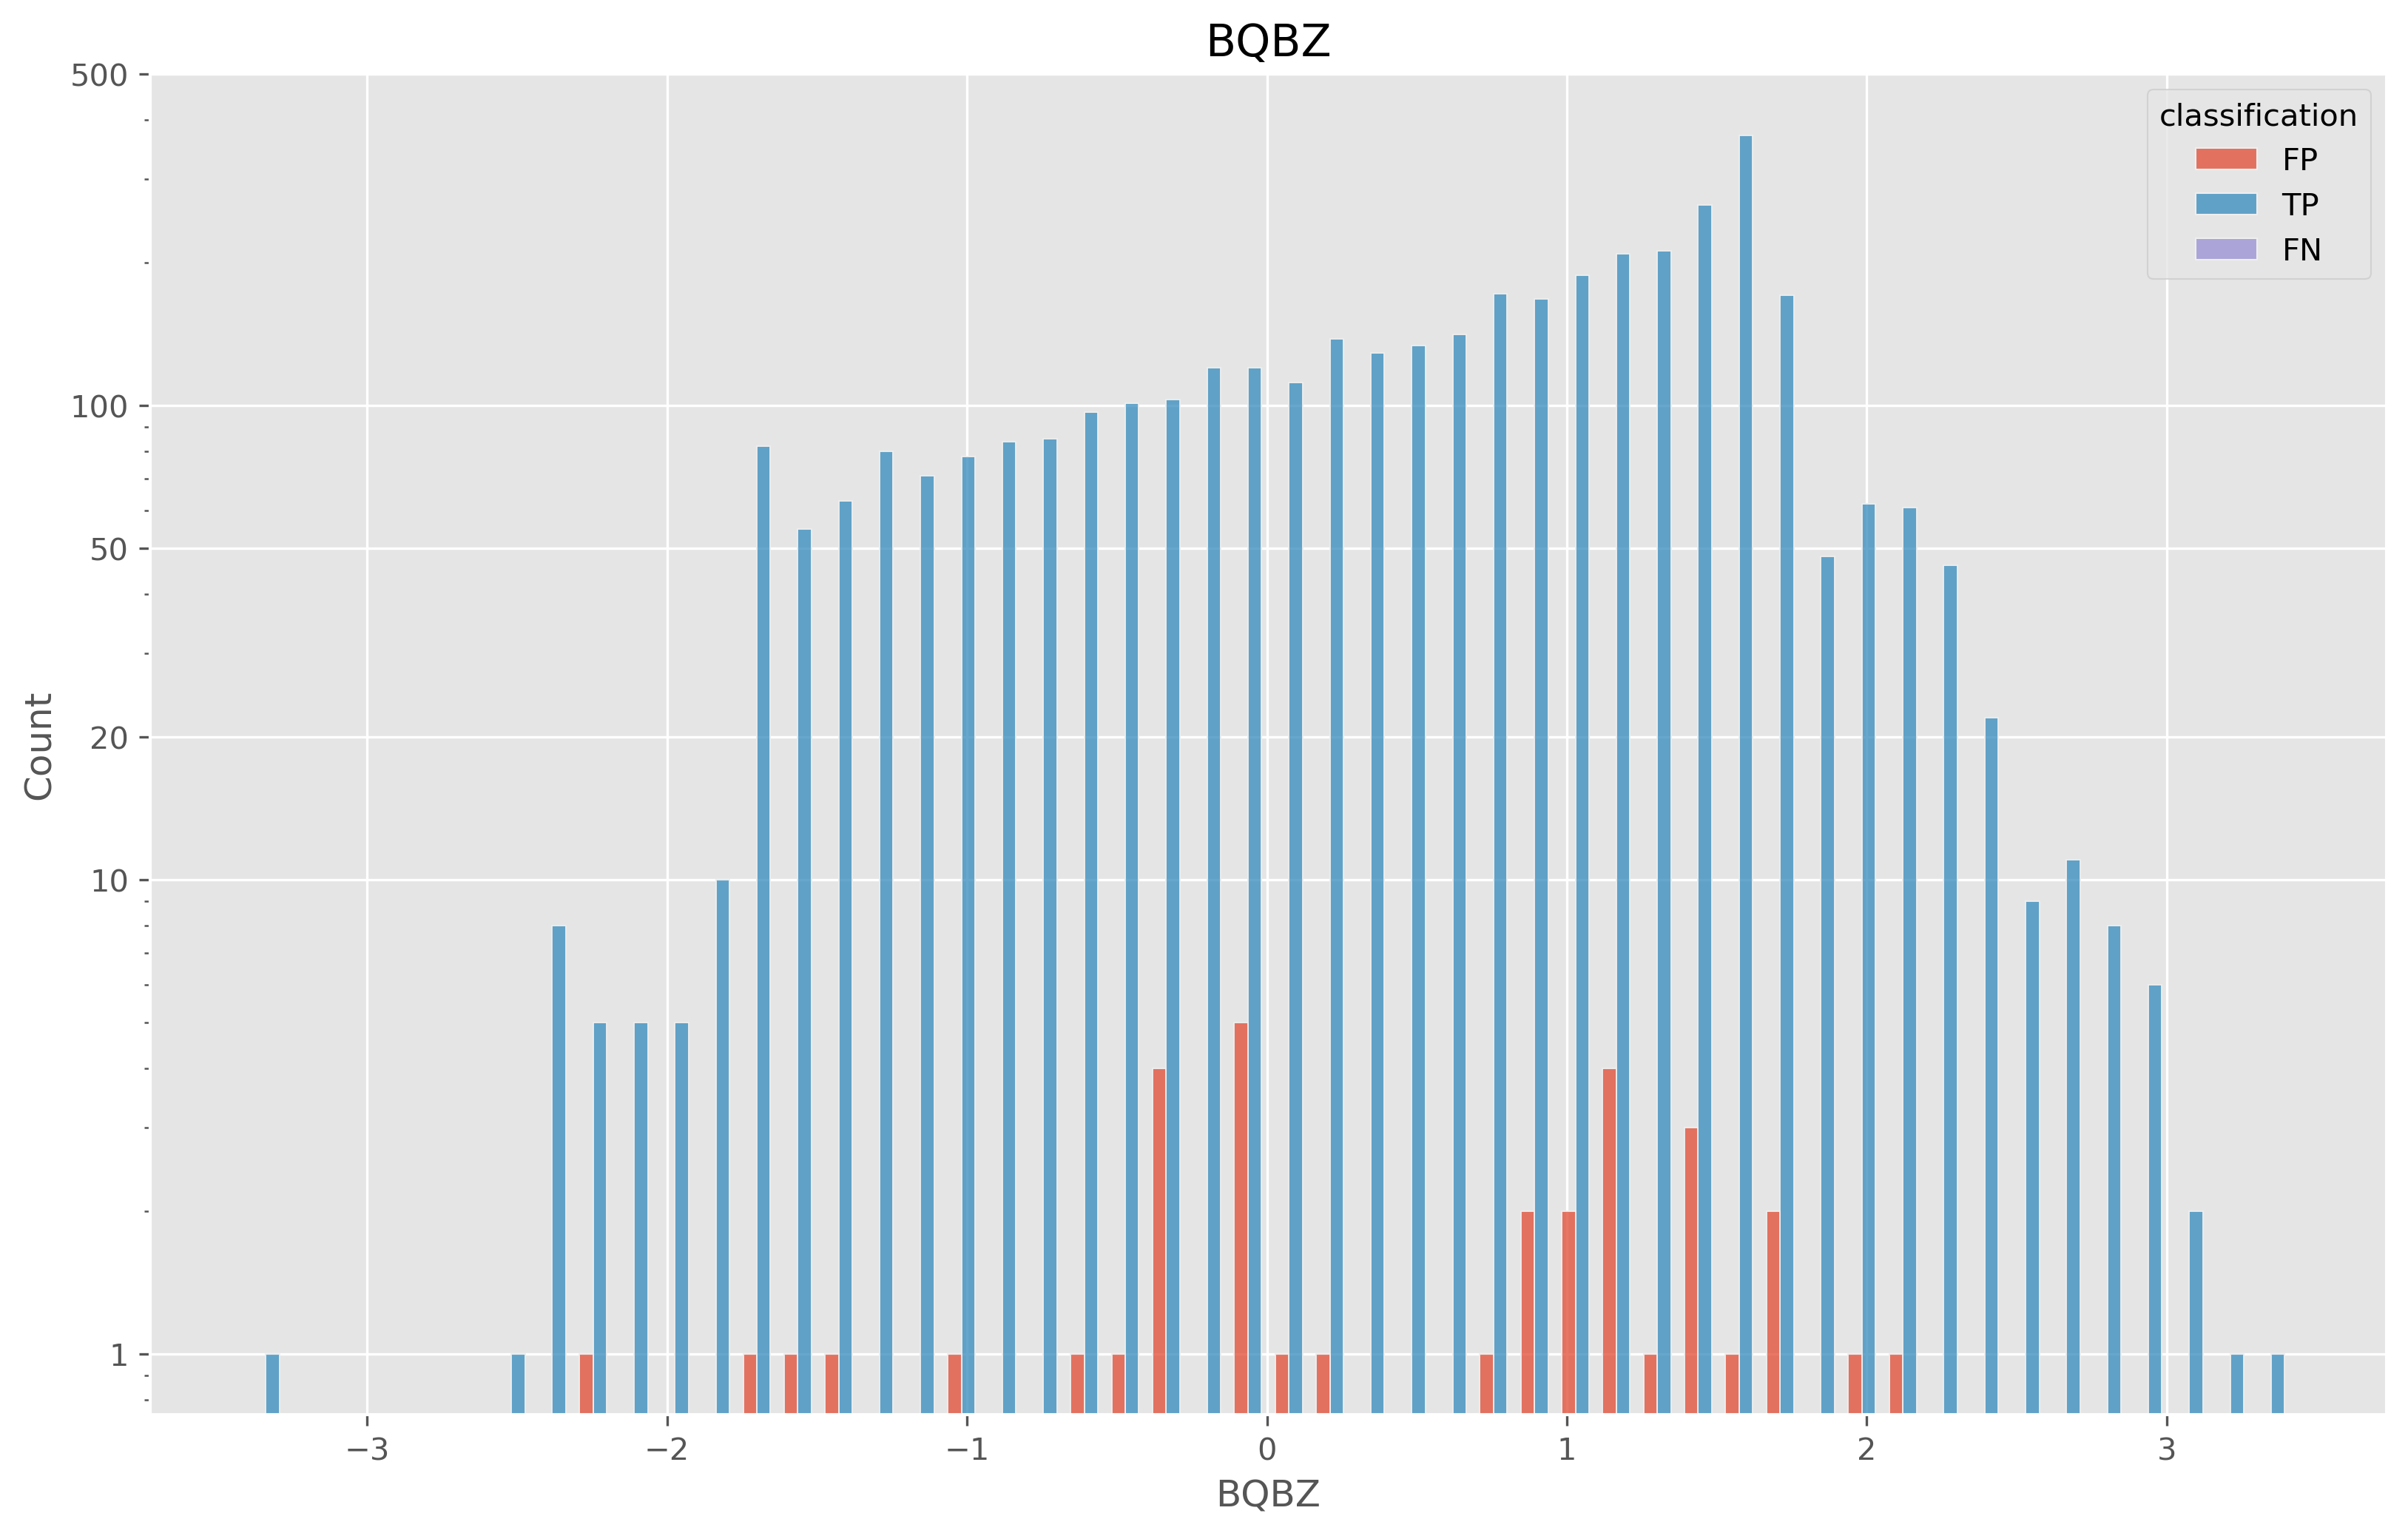

In [80]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "BQBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [441]:
print(len(df.query("SGB>-0.6 and classification=='TP'")))
print(len(df.query("SGB>-0.6 and classification=='FP'")))

15
3


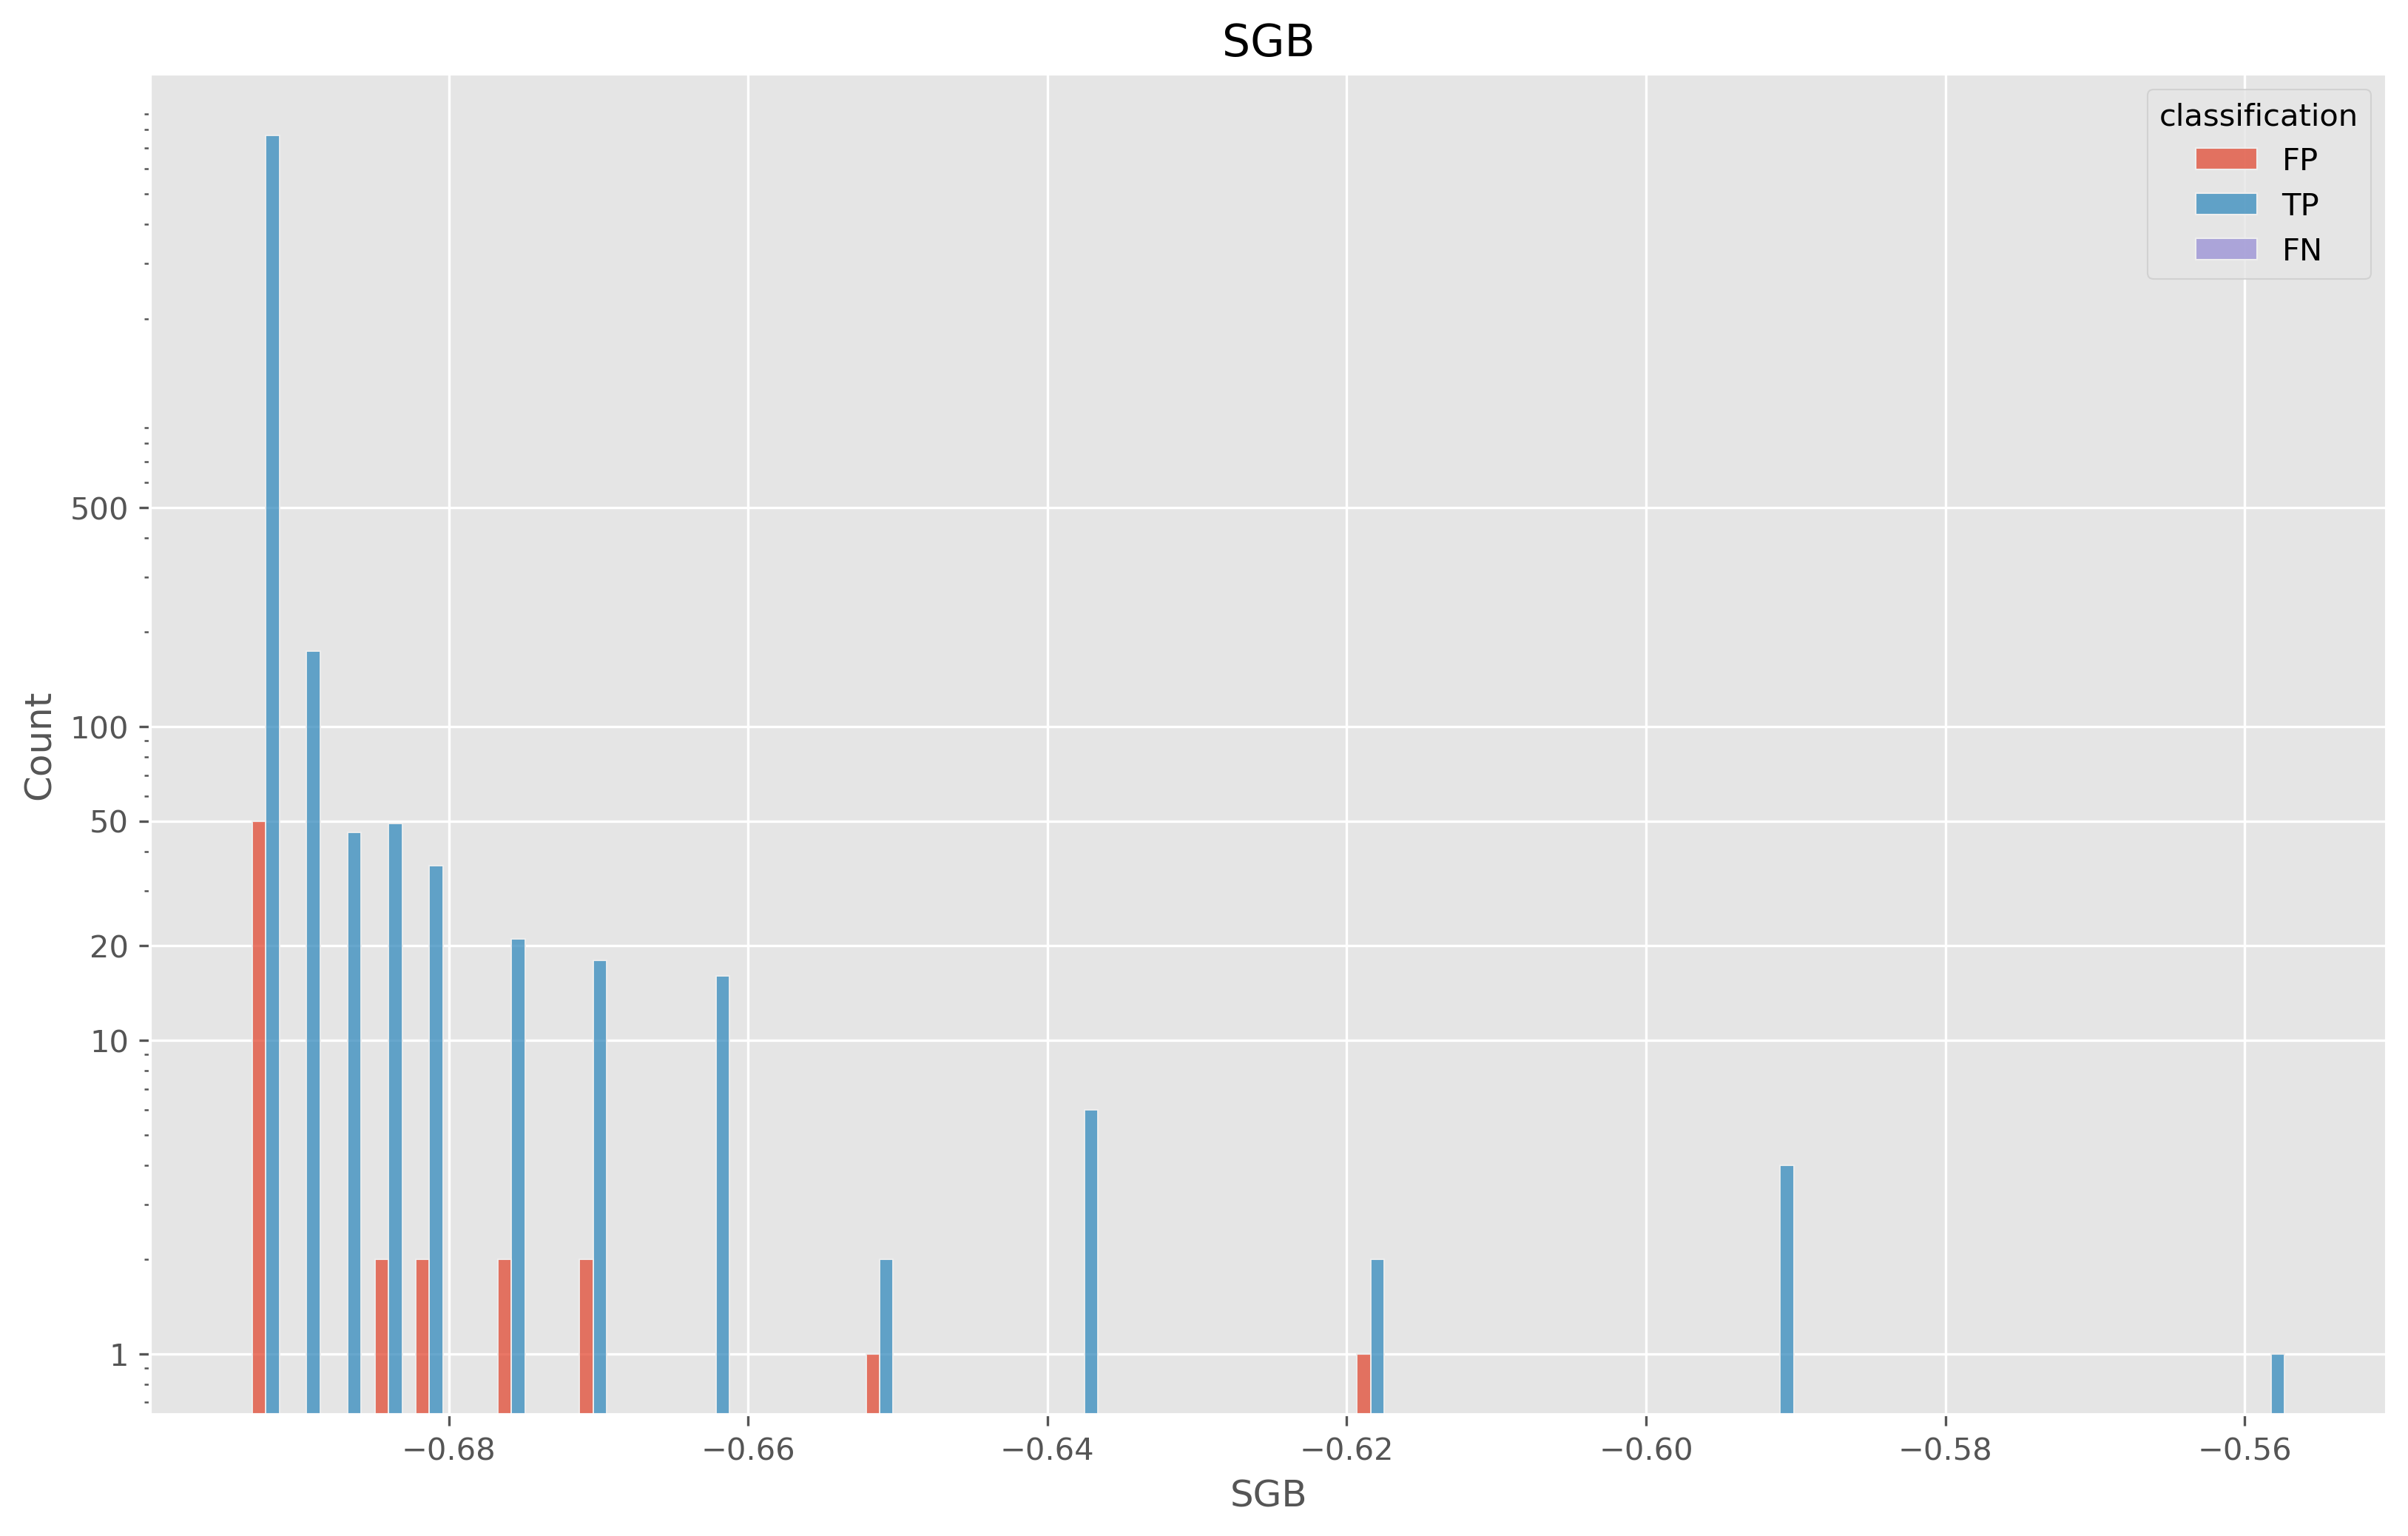

In [81]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SGB"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [195]:
columns

['sample',
 'pos',
 'classification',
 'quality',
 'FRS',
 'HQDP',
 'SB',
 'SP',
 'FED',
 'HQFED',
 'SCR',
 'SCRF',
 'MQSBZ',
 'MQ',
 'VDB',
 'RPBZ',
 'SCBZ',
 'BQBZ',
 'SGB',
 'DP']

In [286]:
df.query("SGB>-0.5")

,sample,pos,classification,quality,FRS,HQDP,SB,SP,FED,HQFED,SCR,SCRF,MQSBZ,MQ,VDB,RPBZ,SCBZ,BQBZ,SGB,DP
103,mada_1-44,180170,FP,6.512480,1.0,1,0.0,0,0.022901,0.007634,115,0.877863,NaN,60.0,NaN,NaN,NaN,NaN,-0.379885,3
270,mada_1-44,532513,FP,3.224508,1.0,1,0.0,0,0.007634,0.007634,104,0.793893,NaN,60.0,NaN,NaN,NaN,NaN,-0.379885,1
404,mada_1-44,820702,FP,4.384660,1.0,2,0.0,0,0.045802,0.015267,98,0.748092,NaN,60.0,0.64,NaN,NaN,NaN,-0.453602,6
1727,mada_1-44,4092921,FP,12.656574,1.0,2,0.5,0,0.038168,0.015267,77,0.587786,NaN,60.0,0.10,NaN,NaN,NaN,-0.453602,5
2637,mada_102,3379884,TP,18.476357,1.0,2,0.5,0,0.088435,0.013605,63,0.428571,NaN,60.0,0.36,NaN,NaN,NaN,-0.453602,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8908,mada_132,1996022,FP,27.422153,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8909,mada_132,1996024,FP,27.422153,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8910,mada_132,1996035,FP,15.537348,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8911,mada_132,1996036,FP,15.537348,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2


Text(0.5, 1.0, 'VDB')

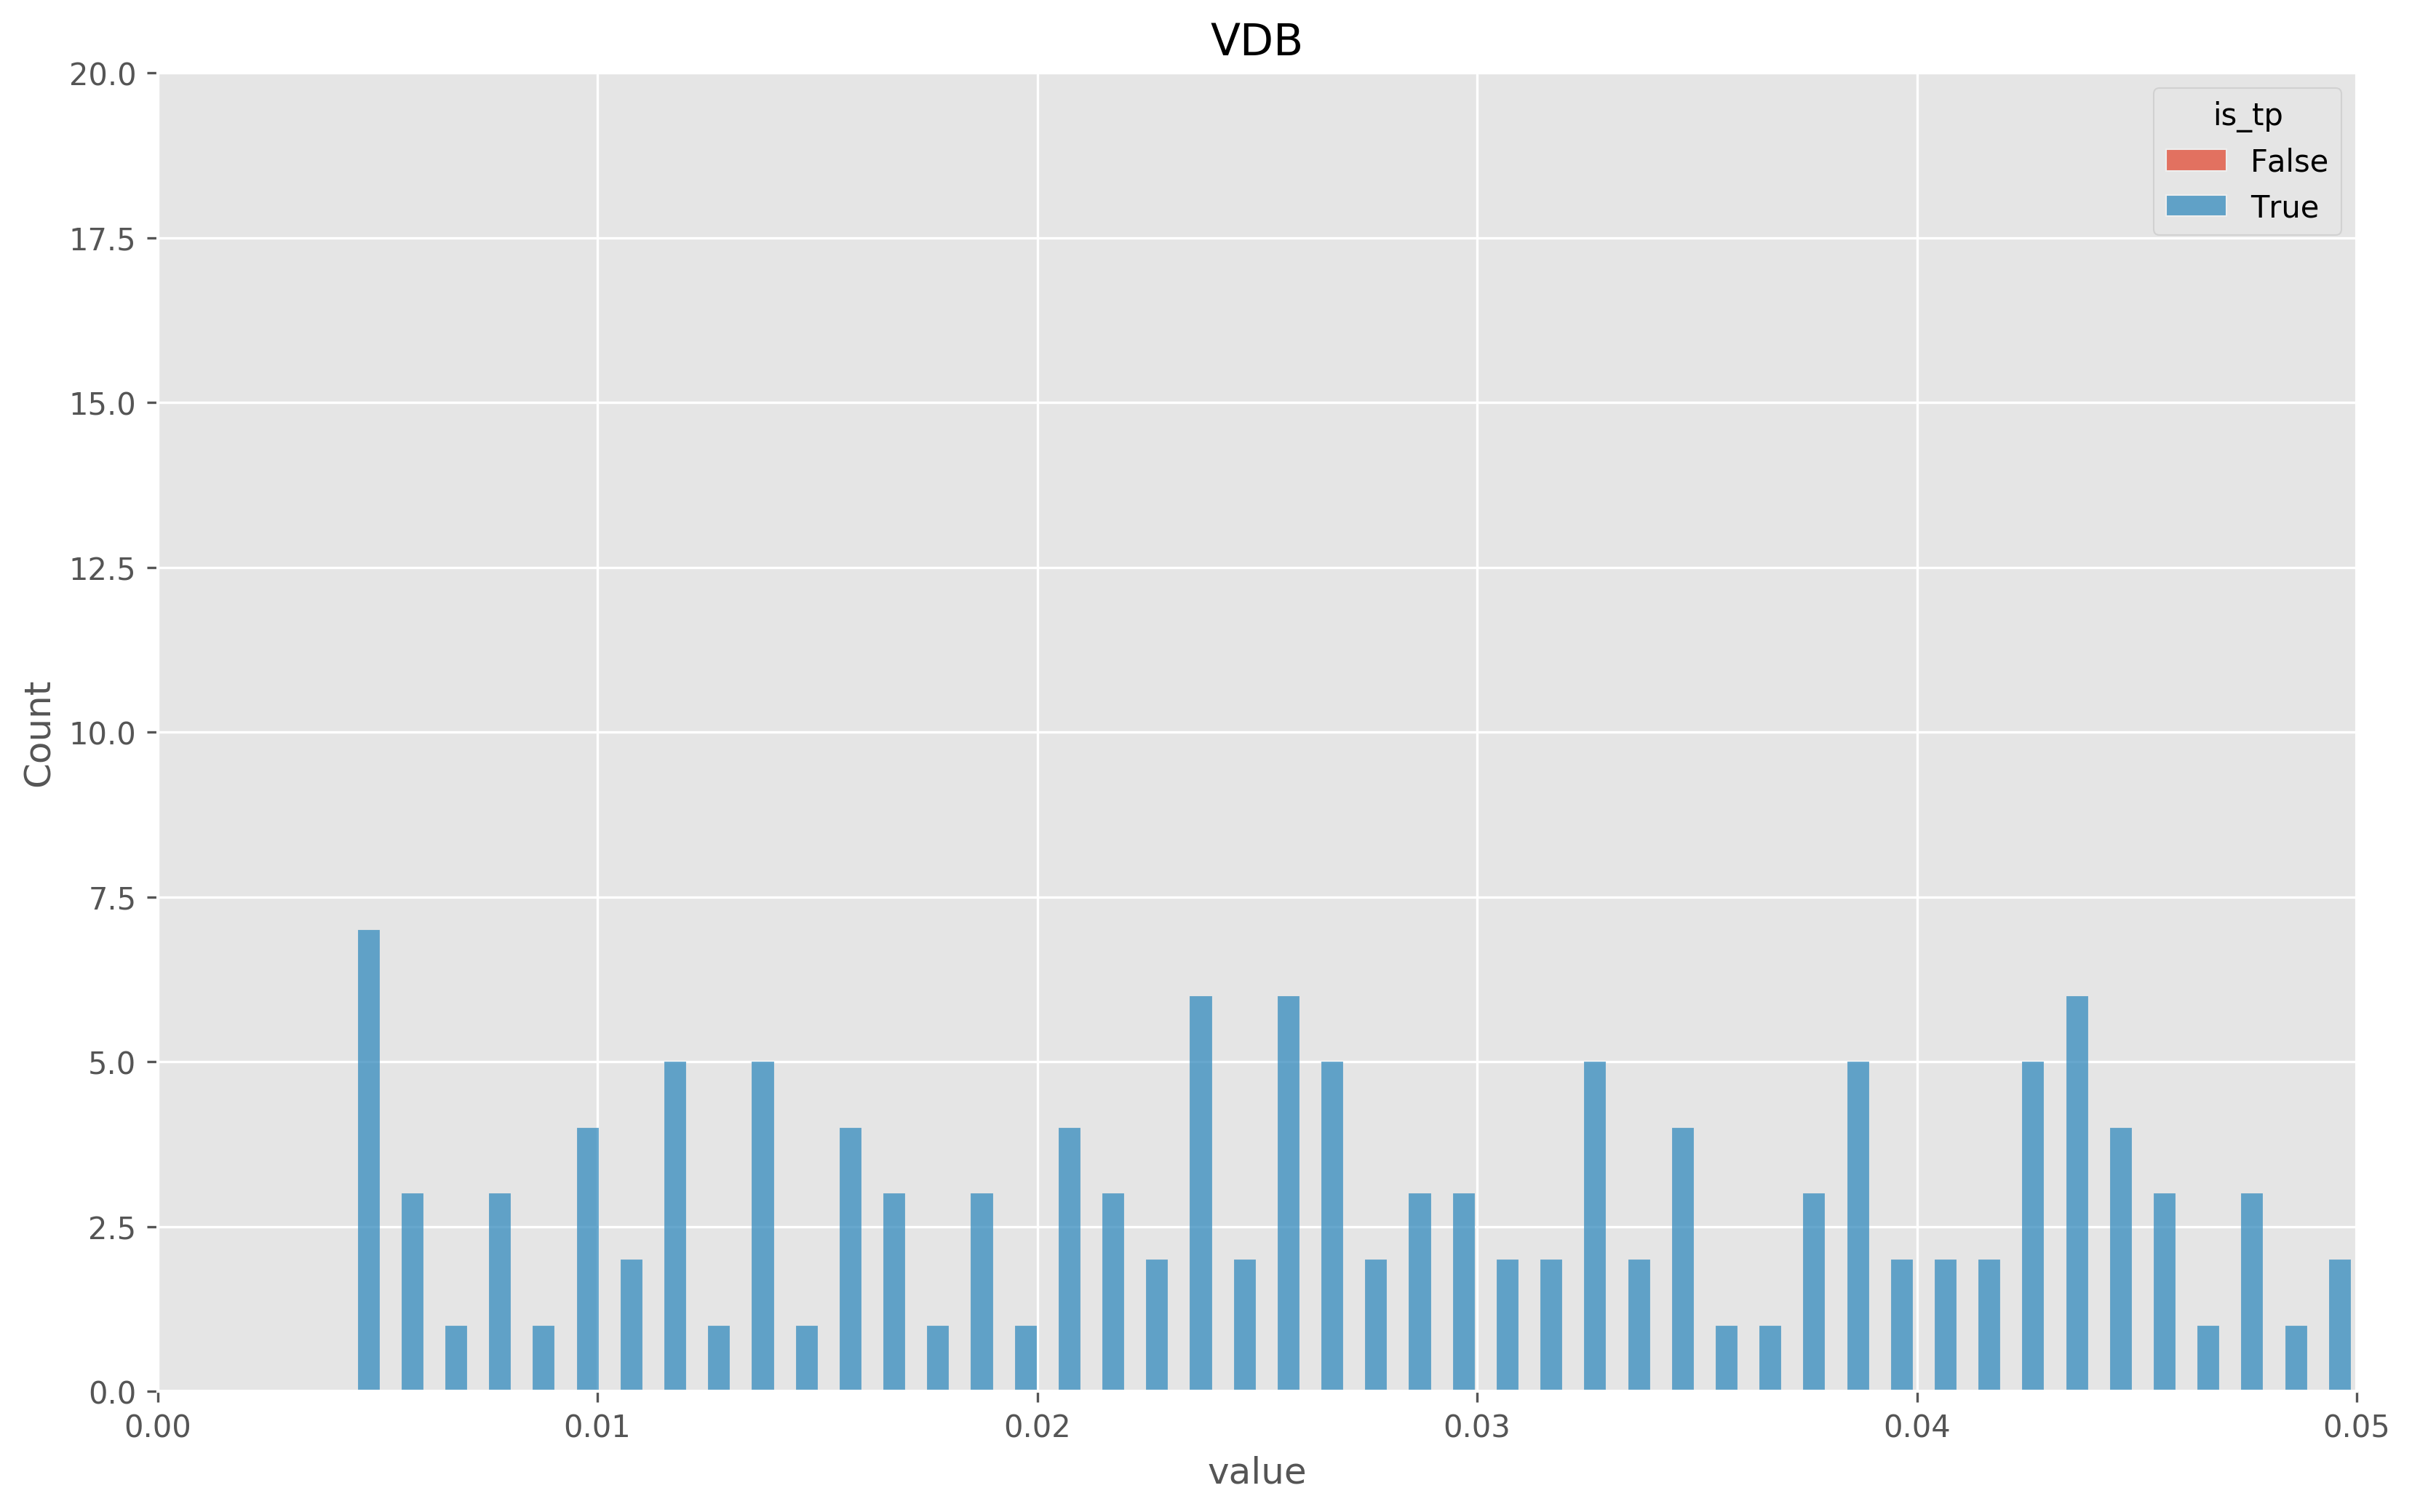

In [631]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", bins=1000)
# sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", stat="percent", common_norm=False)
ax.set_xlim((0, 0.05))
ax.set_ylim((0, 20))
# sns.violinplot(data=data, x=x, y=y, ax=ax)
ax.set_title(field)

Text(0.5, 1.0, 'MQBZ')

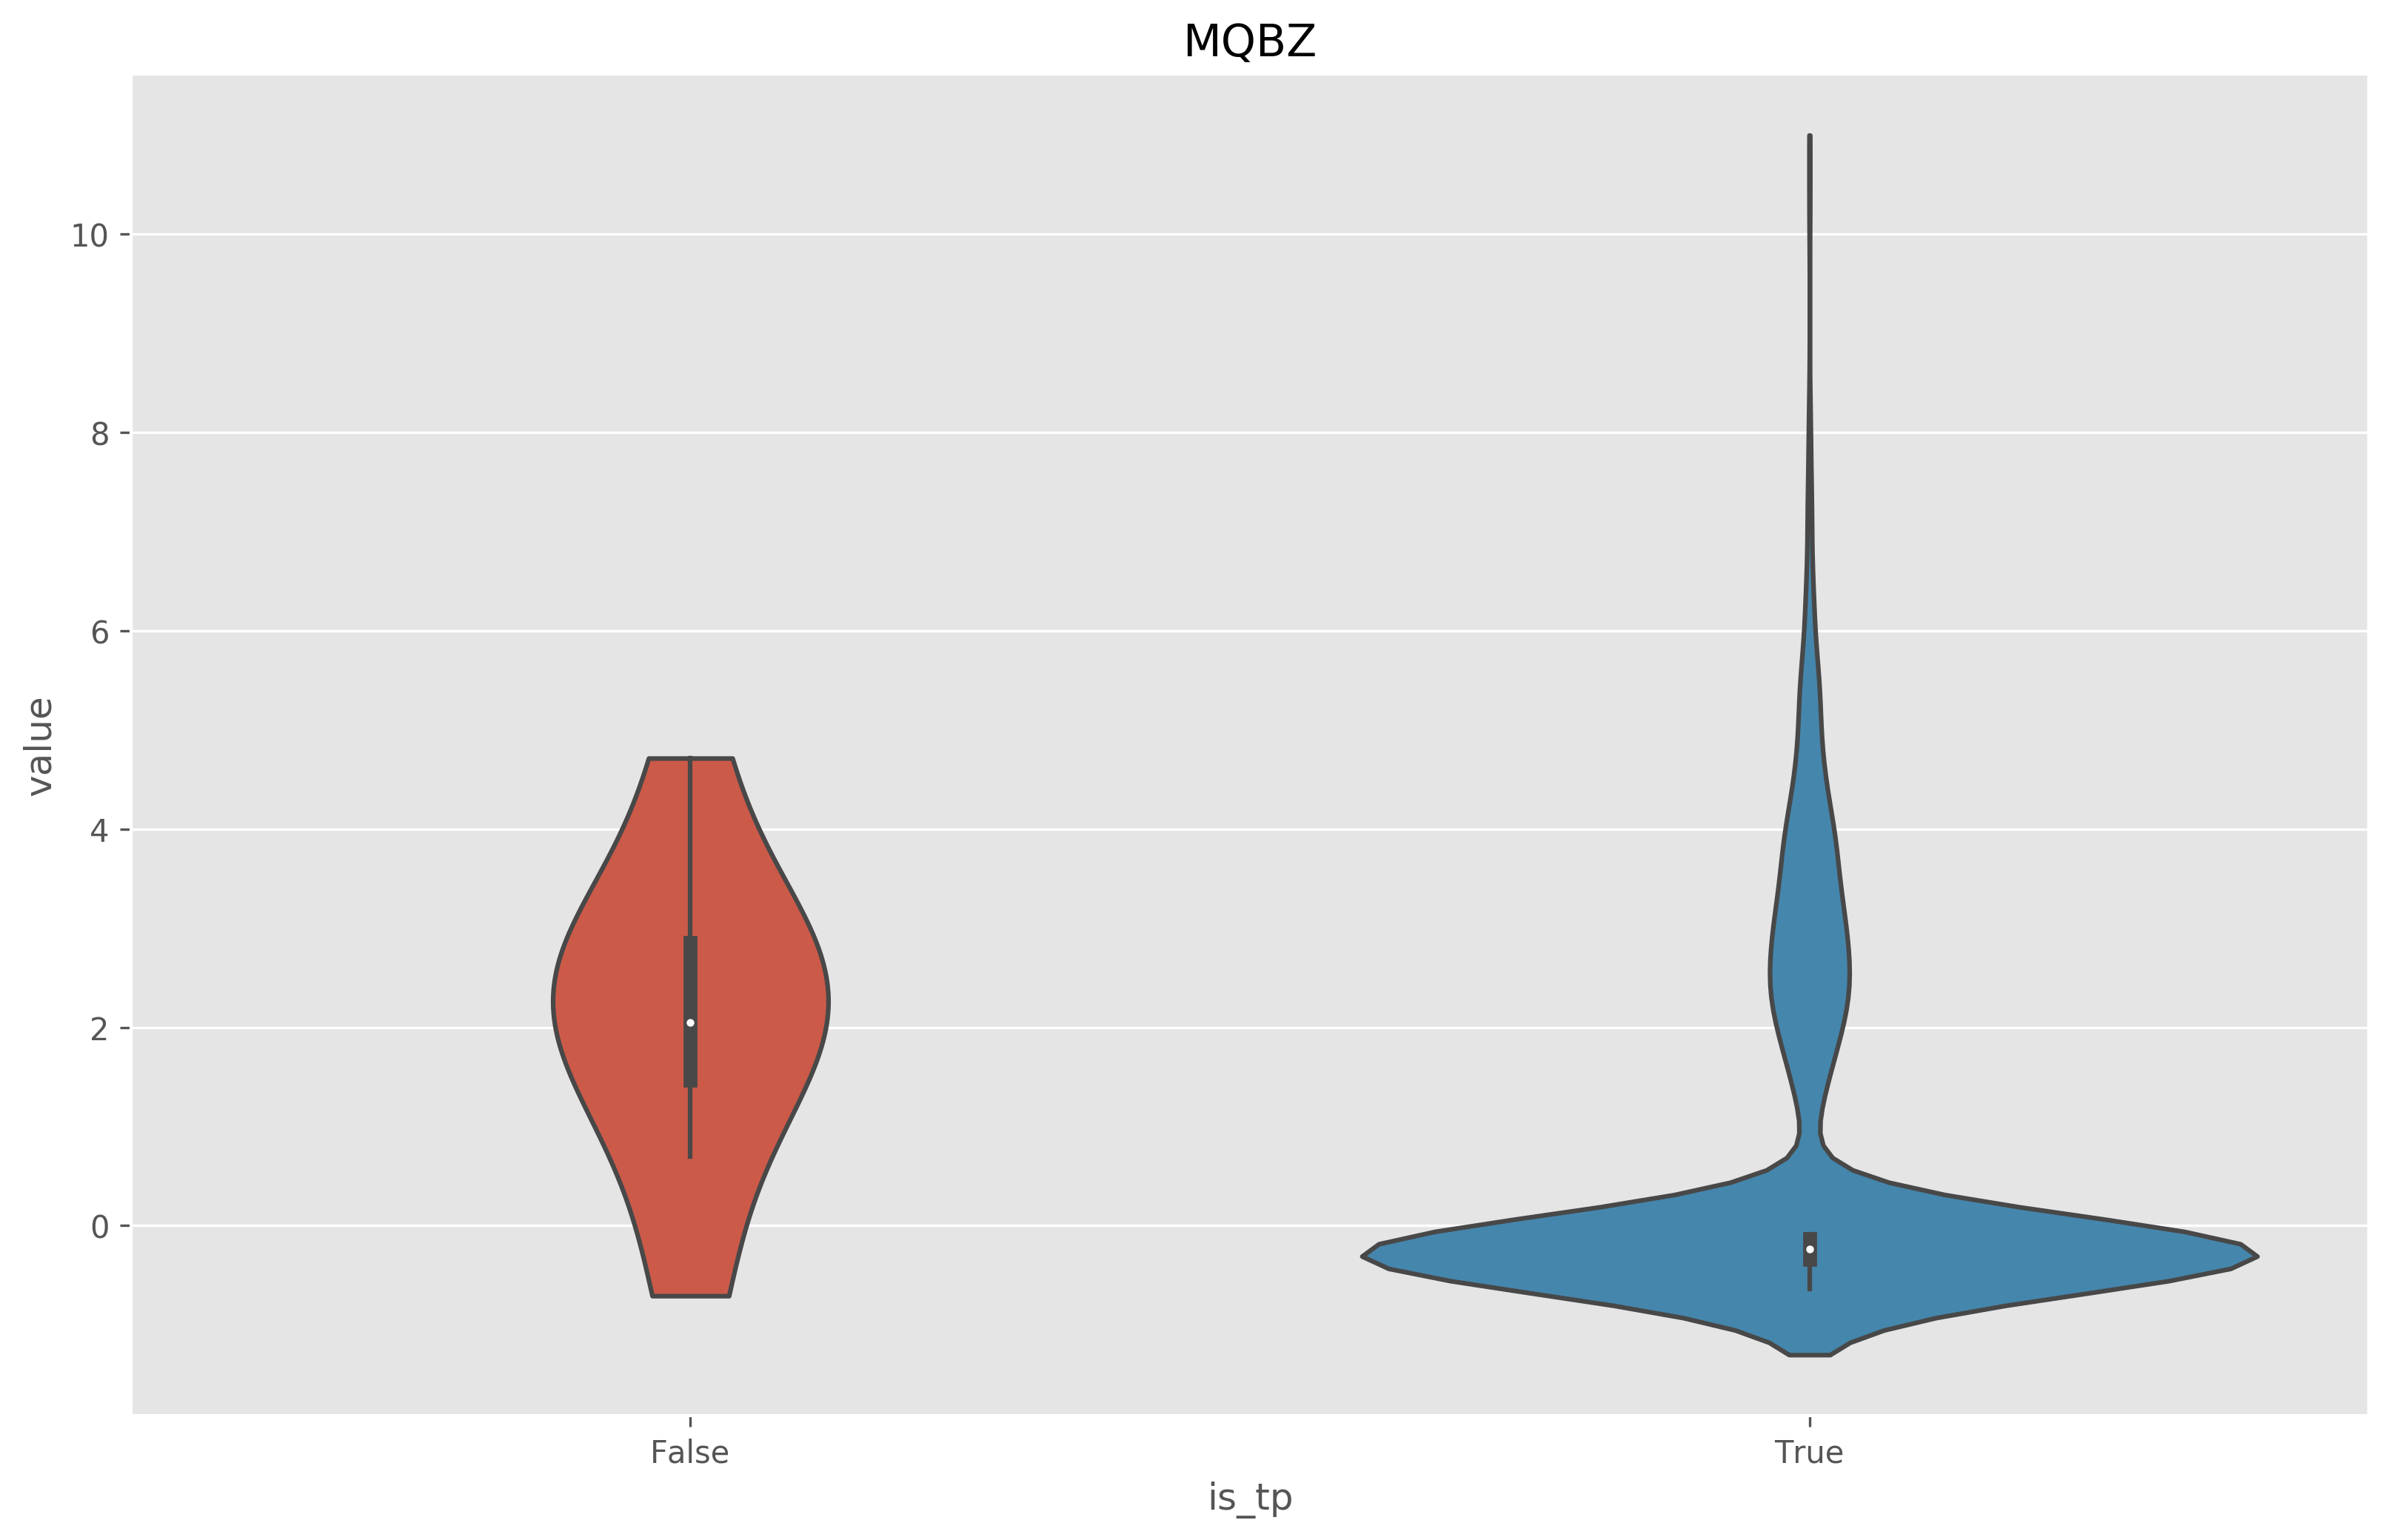

In [632]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
x = "is_tp"
y = "value"
field = info[9]
data = df.query("field==@field")
sns.violinplot(data=data, x=x, y=y, ax=ax, cut=0)
ax.set_title(field)

Text(0.5, 1.0, 'MQBZ')

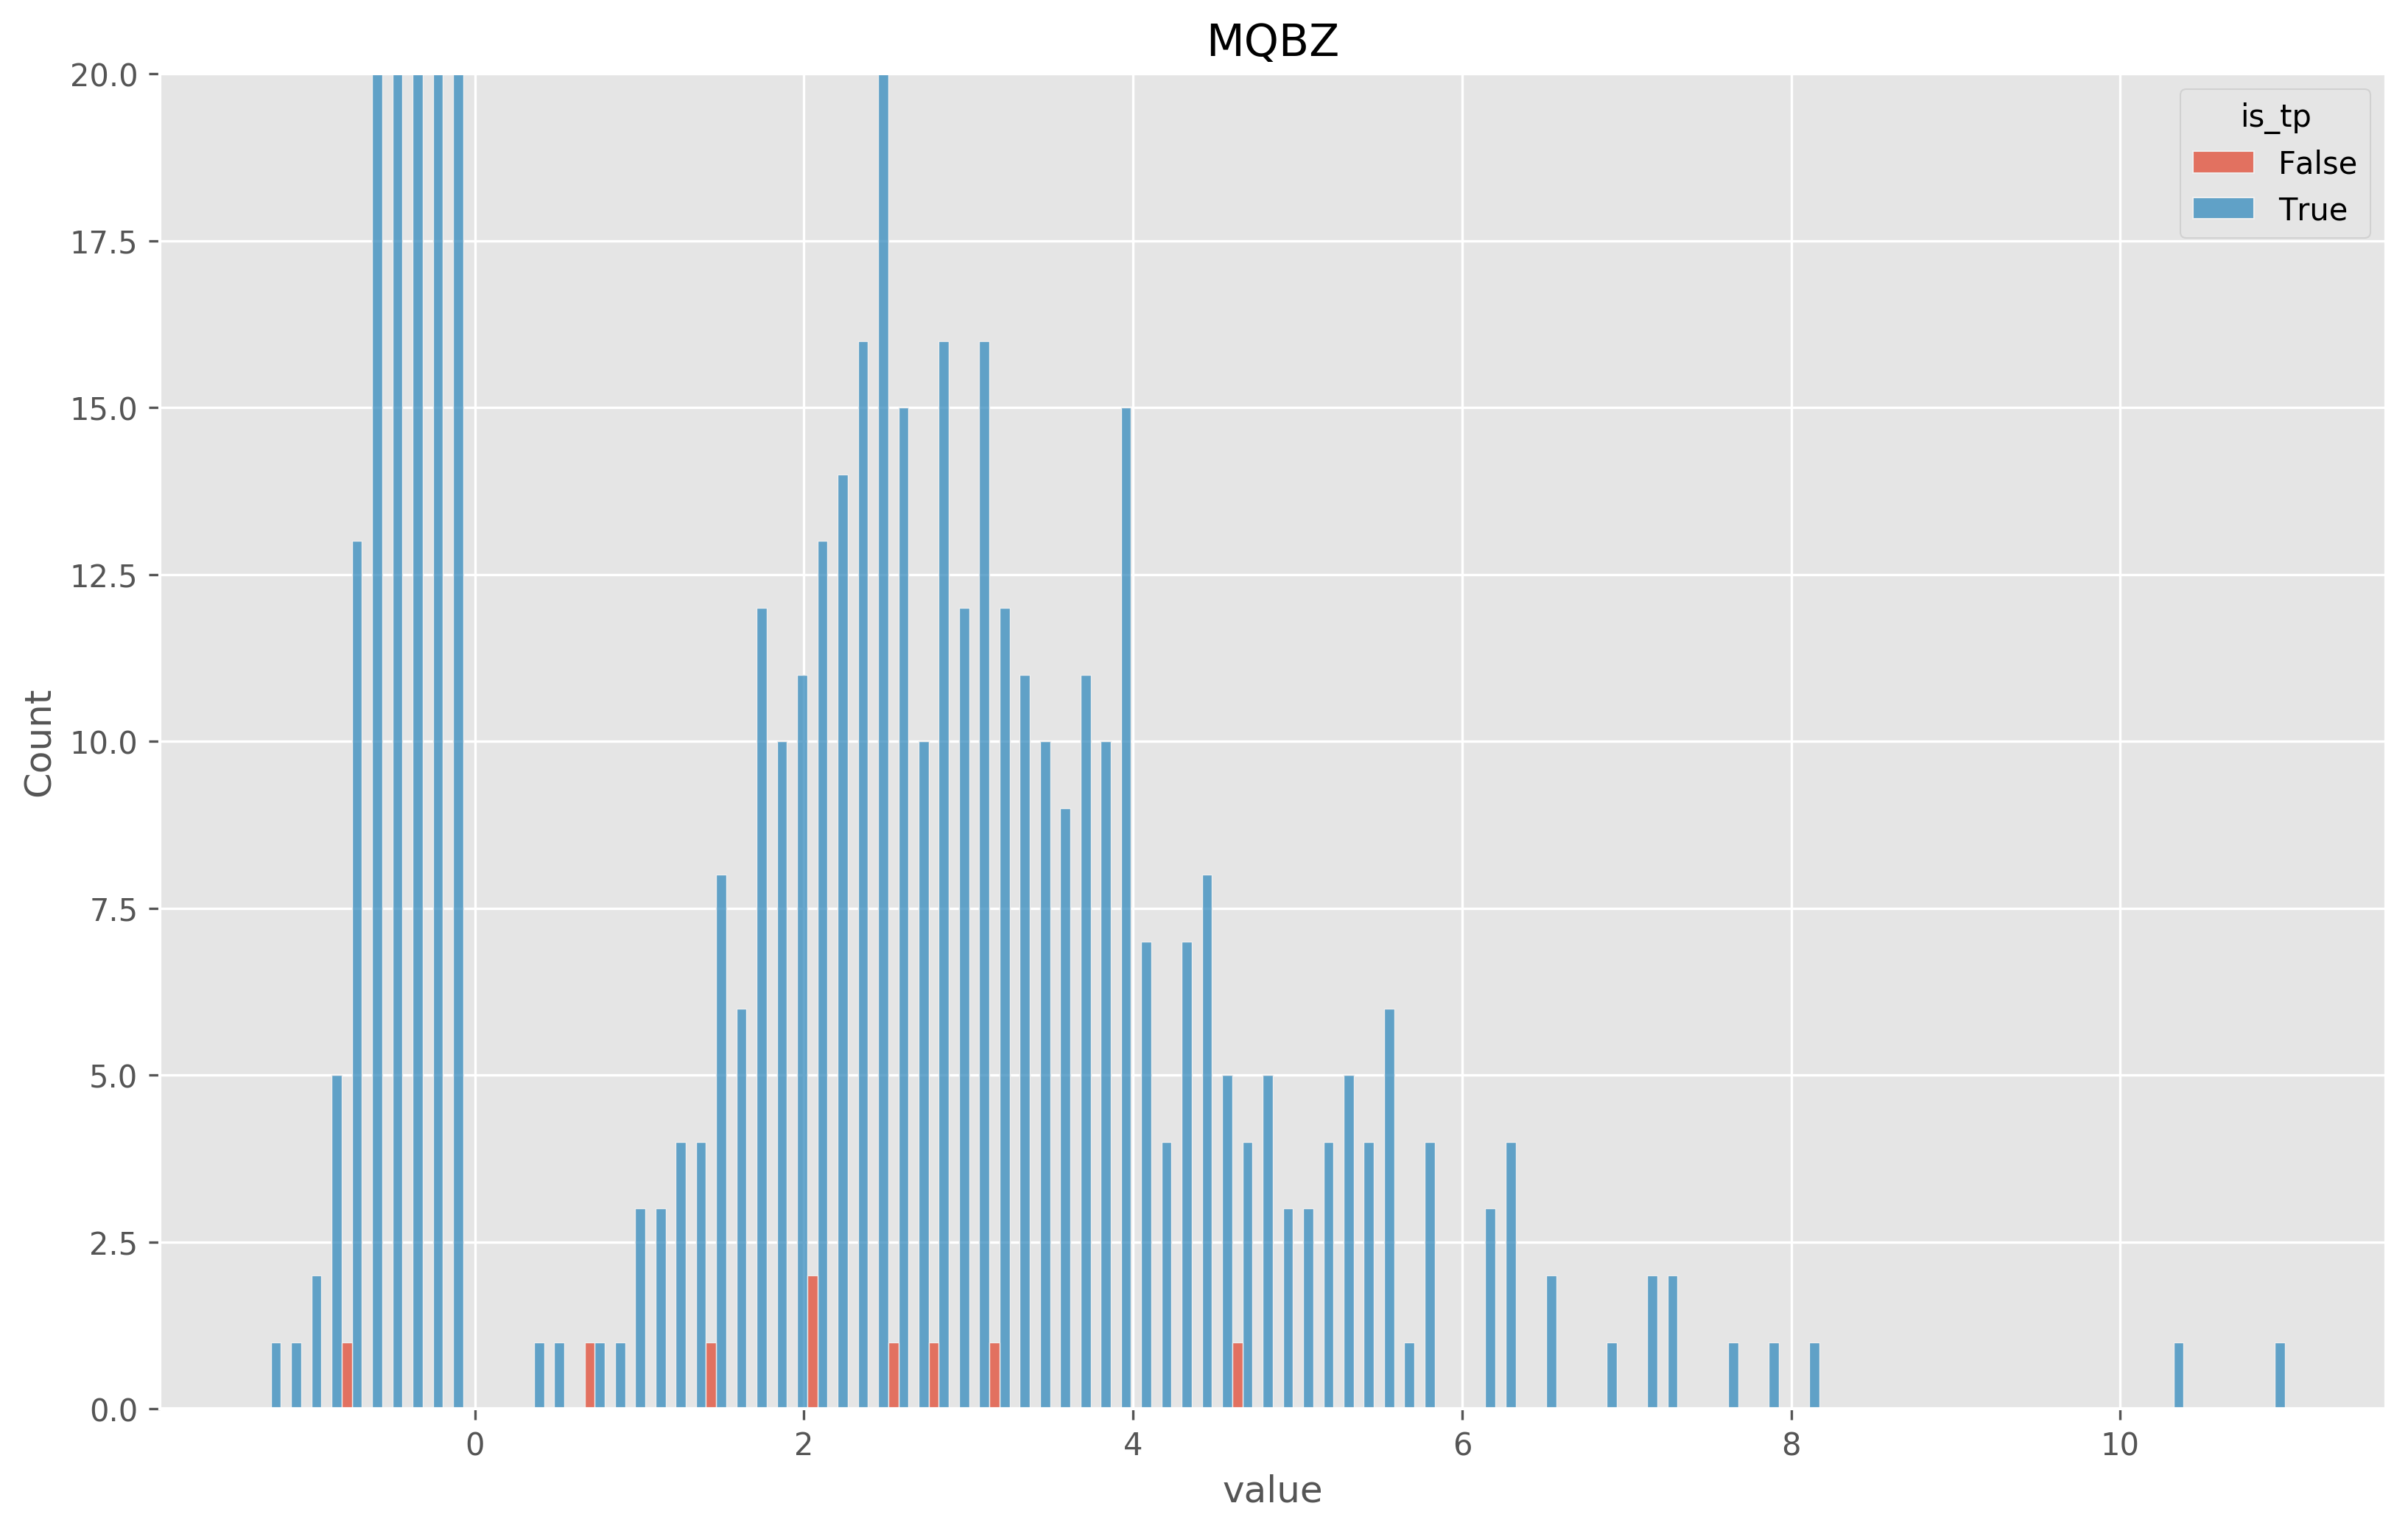

In [634]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", bins=100)
# sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", stat="percent", common_norm=False)
# ax.set_xlim((0, 0.0005))
ax.set_ylim((0, 20))
# sns.violinplot(data=data, x=x, y=y, ax=ax)
ax.set_title(field)